In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
import matplotlib.pyplot as plt
import traceback
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from itertools import product






In [2]:
file_path = "C:/Users/Admin/Desktop/PROJECT WORK/DROUGHT-FORECASTING-IN-KENYA-USING-MACHINE-LEARNING/MLFile.xlsx"
sheet_names = pd.ExcelFile(file_path).sheet_names
sheet_dict = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheet_names}
print (sheet_dict)



{'VOI':     YEAR       VOI       N34        N4      IODE      IODW
0   1950 -1.394247 -0.986667 -1.333333 -0.573333 -0.399667
1   1951  1.201303  0.326667 -0.050000 -0.502000 -0.033667
2   1952 -0.699184 -0.560000 -0.643333 -0.292667 -0.500000
3   1953 -0.371094  0.173333 -0.243333 -0.568000 -0.216333
4   1954 -1.301085 -1.403333 -1.170000 -0.427000 -0.734667
..   ...       ...       ...       ...       ...       ...
70  2020  0.576719 -0.573333 -0.290000  0.202000 -0.017667
71  2021 -0.612503 -0.490000 -0.350000  0.200333 -0.128333
72  2022 -1.417739 -0.910000 -1.080000  0.120667 -0.254333
73  2023  0.372574  1.323333  0.916667 -0.097000  0.756333
74  2024 -0.058478 -0.113333  0.356667  0.459667  0.138333

[75 rows x 6 columns], 'MOYALE':     YEAR    MOYALE       N34        N4      IODE      IODW
0   1950 -1.016254 -0.986667 -1.333333 -0.573333 -0.399667
1   1951  2.097321  0.326667 -0.050000 -0.502000 -0.033667
2   1952 -0.004062 -0.560000 -0.643333 -0.292667 -0.500000
3   1953  0.27

In [3]:
# CORRELATION ANALYSIS BETWEEN RAINFALL AND SST VARIABLES

filtered_sheet_dict = {}
correlation_dict = {} 

for station, df in sheet_dict.items():
    print(f"\nProcessing station: {station}")
    print(f"Original columns: {df.columns.tolist()}")
    
    df_copy = df.copy()
    
    # Drop rows with missing values
    df_copy.dropna(inplace=True)
    
    # Check if any data remains after dropping missing values
    if df_copy.empty:
        print(f"No data left for {station} after dropping missing values. Skipping...")
        continue

    year_col = "YEAR"
    rainfall_col = station  
    
    print(f"Year column: {year_col}")
    print(f"Rainfall column: {rainfall_col}")
    
    sst_cols = [col for col in df_copy.columns if col not in [year_col, rainfall_col]]
    print(f"SST columns: {sst_cols}")
    
    print(f"\nCorrelation results for {station}:")
    
    retained_cols = []
    station_correlations = {}  
    
    # Calculate correlations between each SST predictor and station rainfall
    for col in sst_cols:
        try:
            corr, p_value = stats.pearsonr(df_copy[col], df_copy[rainfall_col])
            print(f"{col}: r={corr:.2f}, p={p_value:.3f}")
            station_correlations[col] = {'correlation': corr, 'p_value': p_value}  # Save correlation stats
            
            # Keep only significant predictors (p-value <= 0.05)
            if p_value <= 0.05:
                retained_cols.append(col)
            else:
                print(f"Dropped {col} from {station} (p={p_value:.3f})")
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
    
    # Store the correlation results
    correlation_dict[station] = station_correlations
    
    print(f"Retained {len(retained_cols)} predictors out of {len(sst_cols)} original variables")
    
    if not retained_cols:
        print(f"No significant predictors found for {station}. Skipping this station...")
        continue
    
    # Keep only YEAR, the rainfall column, and significant SST predictors
    filtered_df = df_copy[[year_col, rainfall_col] + retained_cols]
    filtered_sheet_dict[station] = filtered_df
    
    print(f"Final data for {station}:")
    display(filtered_df.head())
    print(f"Shape: {filtered_df.shape} (rows, columns)")
    print(f"Columns: {filtered_df.columns.tolist()}")
    print("-" * 60)

print("\nSummary of correlation analysis:")
for station, station_corrs in correlation_dict.items():
    print(f"\n{station} correlations:")
    
    # Sort correlations by absolute value (strongest to weakest)
    sorted_corrs = sorted(station_corrs.items(), 
                          key=lambda x: abs(x[1]['correlation']), 
                          reverse=True)
    
    for predictor, stats in sorted_corrs:
        corr = stats['correlation']
        p_val = stats['p_value']
        sig_marker = '*' if p_val <= 0.05 else ''
        print(f"  {predictor}: r={corr:.4f}, p={p_val:.4f} {sig_marker}")

print("\nSummary of filtered datasets:")
for station, df in filtered_sheet_dict.items():
    sst_vars = [col for col in df.columns if col not in ["YEAR", station]]
    sig_vars = ', '.join(sst_vars) if sst_vars else "None"
    print(f"{station}: {df.shape[0]} years, {len(sst_vars)} significant SST variables: {sig_vars}")


Processing station: VOI
Original columns: ['YEAR', 'VOI', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: VOI
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for VOI:
N34: r=0.32, p=0.005
N4: r=0.34, p=0.003
IODE: r=-0.22, p=0.052
Dropped IODE from VOI (p=0.052)
IODW: r=0.31, p=0.006
Retained 3 predictors out of 4 original variables
Final data for VOI:


YEAR       VOI       N34        N4      IODW
0  1950 -1.394247 -0.986667 -1.333333 -0.399667
1  1951  1.201303  0.326667 -0.050000 -0.033667
2  1952 -0.699184 -0.560000 -0.643333 -0.500000
3  1953 -0.371094  0.173333 -0.243333 -0.216333
4  1954 -1.301085 -1.403333 -1.170000 -0.734667

Shape: (75, 5) (rows, columns)
Columns: ['YEAR', 'VOI', 'N34', 'N4', 'IODW']
------------------------------------------------------------

Processing station: MOYALE
Original columns: ['YEAR', 'MOYALE', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: MOYALE
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for MOYALE:
N34: r=0.42, p=0.000
N4: r=0.37, p=0.001
IODE: r=-0.47, p=0.000
IODW: r=0.46, p=0.000
Retained 4 predictors out of 4 original variables
Final data for MOYALE:


YEAR    MOYALE       N34        N4      IODE      IODW
0  1950 -1.016254 -0.986667 -1.333333 -0.573333 -0.399667
1  1951  2.097321  0.326667 -0.050000 -0.502000 -0.033667
2  1952 -0.004062 -0.560000 -0.643333 -0.292667 -0.500000
3  1953  0.277414  0.173333 -0.243333 -0.568000 -0.216333
4  1954 -0.708262 -1.403333 -1.170000 -0.427000 -0.734667

Shape: (75, 6) (rows, columns)
Columns: ['YEAR', 'MOYALE', 'N34', 'N4', 'IODE', 'IODW']
------------------------------------------------------------

Processing station: LODWAR
Original columns: ['YEAR', 'LODWAR', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: LODWAR
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for LODWAR:
N34: r=0.22, p=0.060
Dropped N34 from LODWAR (p=0.060)
N4: r=0.21, p=0.064
Dropped N4 from LODWAR (p=0.064)
IODE: r=-0.39, p=0.001
IODW: r=0.52, p=0.000
Retained 2 predictors out of 4 original variables
Final data for LODWAR:


YEAR    LODWAR      IODE      IODW
0  1950 -0.669103 -0.573333 -0.399667
1  1951 -0.037274 -0.502000 -0.033667
2  1952 -0.900721 -0.292667 -0.500000
3  1953 -0.049879 -0.568000 -0.216333
4  1954 -0.768368 -0.427000 -0.734667

Shape: (75, 4) (rows, columns)
Columns: ['YEAR', 'LODWAR', 'IODE', 'IODW']
------------------------------------------------------------

Processing station: LAMU
Original columns: ['YEAR', 'LAMU', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: LAMU
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for LAMU:
N34: r=0.52, p=0.000
N4: r=0.54, p=0.000
IODE: r=-0.16, p=0.164
Dropped IODE from LAMU (p=0.164)
IODW: r=0.54, p=0.000
Retained 3 predictors out of 4 original variables
Final data for LAMU:


YEAR      LAMU       N34        N4      IODW
0  1950 -1.498411 -0.986667 -1.333333 -0.399667
1  1951 -0.851674  0.326667 -0.050000 -0.033667
2  1952 -1.600089 -0.560000 -0.643333 -0.500000
3  1953 -1.212547  0.173333 -0.243333 -0.216333
4  1954 -1.597589 -1.403333 -1.170000 -0.734667

Shape: (75, 5) (rows, columns)
Columns: ['YEAR', 'LAMU', 'N34', 'N4', 'IODW']
------------------------------------------------------------

Processing station: GARISSA
Original columns: ['YEAR', 'GARISSA', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: GARISSA
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for GARISSA:
N34: r=0.21, p=0.099
Dropped N34 from GARISSA (p=0.099)
N4: r=0.11, p=0.392
Dropped N4 from GARISSA (p=0.392)
IODE: r=-0.35, p=0.005
IODW: r=0.26, p=0.033
Retained 2 predictors out of 4 original variables
Final data for GARISSA:


YEAR   GARISSA      IODE      IODW
0  1959 -0.083156 -0.107000 -0.806333
1  1960  1.014134 -0.125667 -0.633333
2  1961  2.721648 -1.054000  0.653333
3  1962 -0.182476 -0.314333 -0.319000
4  1963  0.917197 -0.810333  0.255333

Shape: (65, 4) (rows, columns)
Columns: ['YEAR', 'GARISSA', 'IODE', 'IODW']
------------------------------------------------------------

Processing station: WAJIR
Original columns: ['YEAR', 'WAJIR', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: WAJIR
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for WAJIR:
N34: r=0.36, p=0.001
N4: r=0.31, p=0.007
IODE: r=-0.33, p=0.004
IODW: r=0.48, p=0.000
Retained 4 predictors out of 4 original variables
Final data for WAJIR:


YEAR     WAJIR       N34        N4      IODE      IODW
0  1950 -1.672160 -0.986667 -1.333333 -0.573333 -0.399667
1  1951  1.025772  0.326667 -0.050000 -0.502000 -0.033667
2  1952 -0.554001 -0.560000 -0.643333 -0.292667 -0.500000
3  1953 -0.355483  0.173333 -0.243333 -0.568000 -0.216333
4  1954 -0.488227 -1.403333 -1.170000 -0.427000 -0.734667

Shape: (75, 6) (rows, columns)
Columns: ['YEAR', 'WAJIR', 'N34', 'N4', 'IODE', 'IODW']
------------------------------------------------------------

Processing station: MOMBASA
Original columns: ['YEAR', 'MOMBASA', 'N34', 'N4', 'IODE', 'IODW']
Year column: YEAR
Rainfall column: MOMBASA
SST columns: ['N34', 'N4', 'IODE', 'IODW']

Correlation results for MOMBASA:
N34: r=0.49, p=0.000
N4: r=0.47, p=0.000
IODE: r=-0.33, p=0.006
IODW: r=0.50, p=0.000
Retained 4 predictors out of 4 original variables
Final data for MOMBASA:


YEAR   MOMBASA       N34        N4      IODE      IODW
0  1957  0.101831  0.810000 -0.233333 -0.288667 -0.379000
1  1958 -1.047950 -0.100000 -0.116667  0.527333 -1.208667
2  1959 -0.716297 -0.810000 -0.576667 -0.107000 -0.806333
3  1960 -0.653622 -0.280000 -0.726667 -0.125667 -0.633333
4  1961  0.712536 -0.673333 -0.760000 -1.054000  0.653333

Shape: (68, 6) (rows, columns)
Columns: ['YEAR', 'MOMBASA', 'N34', 'N4', 'IODE', 'IODW']
------------------------------------------------------------

Summary of correlation analysis:

VOI correlations:
  N4: r=0.3353, p=0.0033 *
  N34: r=0.3208, p=0.0050 *
  IODW: r=0.3149, p=0.0059 *
  IODE: r=-0.2249, p=0.0524 

MOYALE correlations:
  IODE: r=-0.4675, p=0.0000 *
  IODW: r=0.4647, p=0.0000 *
  N34: r=0.4182, p=0.0002 *
  N4: r=0.3713, p=0.0010 *

LODWAR correlations:
  IODW: r=0.5151, p=0.0000 *
  IODE: r=-0.3872, p=0.0006 *
  N34: r=0.2183, p=0.0599 
  N4: r=0.2147, p=0.0643 

LAMU correlations:
  IODW: r=0.5373, p=0.0000 *
  N4: r=0.5371, p=0.0000 *
  N34: r=0.5230, p=0.0000 *
  IODE: r=-0.1624, p=0.1638 

GARISSA correlations:
  IODE: r=-0.3476, p=0.0045 *
  IODW: r=0.2642, p=0.0335 *
  N34: r=0.2061, p=0.0995 
  N4: r=0.1078, p=0.3925 

WAJIR correlations:
  IODW: r=0.4819, p=0.0000 *
  N34: r=0.3634, p=0.0014 *
  IODE: r=-0.3302, p=0.0038 *
  N4: r=0.3078, p=0.0072 *

MOMBASA co


Working with VOI data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for VOI: ['N34', 'rolling_mean_3yr', 'IODW', 'rolling_std_3yr', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for VOI - Random Forest: [0.20718884495361978, 0.13506511636595453, -0.08813066853370777, -0.5357798013308079, -0.41433401608048137]
Average CV R²: -0.139
  RMSE for values below zero: 0.642
  Number of below-zero actual values in test set: 5

Results for VOI using Random Forest:
  Train R² = 0.666, RMSE = 0.558
  Validation R² = 0.141, RMSE = 0.787
  Test R² = 0.542, RMSE = 0.590, MAE = 0.481


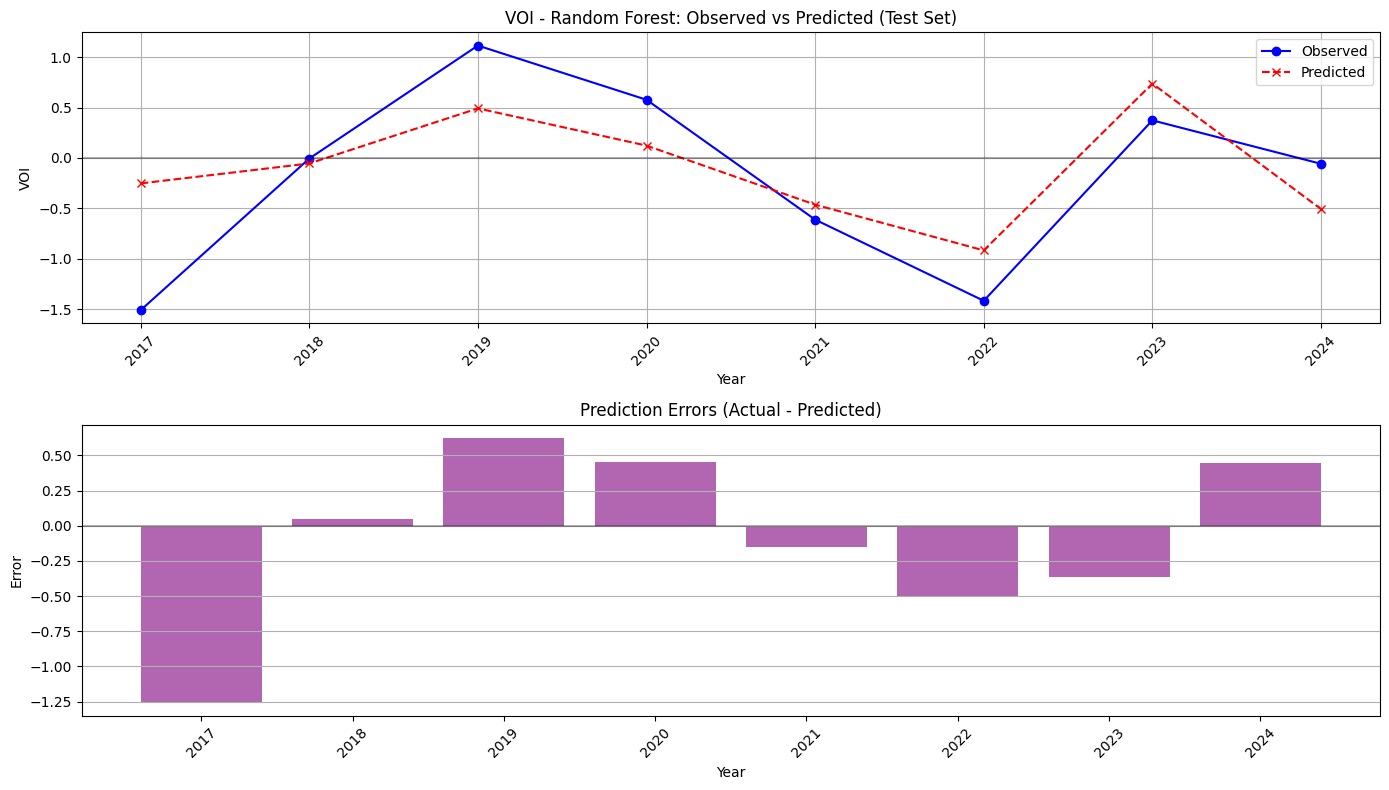

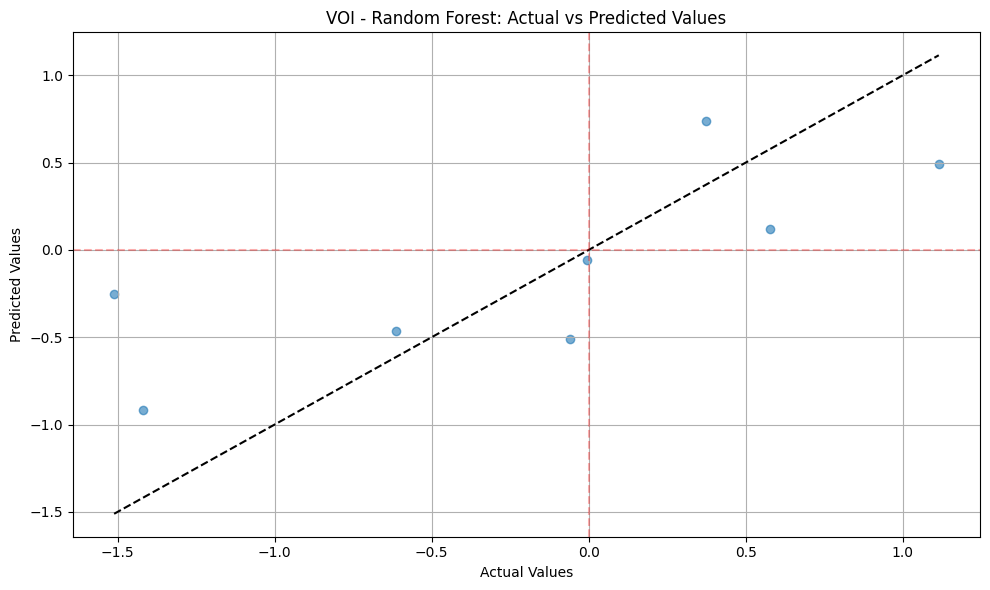


Working with VOI data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for VOI: ['N34', 'rolling_mean_3yr', 'IODW', 'rolling_std_3yr', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for VOI - Gradient Boosting: [0.08776473306610366, 0.10030466706294205, -0.1390613419796709, -0.16821612606644587, -0.2921572107688657]
Average CV R²: -0.082
  RMSE for values below zero: 0.639
  Number of below-zero actual values in test set: 5

Results for VOI using Gradient Boosting:
  Train R² = 0.500, RMSE = 0.682
  Validation R² = 0.038, RMSE = 0.833
  Test R² = 0.472, RMSE = 0.634, MAE = 0.550


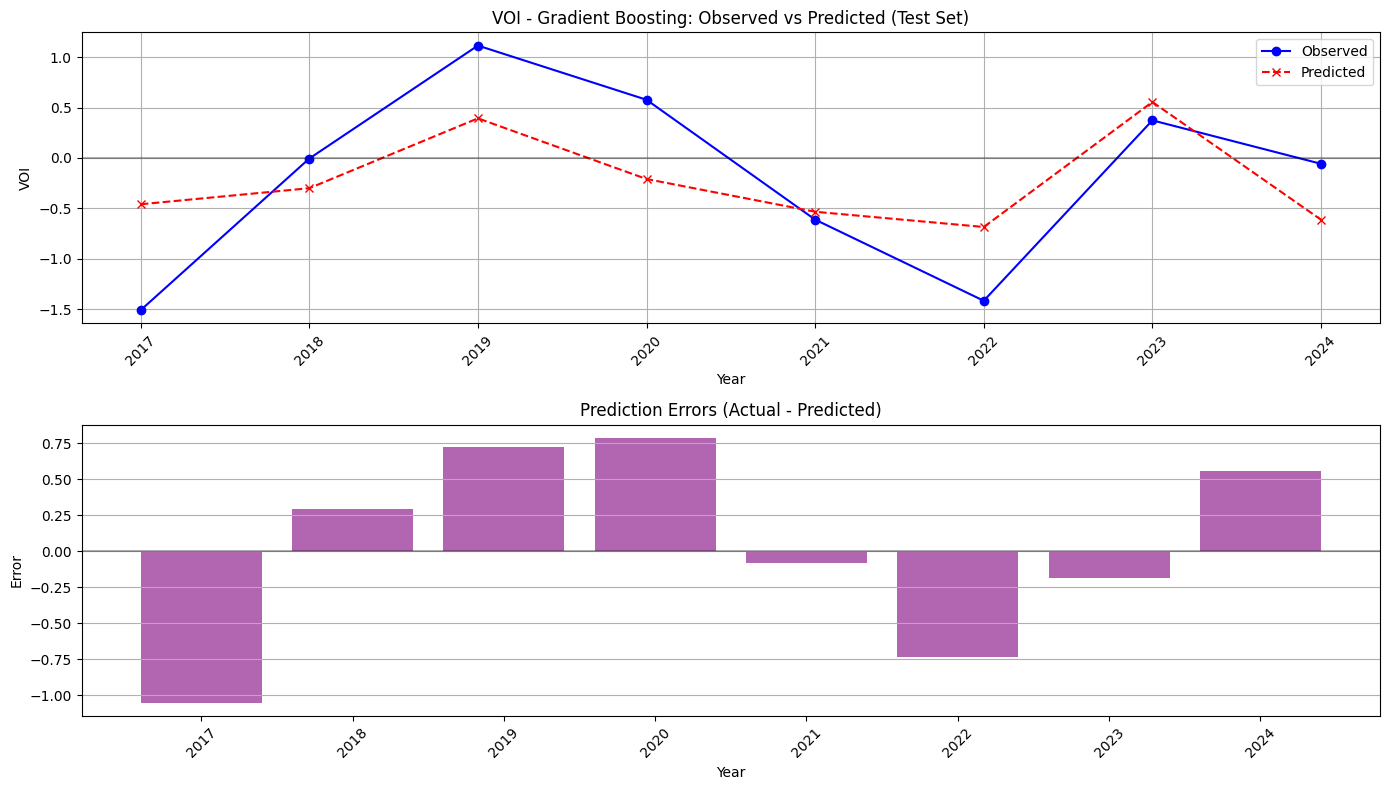

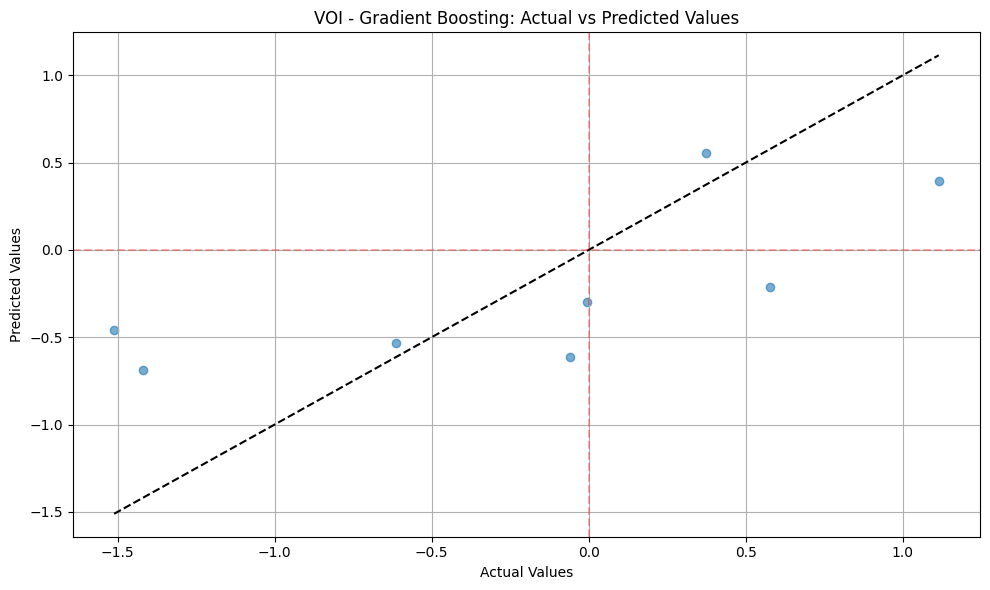


Working with VOI data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for VOI: ['N34', 'rolling_mean_3yr', 'IODW', 'rolling_std_3yr', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for VOI - SVR: [0.009069226608005132, -0.044635707299035765, -0.3680903634003414, -0.940772396570605, -0.3378761067913858]
Average CV R²: -0.336
  RMSE for values below zero: 0.696
  Number of below-zero actual values in test set: 5

Results for VOI using SVR:
  Train R² = 0.401, RMSE = 0.747
  Validation R² = 0.008, RMSE = 0.846
  Test R² = 0.447, RMSE = 0.649, MAE = 0.578


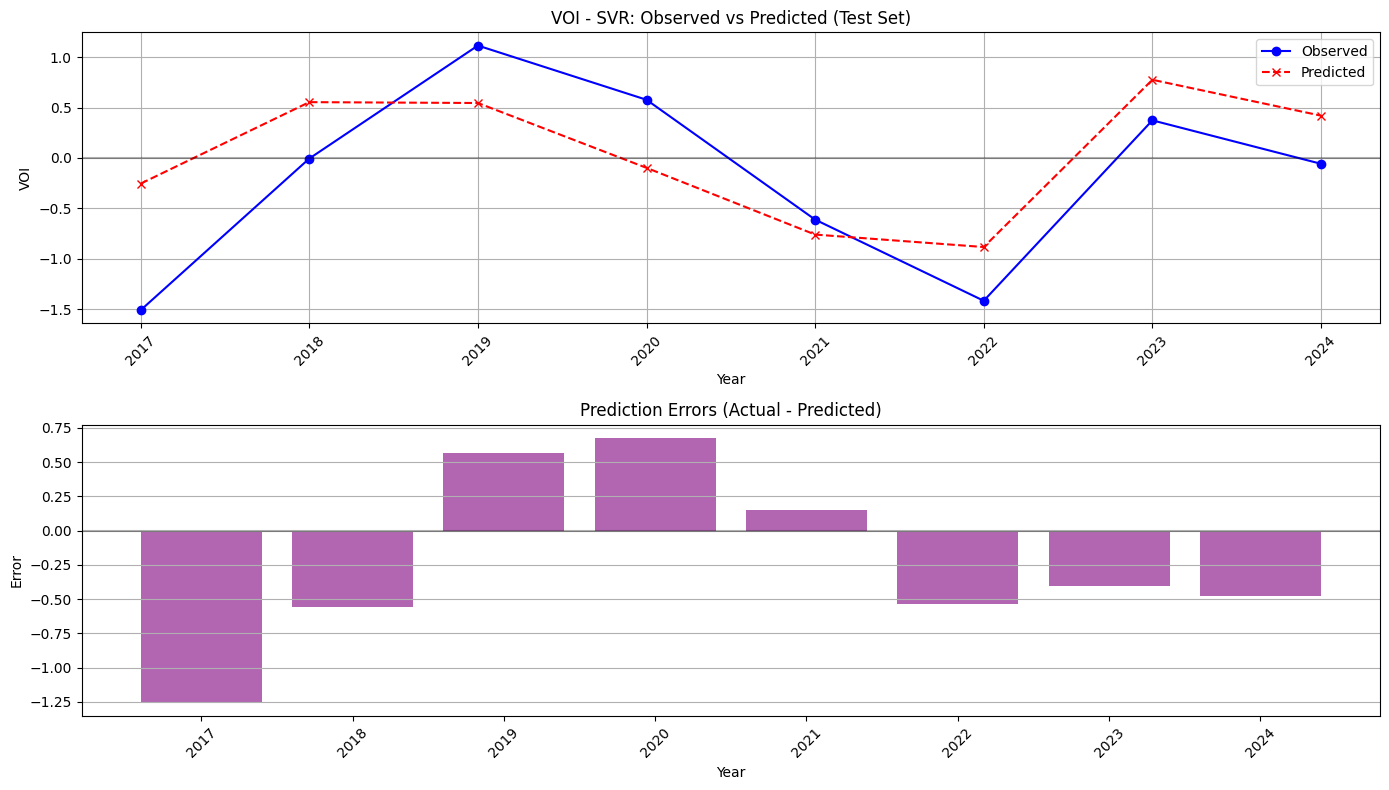

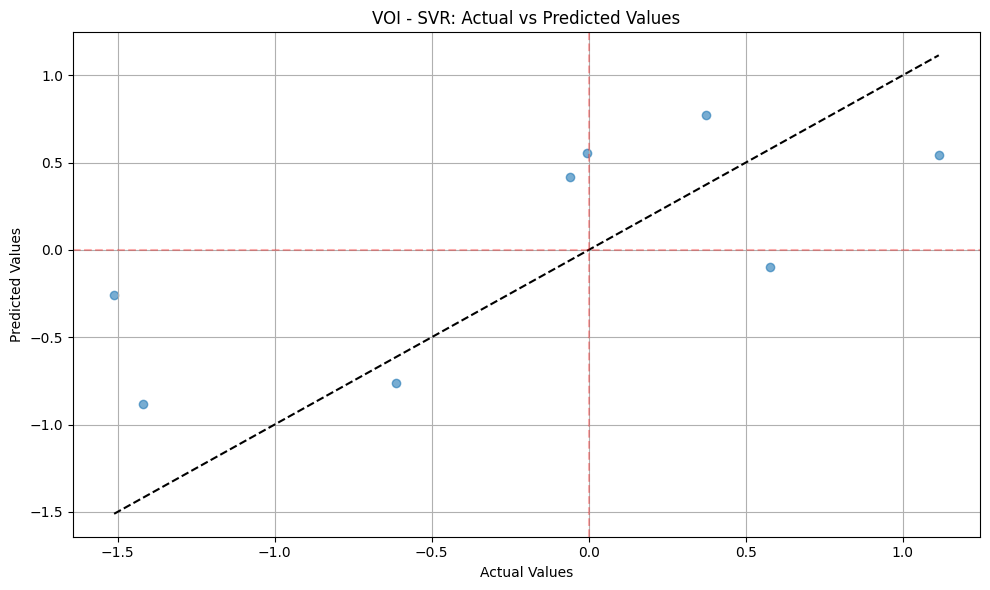


Working with VOI data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for VOI: ['N34', 'rolling_mean_3yr', 'IODW', 'rolling_std_3yr', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for VOI - Neural Network: [-0.5925579160259071, -0.09487679637530189, 0.09934912702630161, -0.16534596163102688, 0.011303114481983623]
Average CV R²: -0.148
  RMSE for values below zero: 0.853
  Number of below-zero actual values in test set: 5

Results for VOI using Neural Network:
  Train R² = 0.148, RMSE = 0.891
  Validation R² = -0.051, RMSE = 0.871
  Test R² = 0.189, RMSE = 0.786, MAE = 0.582


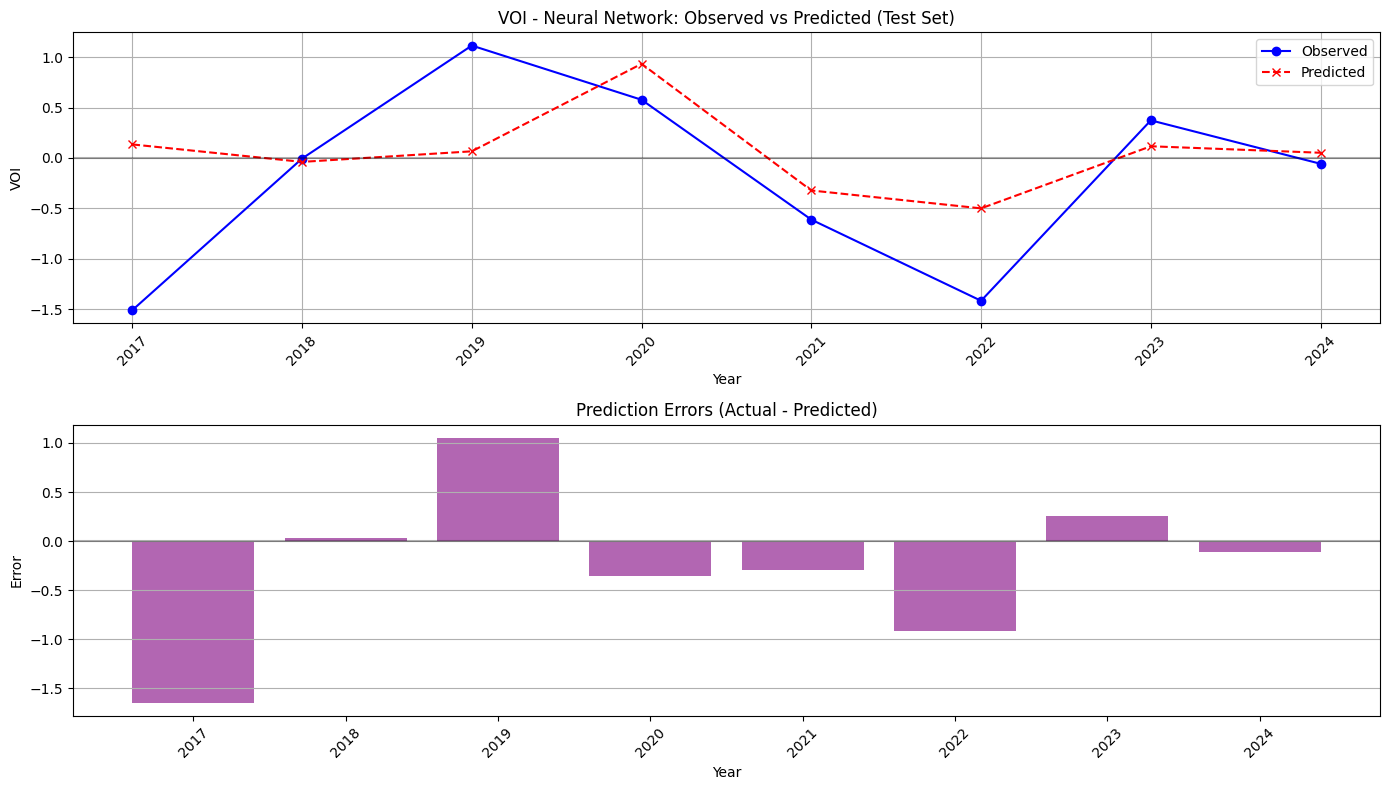

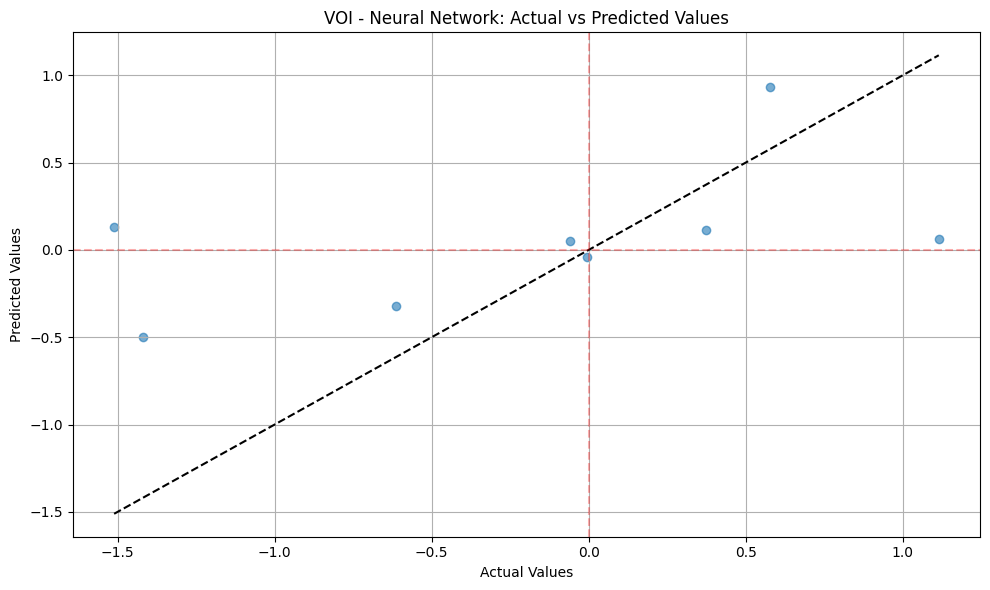


Working with MOYALE data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOYALE: ['IODW', 'IODE', 'rolling_mean_3yr', 'N34', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for MOYALE - Random Forest: [-2.693017186848023, 0.33059214237056667, 0.5340783536933031, 0.09879036614221026, -0.0020265419169758214]
Average CV R²: -0.346
  RMSE for values below zero: 0.344
  Number of below-zero actual values in test set: 6

Results for MOYALE using Random Forest:
  Train R² = 0.667, RMSE = 0.467
  Validation R² = 0.032, RMSE = 0.803
  Test R² = 0.560, RMSE = 0.581, MAE = 0.446


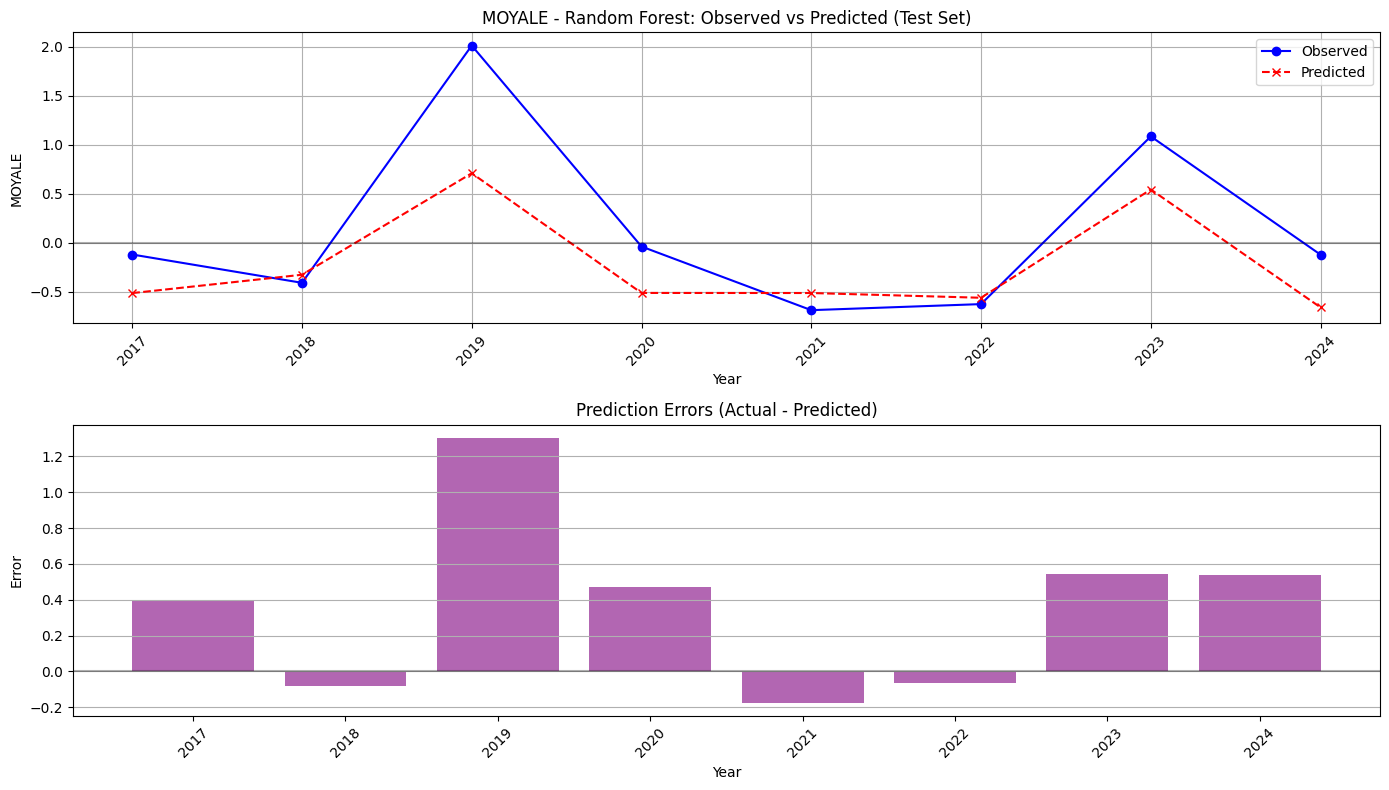

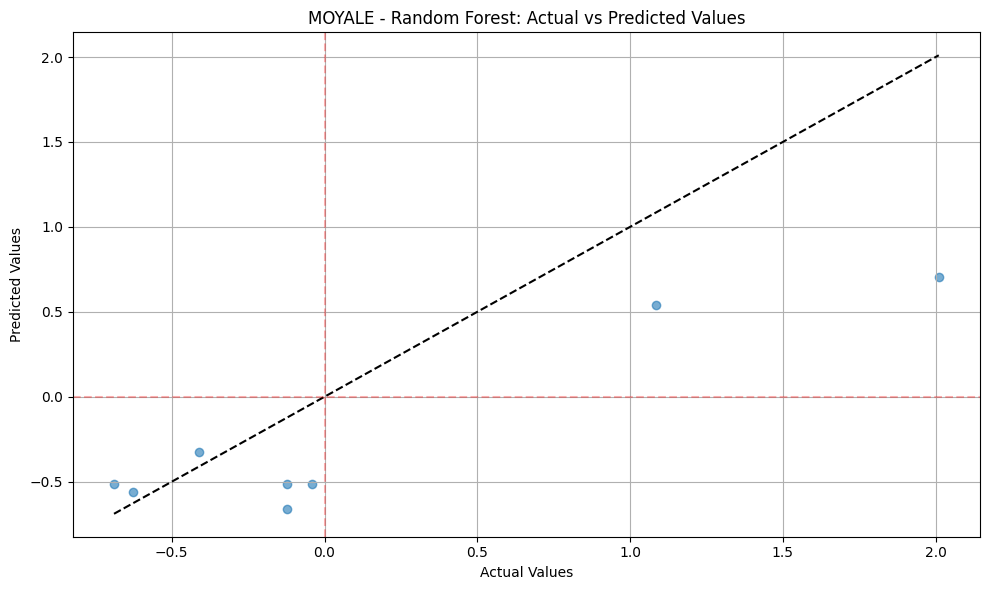


Working with MOYALE data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOYALE: ['IODW', 'IODE', 'rolling_mean_3yr', 'N34', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for MOYALE - Gradient Boosting: [-0.4771807985593324, 0.1849408006701958, 0.26143100507741346, 0.08131669602274694, 0.13705860402969727]
Average CV R²: 0.038
  RMSE for values below zero: 0.313
  Number of below-zero actual values in test set: 6

Results for MOYALE using Gradient Boosting:
  Train R² = 0.518, RMSE = 0.562
  Validation R² = 0.055, RMSE = 0.793
  Test R² = 0.229, RMSE = 0.769, MAE = 0.574


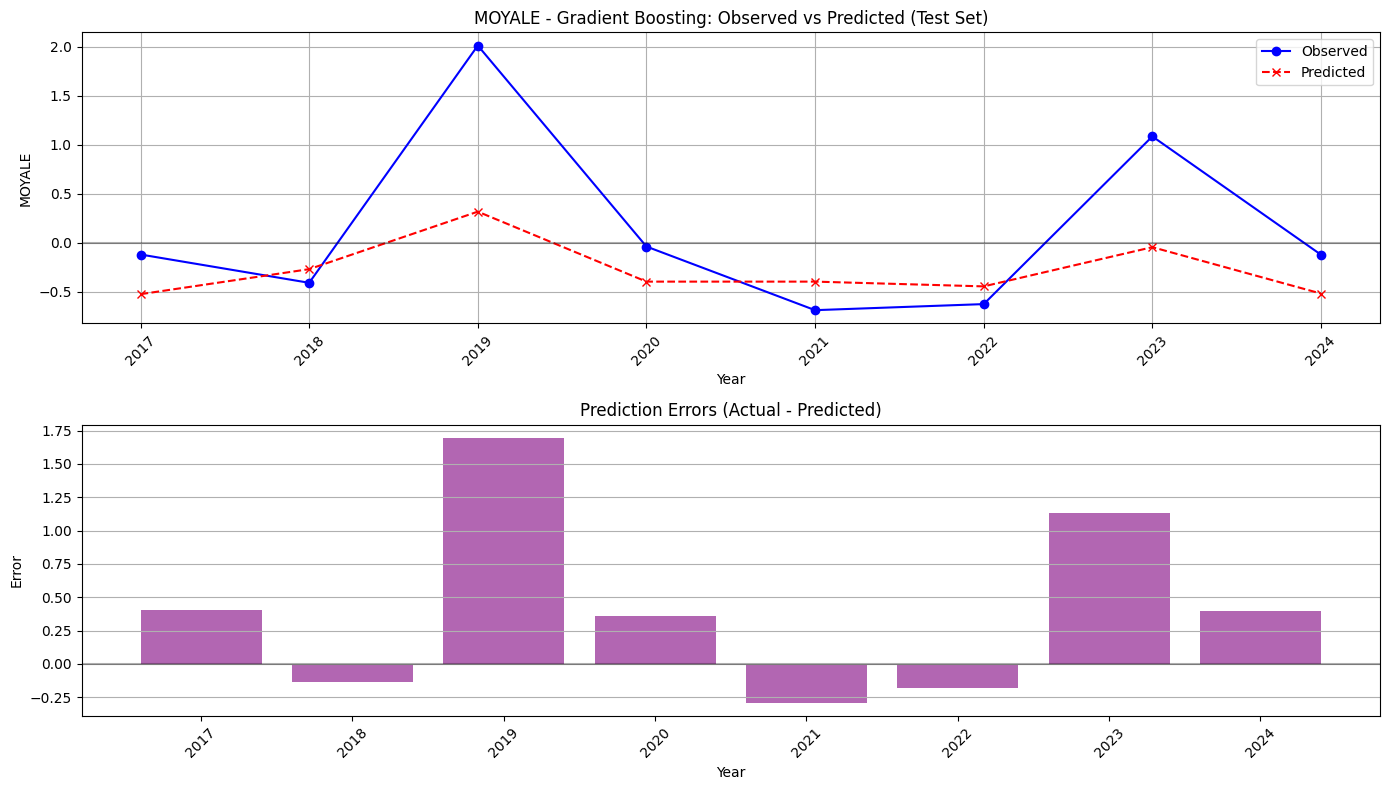

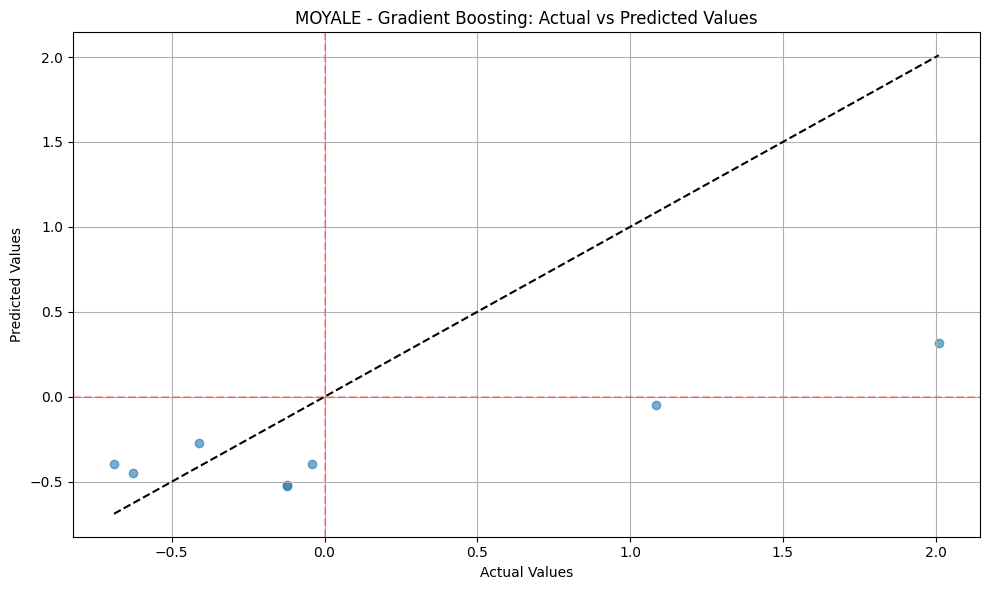


Working with MOYALE data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOYALE: ['IODW', 'IODE', 'rolling_mean_3yr', 'N34', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for MOYALE - SVR: [-0.4957257655298246, 0.1272304545116113, 0.3471766833094244, -0.14749556497736016, 0.01305822885625152]
Average CV R²: -0.031
  RMSE for values below zero: 0.325
  Number of below-zero actual values in test set: 6

Results for MOYALE using SVR:
  Train R² = 0.518, RMSE = 0.561
  Validation R² = -0.115, RMSE = 0.861
  Test R² = 0.029, RMSE = 0.863, MAE = 0.553


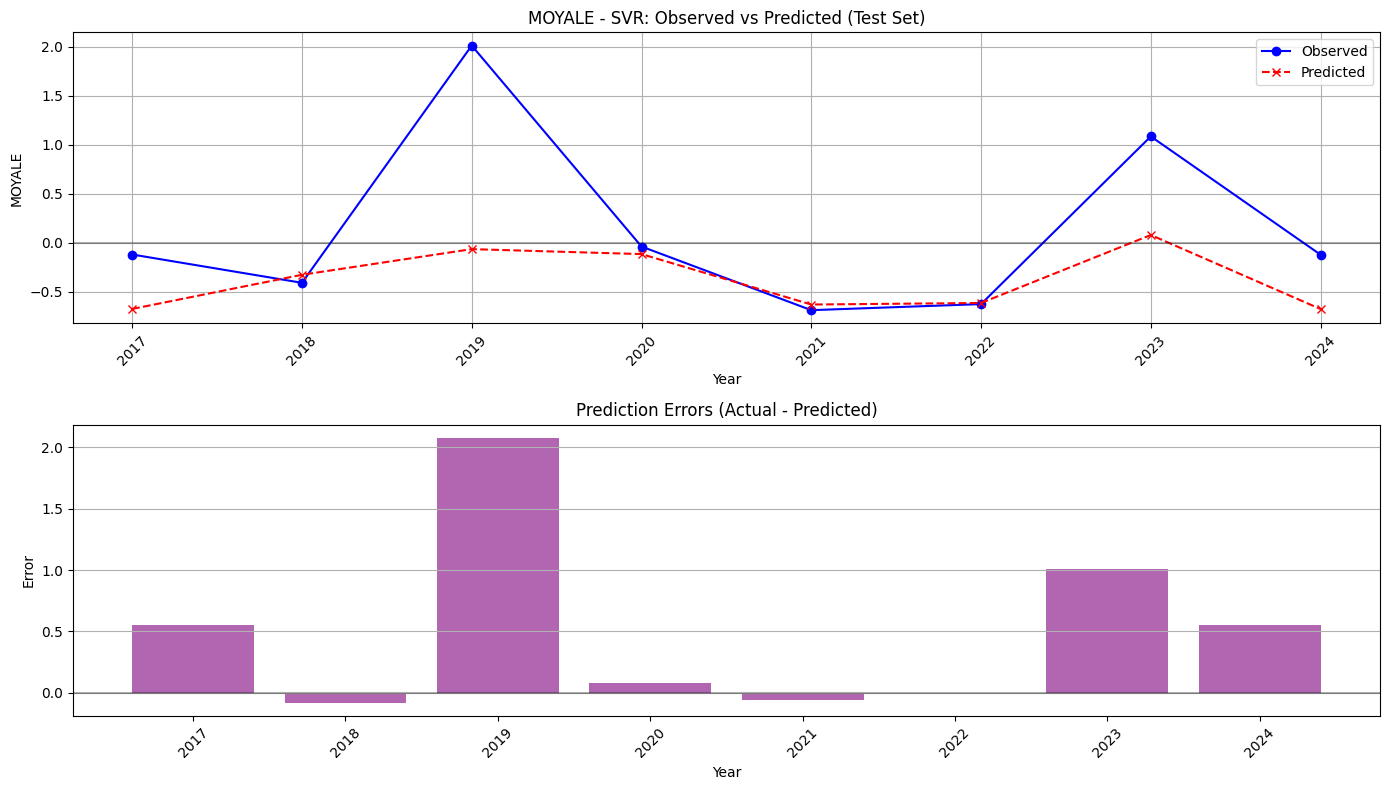

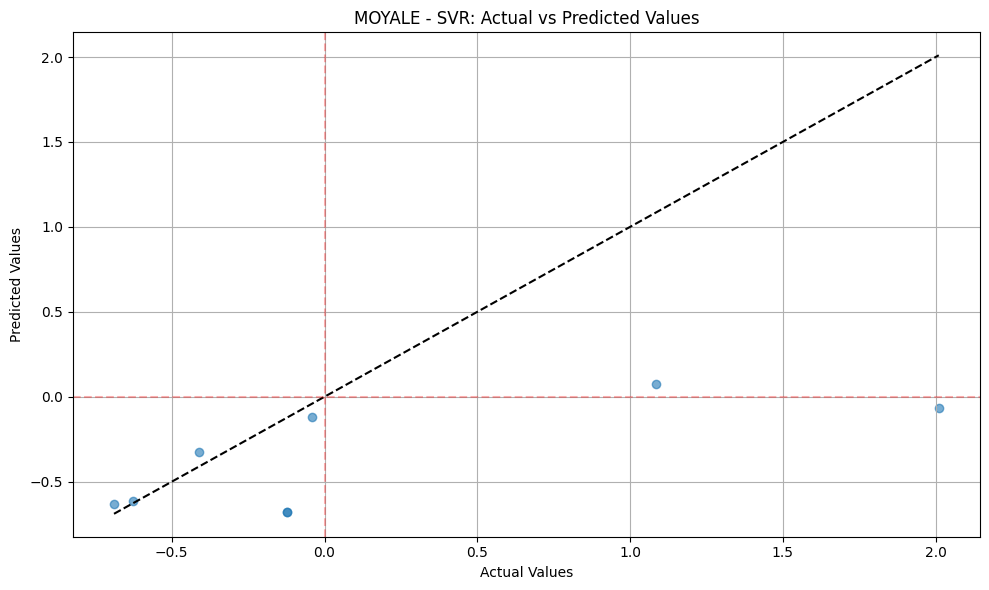


Working with MOYALE data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOYALE: ['IODW', 'IODE', 'rolling_mean_3yr', 'N34', 'N4', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for MOYALE - Neural Network: [-0.4938638462460132, 0.2395319475757004, 0.4243930579262354, 0.03585347924762716, -0.08082650952777137]
Average CV R²: 0.025
  RMSE for values below zero: 0.345
  Number of below-zero actual values in test set: 6

Results for MOYALE using Neural Network:
  Train R² = 0.084, RMSE = 0.774
  Validation R² = -0.144, RMSE = 0.872
  Test R² = -0.019, RMSE = 0.884, MAE = 0.643


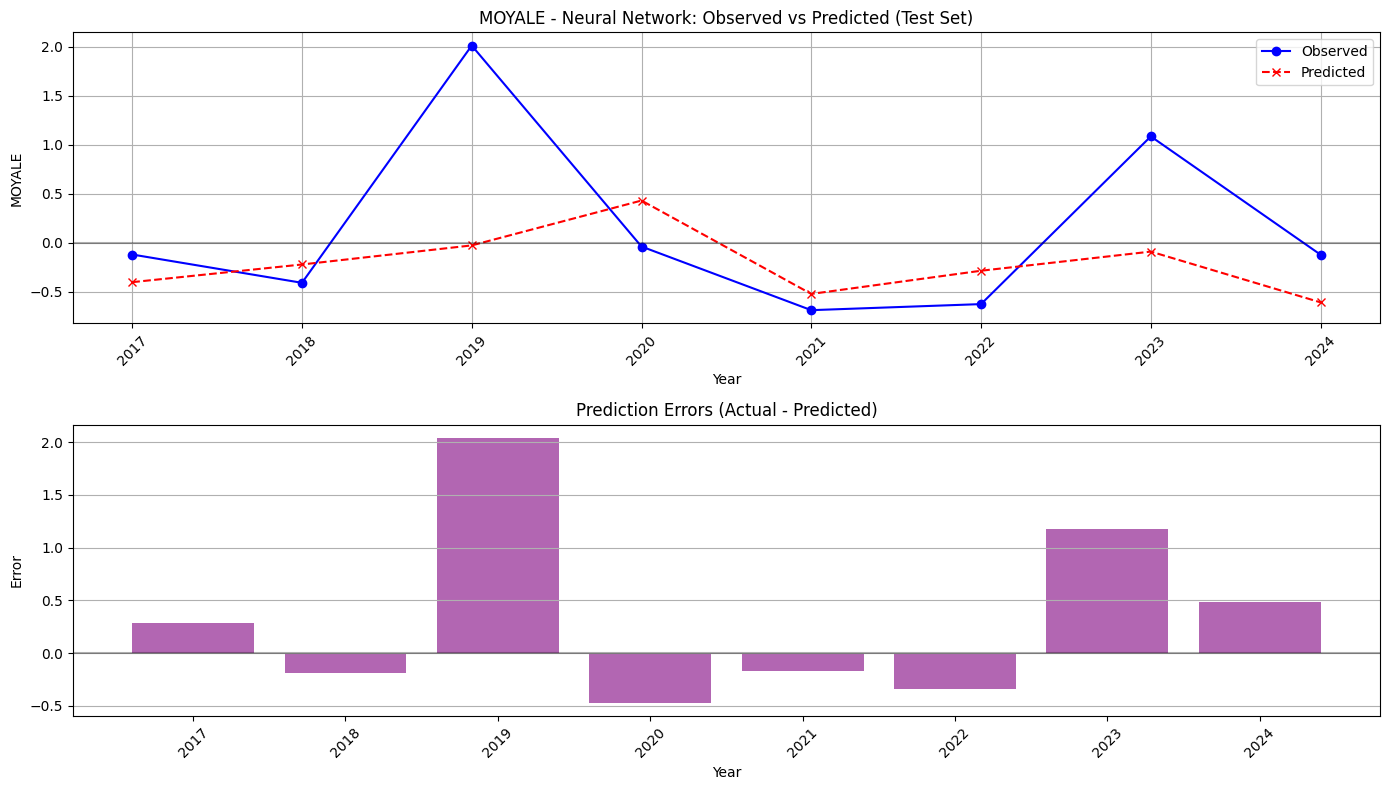

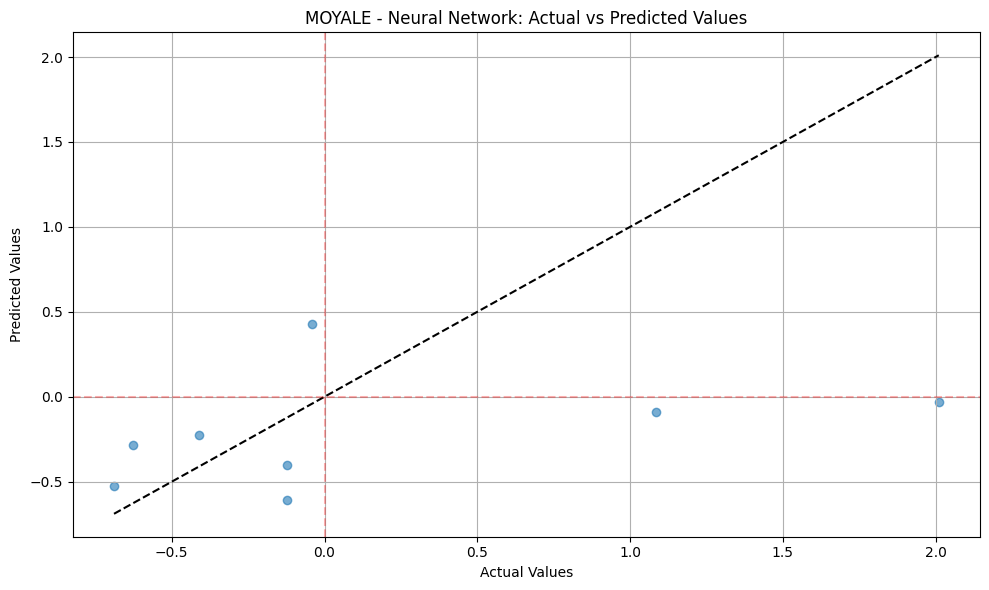


Working with LODWAR data from 1950 to 2024
Total data points: 75
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LODWAR: ['IODW', 'IODE', 'rolling_mean_3yr', 'rolling_std_3yr', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LODWAR - Random Forest: [-6.0457718294685625, 0.25163657247265814, 0.2602225247738822, -5.362641242338623, 0.3993685104480077]
Average CV R²: -2.099
  RMSE for values below zero: 0.312
  Number of below-zero actual values in test set: 4

Results for LODWAR using Random Forest:
  Train R² = 0.582, RMSE = 0.702
  Validation R² = -0.306, RMSE = 1.290
  Test R² = 0.479, RMSE = 0.582, MAE = 0.477


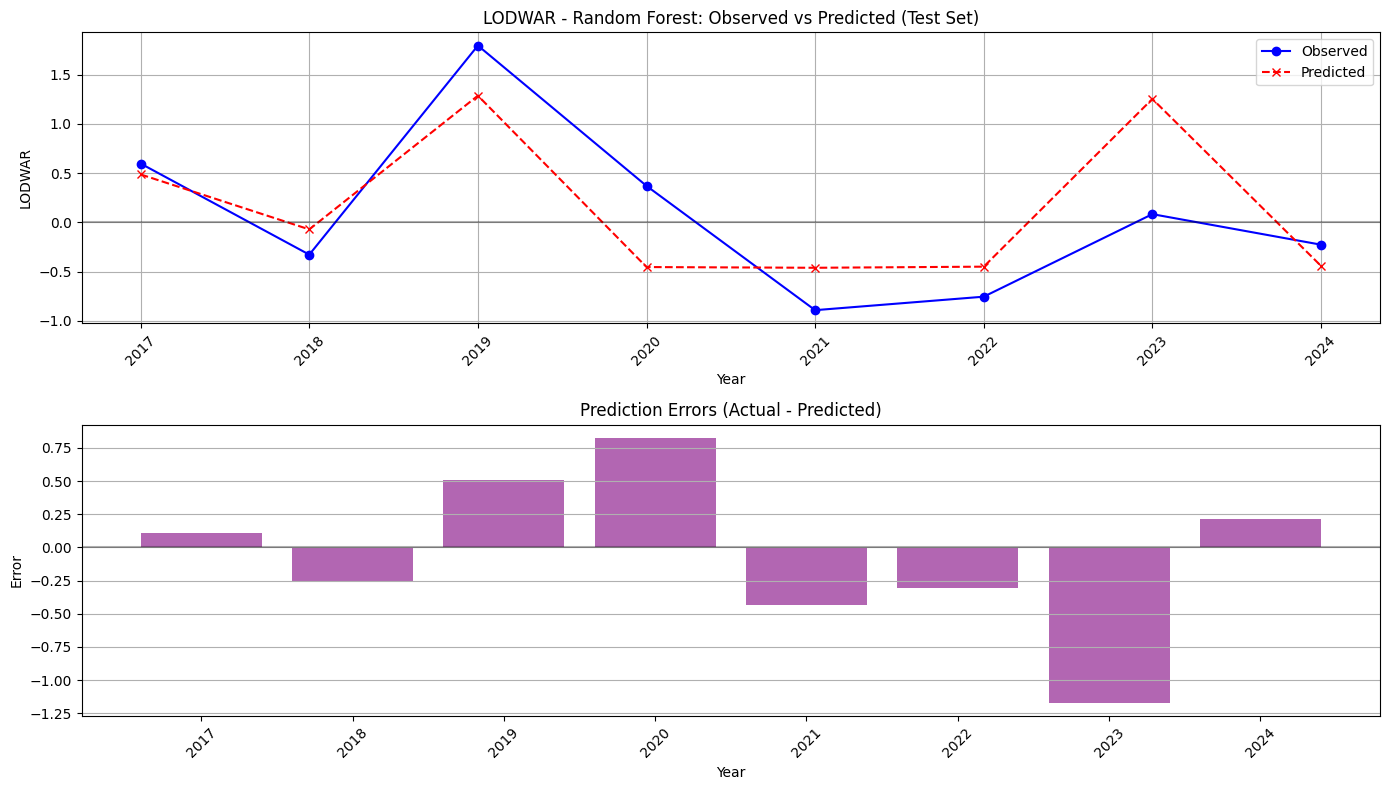

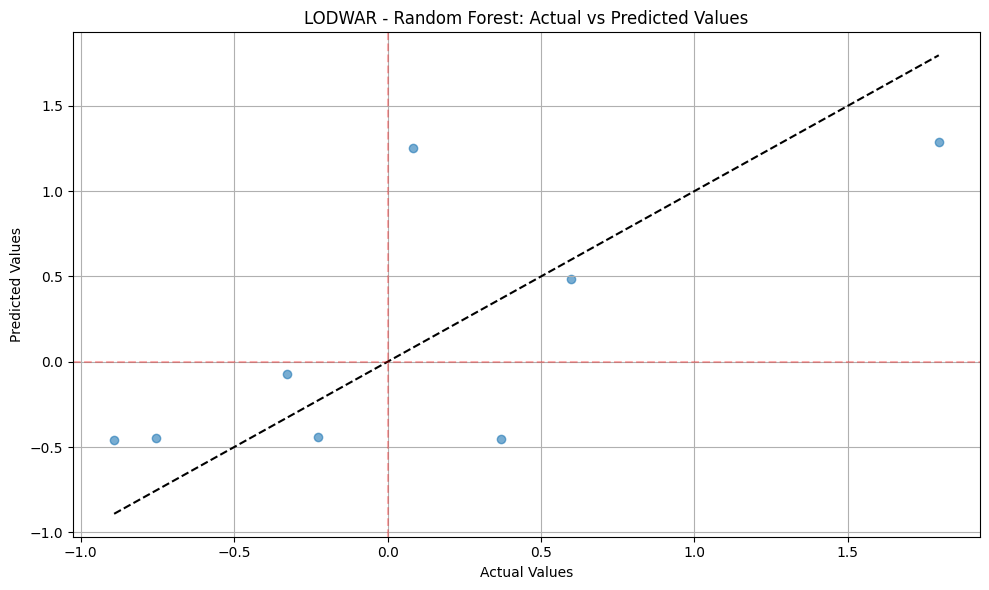


Working with LODWAR data from 1950 to 2024
Total data points: 75
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LODWAR: ['IODW', 'IODE', 'rolling_mean_3yr', 'rolling_std_3yr', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LODWAR - Gradient Boosting: [-2.1266759727323854, 0.03945551323242169, 0.1137732107763969, -1.7660113626953482, 0.3373978317892222]
Average CV R²: -0.680
  RMSE for values below zero: 0.269
  Number of below-zero actual values in test set: 4

Results for LODWAR using Gradient Boosting:
  Train R² = 0.398, RMSE = 0.843
  Validation R² = -0.416, RMSE = 1.343
  Test R² = 0.058, RMSE = 0.782, MAE = 0.571


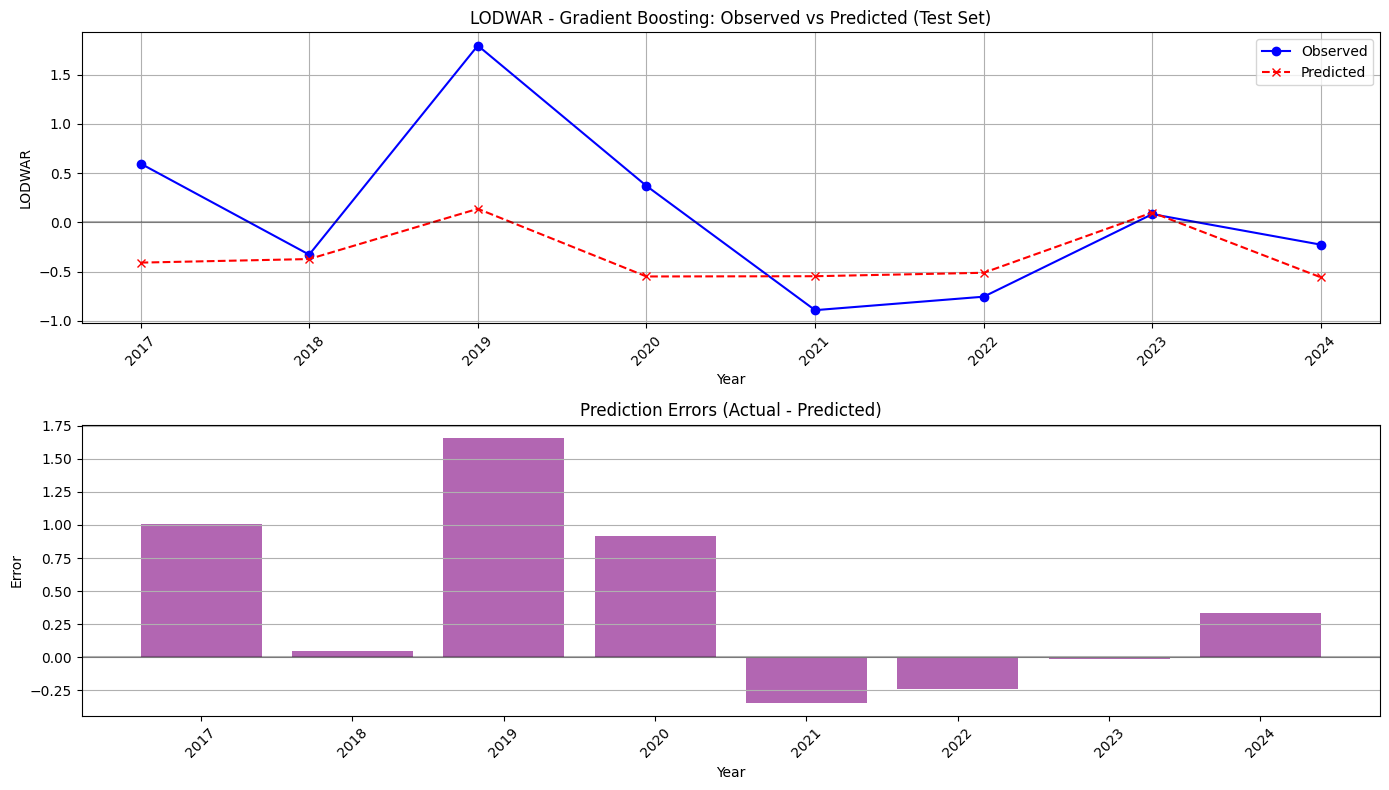

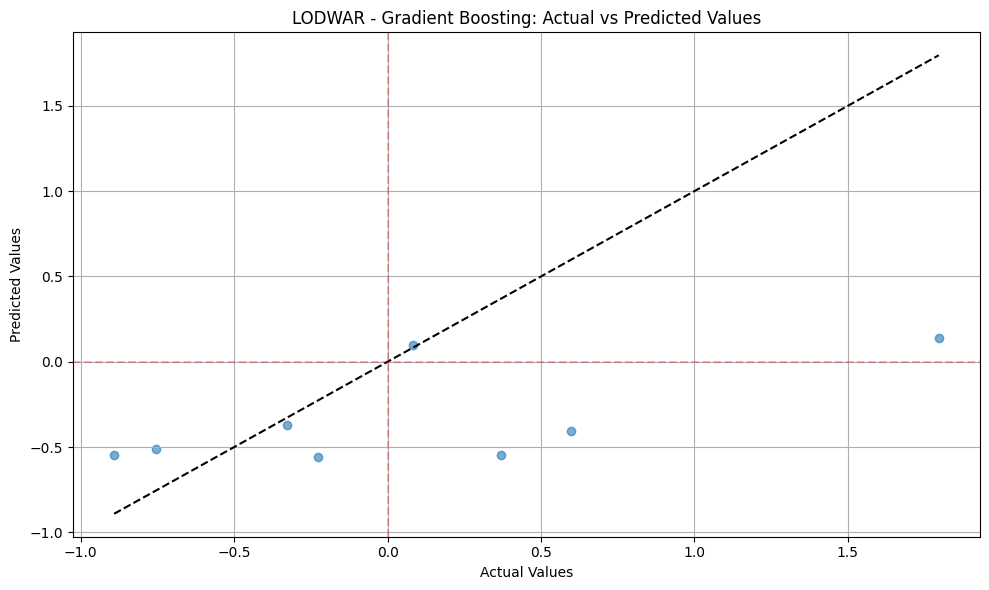


Working with LODWAR data from 1950 to 2024
Total data points: 75
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LODWAR: ['IODW', 'IODE', 'rolling_mean_3yr', 'rolling_std_3yr', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LODWAR - SVR: [-2.8452685500803043, 0.0915062402992105, 0.23405257478606267, -0.5556878300011934, 0.41804701643987685]
Average CV R²: -0.531
  RMSE for values below zero: 0.255
  Number of below-zero actual values in test set: 4

Results for LODWAR using SVR:
  Train R² = 0.468, RMSE = 0.792
  Validation R² = -0.631, RMSE = 1.442
  Test R² = 0.093, RMSE = 0.768, MAE = 0.523


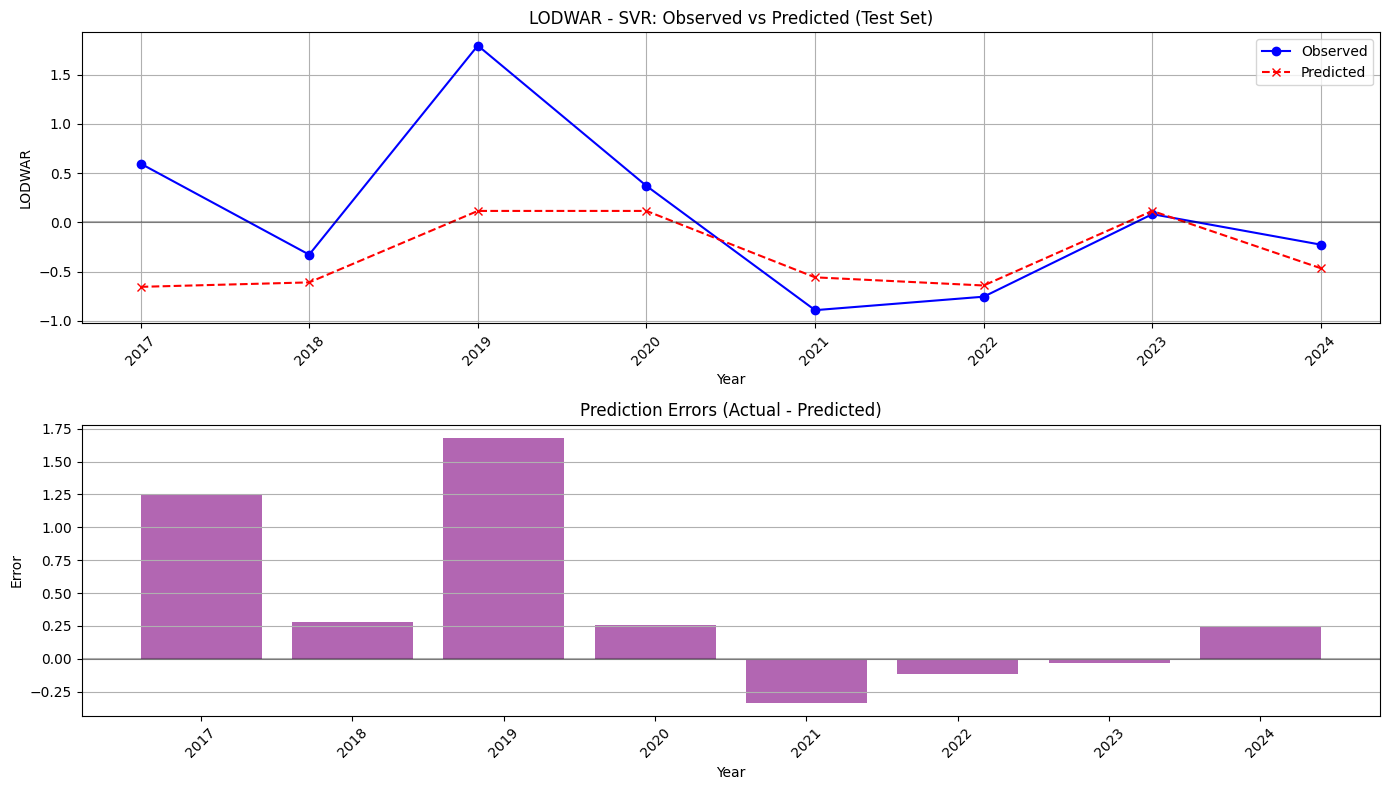

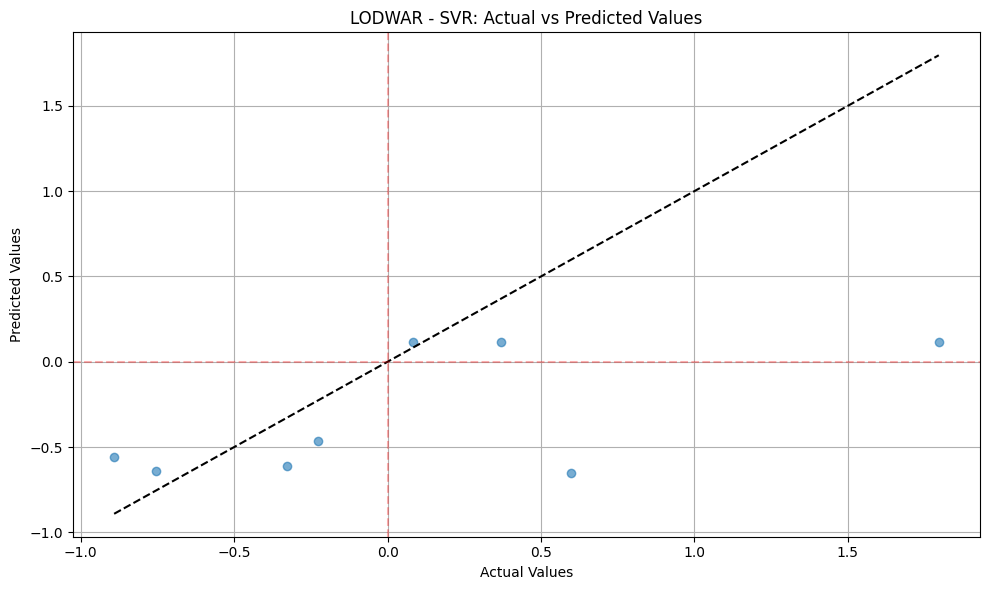


Working with LODWAR data from 1950 to 2024
Total data points: 75
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LODWAR: ['IODW', 'IODE', 'rolling_mean_3yr', 'rolling_std_3yr', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LODWAR - Neural Network: [-3.6268337908260024, 0.2570859506900345, 0.5273047103061025, -1.2310939763248503, 0.13241349106408296]
Average CV R²: -0.788
  RMSE for values below zero: 0.214
  Number of below-zero actual values in test set: 4

Results for LODWAR using Neural Network:
  Train R² = 0.650, RMSE = 0.642
  Validation R² = -2.594, RMSE = 2.140
  Test R² = -16.988, RMSE = 3.418, MAE = 2.153


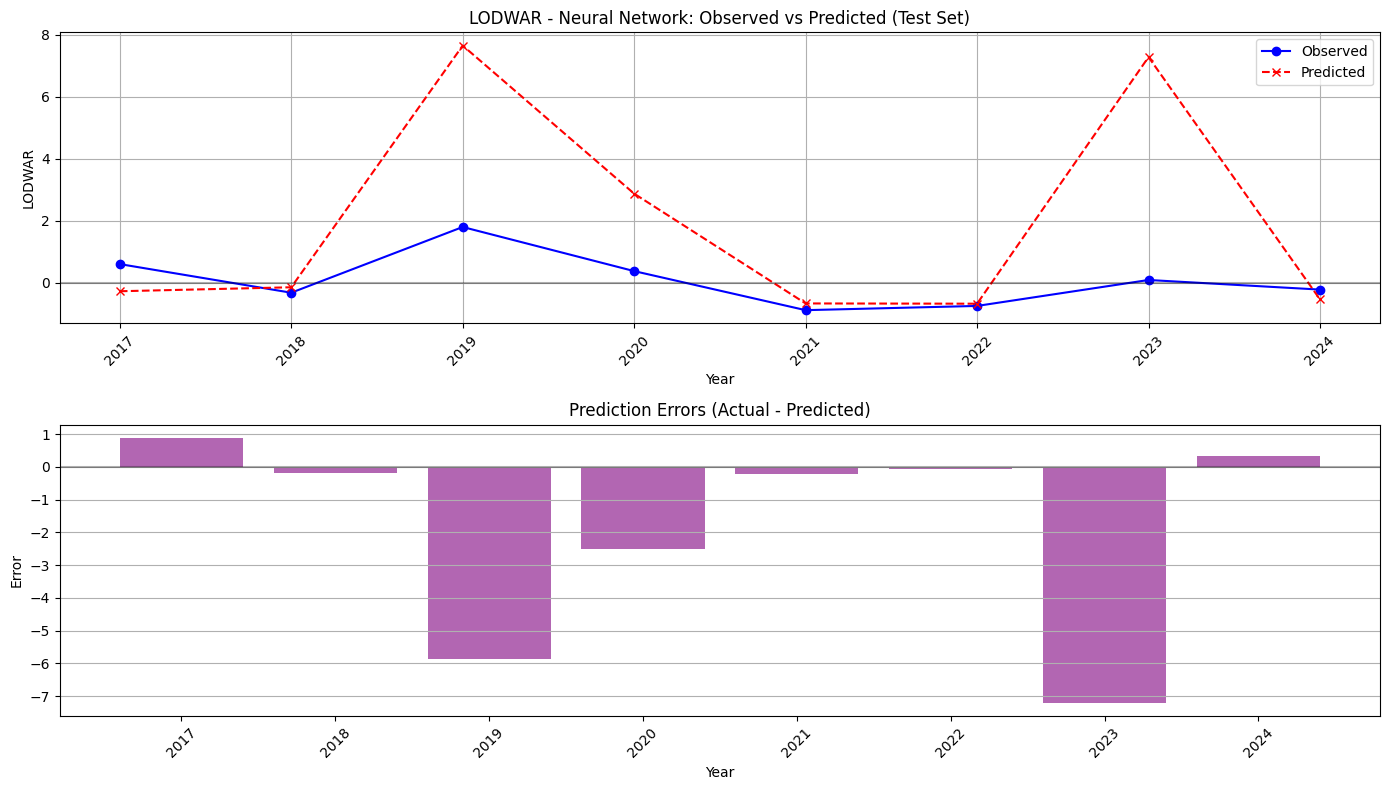

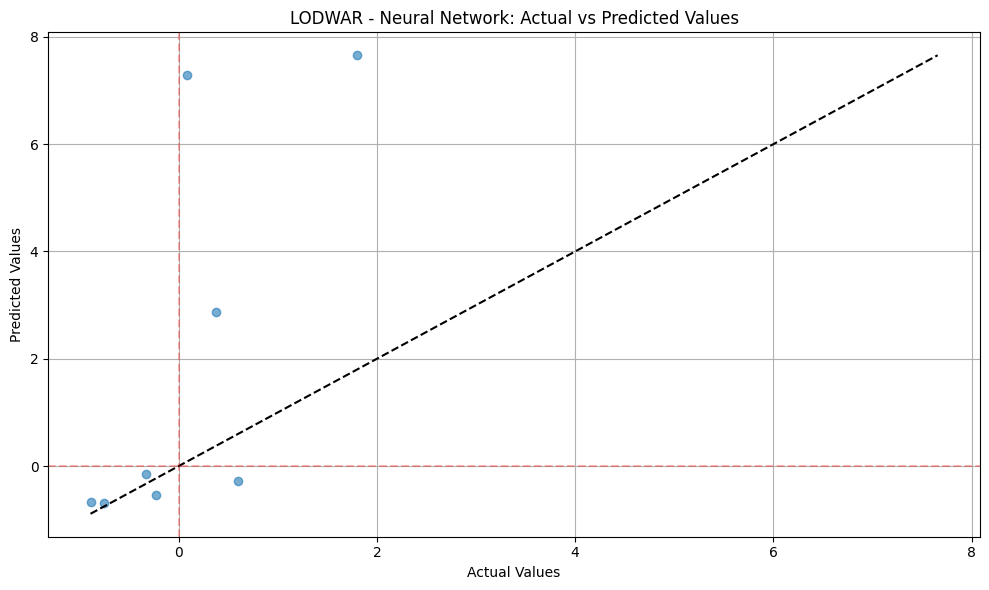


Working with LAMU data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LAMU: ['IODW', 'N34', 'N4', 'rolling_mean_3yr', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LAMU - Random Forest: [0.022965018542284388, 0.12622941383282515, 0.5146177282015287, -0.9721711546087666, -1.1520588577881568]
Average CV R²: -0.292
  RMSE for values below zero: 0.658
  Number of below-zero actual values in test set: 6

Results for LAMU using Random Forest:
  Train R² = 0.563, RMSE = 0.807
  Validation R² = -0.032, RMSE = 1.165
  Test R² = 0.575, RMSE = 1.064, MAE = 0.827


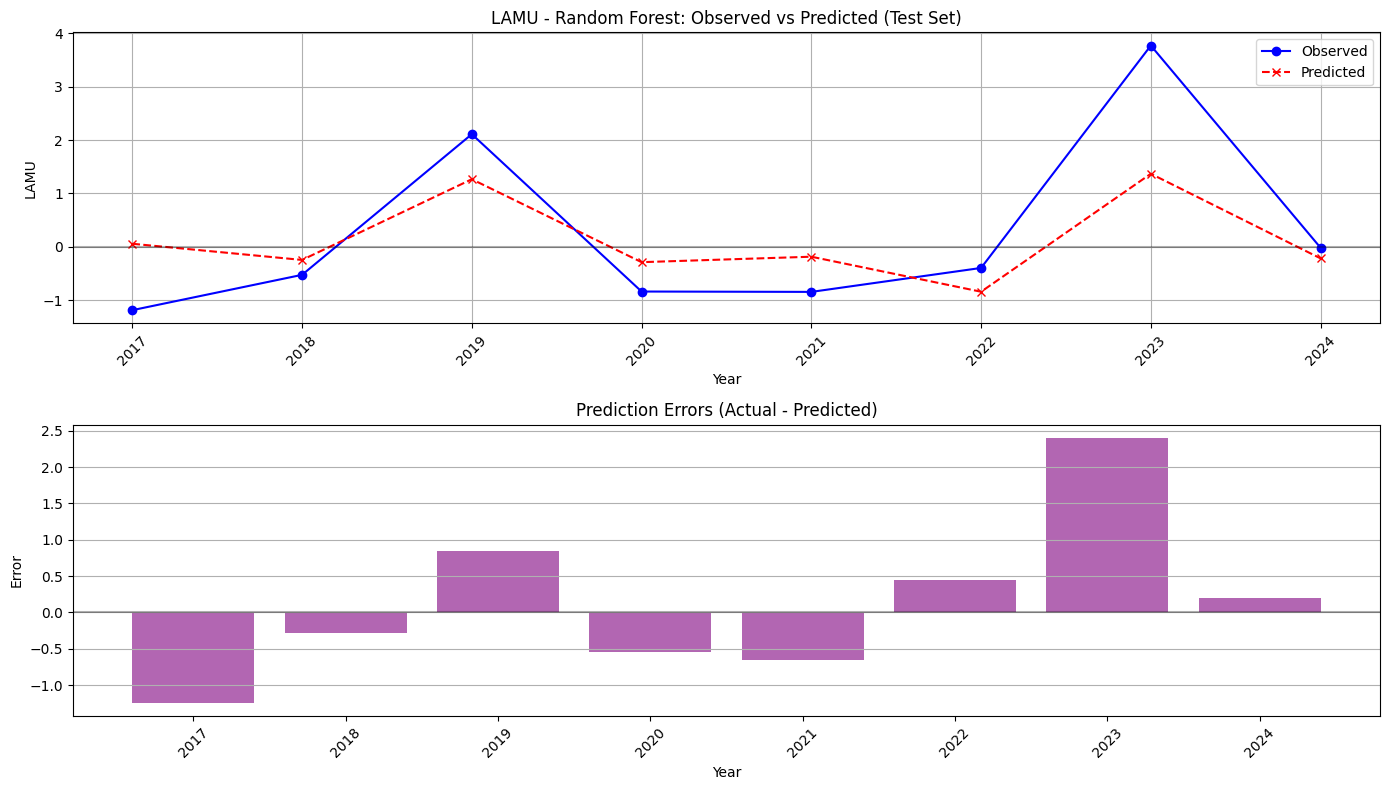

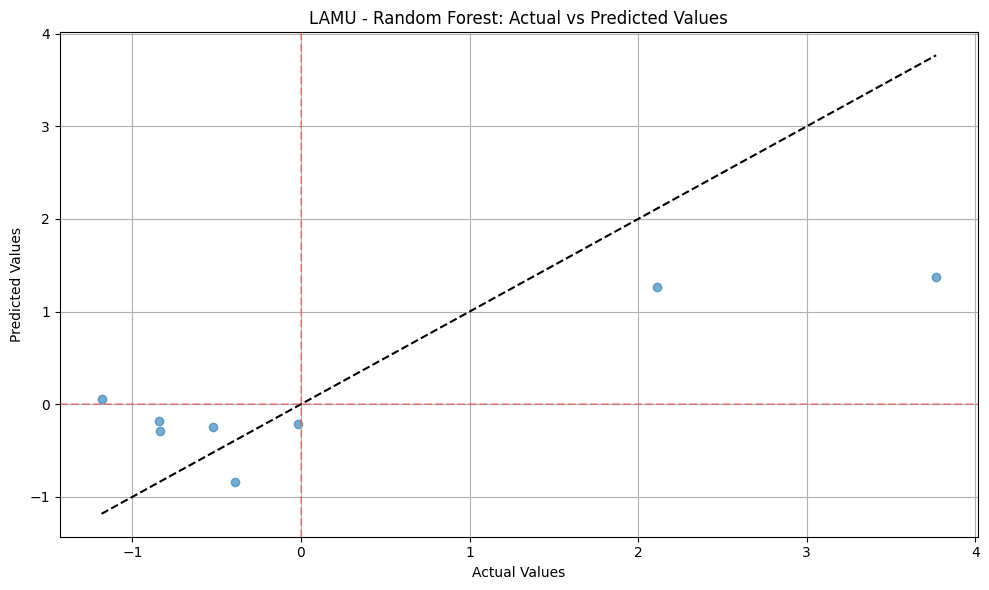


Working with LAMU data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LAMU: ['IODW', 'N34', 'N4', 'rolling_mean_3yr', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LAMU - Gradient Boosting: [-0.1008076228693553, 0.03797054310873005, 0.1557405379550474, -0.15395904423863493, -0.3074310113811358]
Average CV R²: -0.074
  RMSE for values below zero: 0.441
  Number of below-zero actual values in test set: 6

Results for LAMU using Gradient Boosting:
  Train R² = 0.370, RMSE = 0.969
  Validation R² = -0.325, RMSE = 1.320
  Test R² = 0.154, RMSE = 1.502, MAE = 0.999


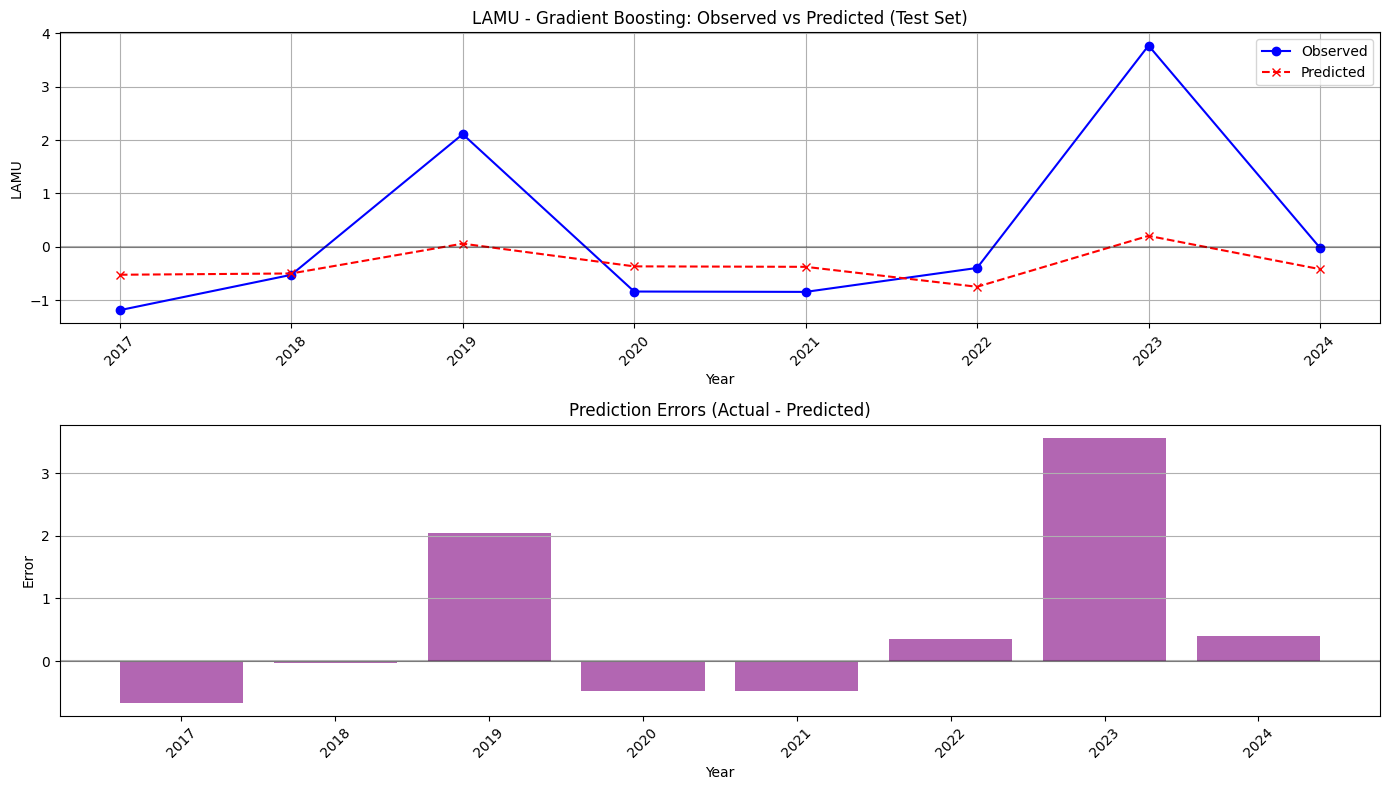

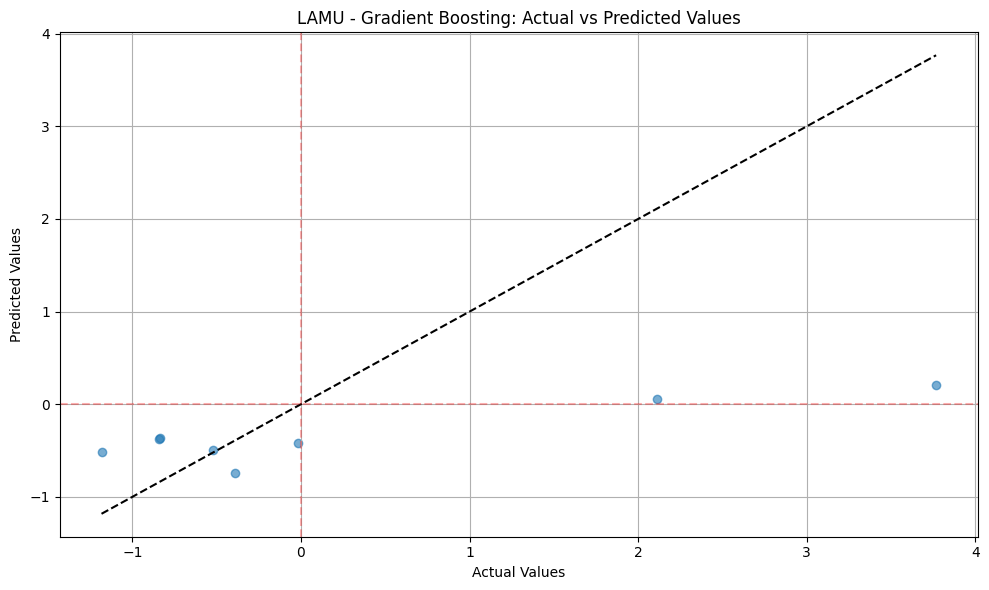


Working with LAMU data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LAMU: ['IODW', 'N34', 'N4', 'rolling_mean_3yr', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LAMU - SVR: [-0.31135205743838235, -0.036148549521794804, 0.26718785321457095, -0.3667235012520247, 0.11540511009896604]
Average CV R²: -0.066
  RMSE for values below zero: 0.755
  Number of below-zero actual values in test set: 6

Results for LAMU using SVR:
  Train R² = 0.293, RMSE = 1.027
  Validation R² = -0.046, RMSE = 1.173
  Test R² = -0.011, RMSE = 1.642, MAE = 1.178


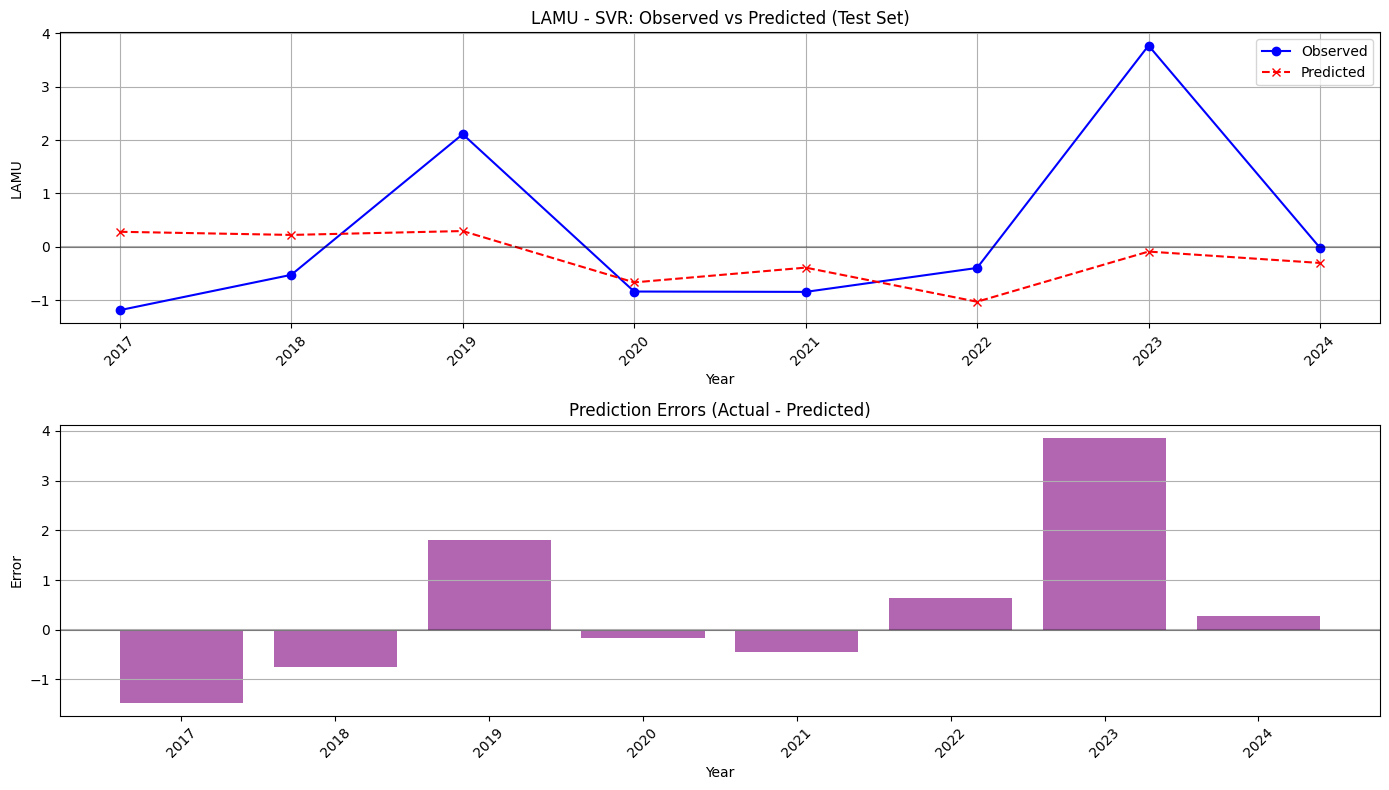

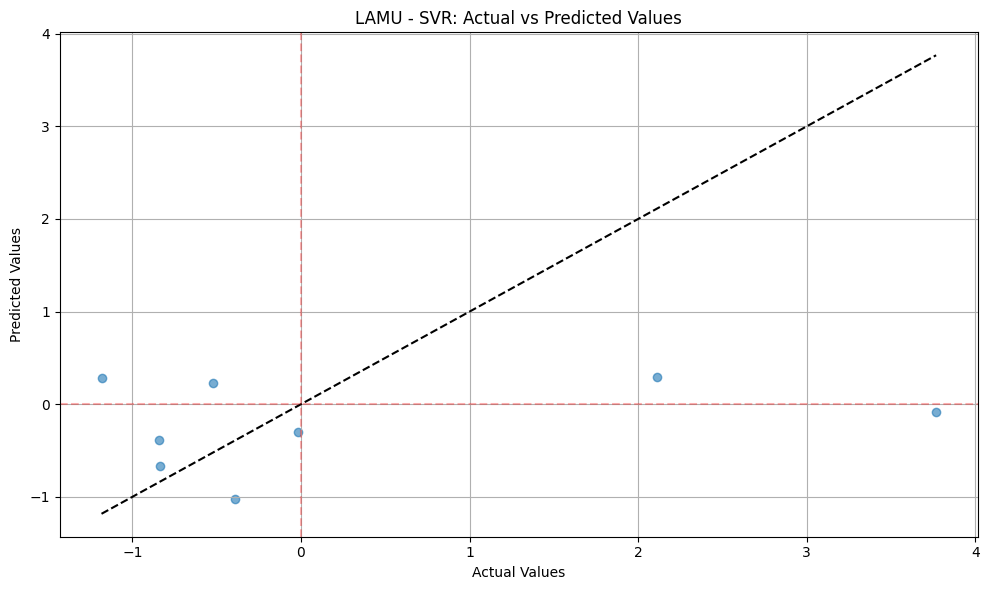


Working with LAMU data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for LAMU: ['IODW', 'N34', 'N4', 'rolling_mean_3yr', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for LAMU - Neural Network: [-0.684307435065848, 0.09491789831530639, -1.0776419197285607, -0.4281826769763213, -0.5568574239695594]
Average CV R²: -0.530
  RMSE for values below zero: 0.612
  Number of below-zero actual values in test set: 6

Results for LAMU using Neural Network:
  Train R² = 0.306, RMSE = 1.017
  Validation R² = -0.135, RMSE = 1.222
  Test R² = 0.302, RMSE = 1.365, MAE = 1.005


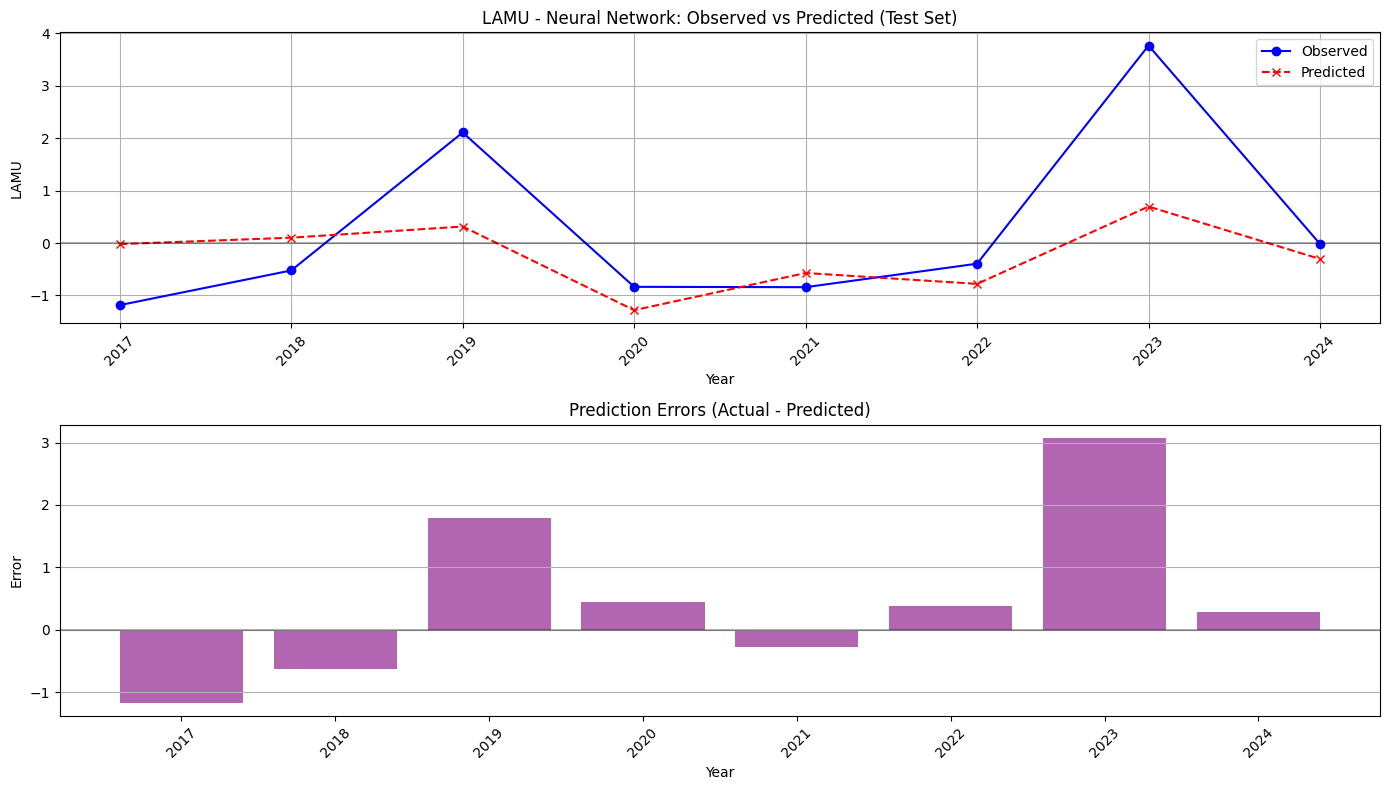

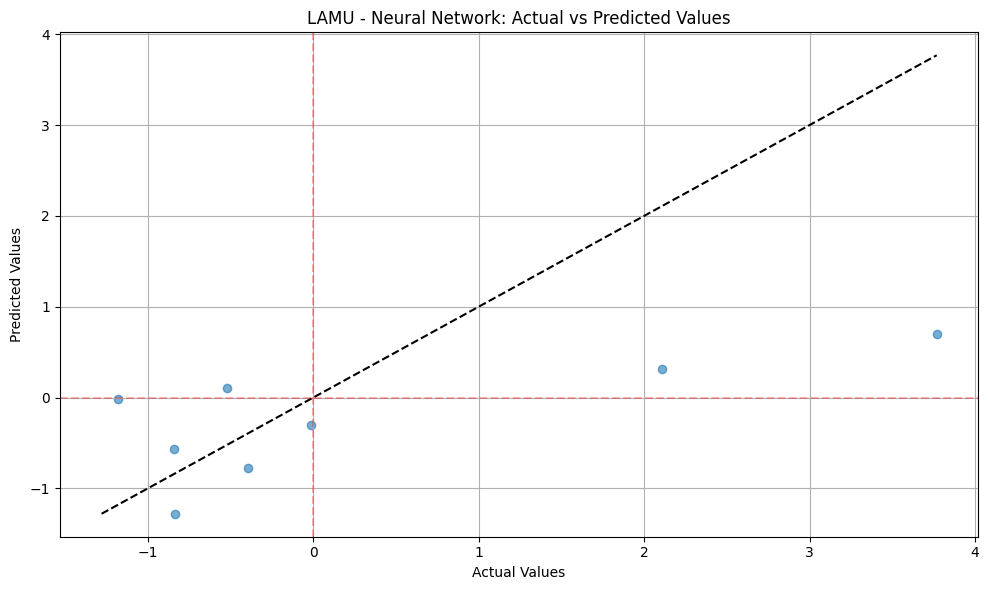


Working with GARISSA data from 1959 to 2023
Total data points: 65
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for GARISSA: ['IODE', 'IODW', 'rolling_mean_3yr', 'rolling_std_3yr', 'is_el_nino', 'la_nina_weight']
Training samples: 48
Validation samples: 9
Testing samples: 8
Training years: 1959 to 2006
Validation years: 2007 to 2015
Testing years: 2016 to 2023
Cross-validation R² scores for GARISSA - Random Forest: [0.06585772960483383, -2.6451797287045054, -0.0020785805712204564, 0.3934472549955964, 0.04001353906901928]
Average CV R²: -0.430
  RMSE for values below zero: 1.066
  Number of below-zero actual values in test set: 5

Results for GARISSA using Random Forest:
  Train R² = 0.594, RMSE = 0.659
  Validation R² = 0.113, RMSE = 0.418
  Test R² = -0.285, RMSE = 1.288, MAE = 0.985


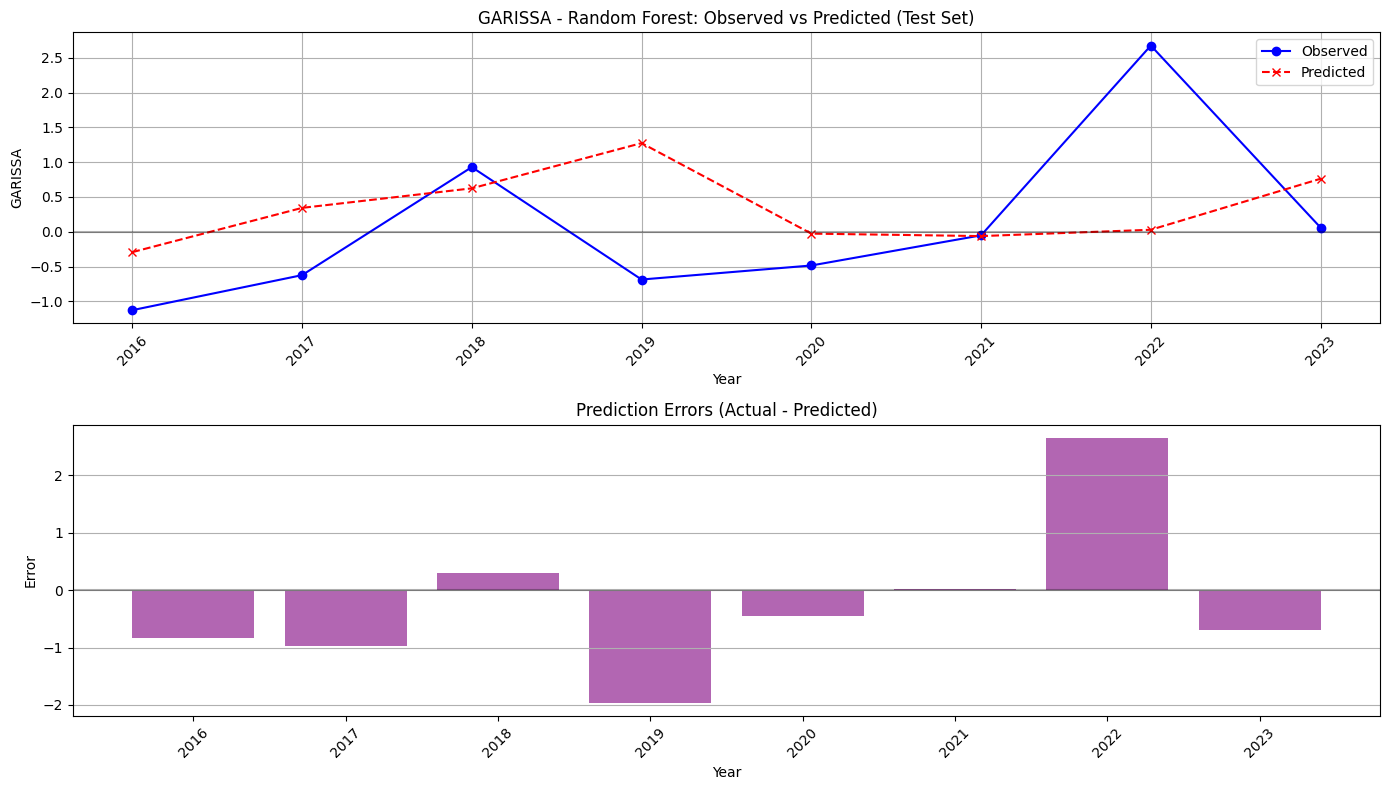

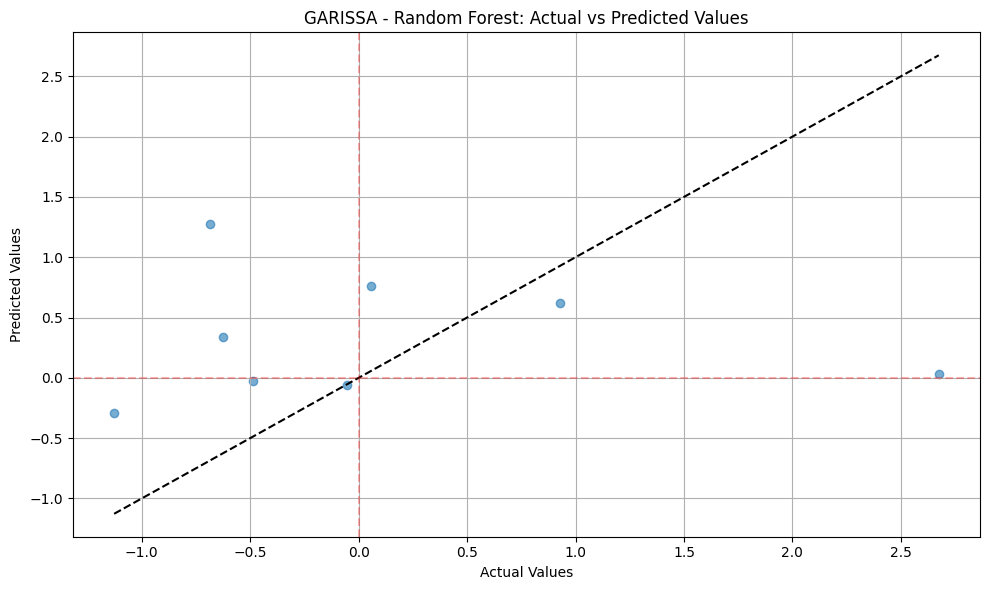


Working with GARISSA data from 1959 to 2023
Total data points: 65
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for GARISSA: ['IODE', 'IODW', 'rolling_mean_3yr', 'rolling_std_3yr', 'is_el_nino', 'la_nina_weight']
Training samples: 48
Validation samples: 9
Testing samples: 8
Training years: 1959 to 2006
Validation years: 2007 to 2015
Testing years: 2016 to 2023
Cross-validation R² scores for GARISSA - Gradient Boosting: [0.07573550517542127, -1.0776388588111963, -0.014496820849267955, 0.09160770681381902, 0.0055167339286892325]
Average CV R²: -0.184
  RMSE for values below zero: 0.859
  Number of below-zero actual values in test set: 5

Results for GARISSA using Gradient Boosting:
  Train R² = 0.491, RMSE = 0.737
  Validation R² = 0.106, RMSE = 0.420
  Test R² = -0.095, RMSE = 1.189, MAE = 0.891


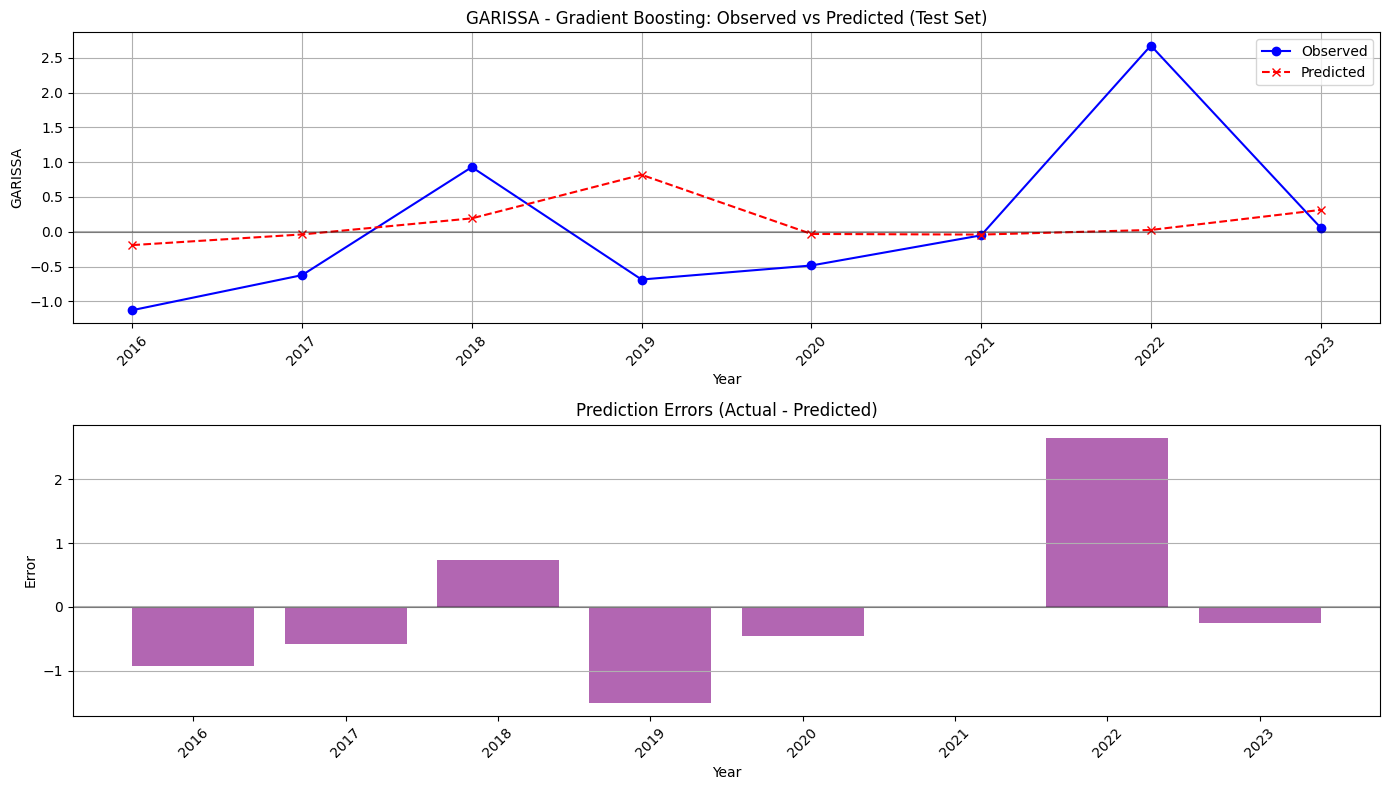

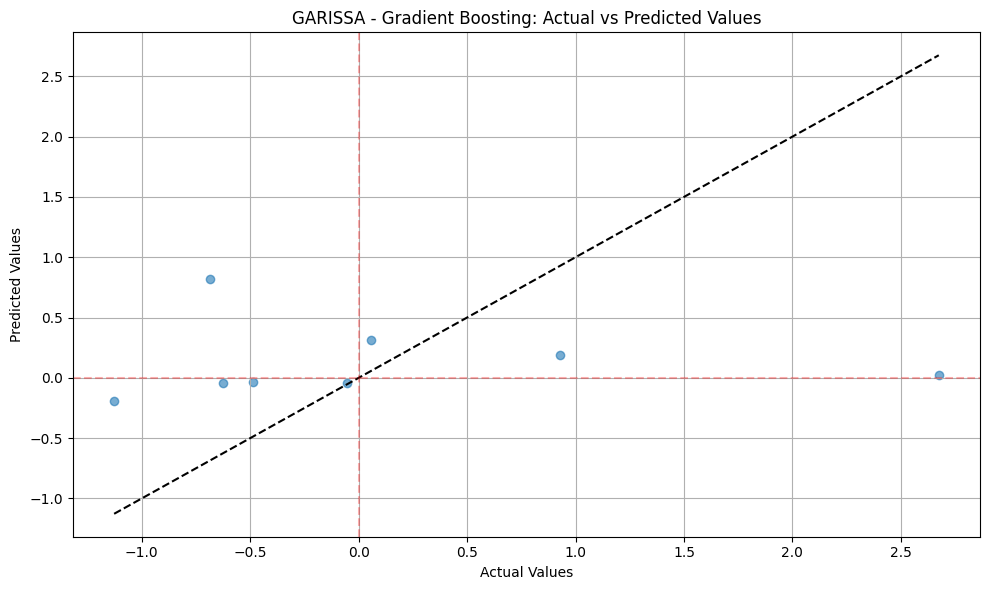


Working with GARISSA data from 1959 to 2023
Total data points: 65
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for GARISSA: ['IODE', 'IODW', 'rolling_mean_3yr', 'rolling_std_3yr', 'is_el_nino', 'la_nina_weight']
Training samples: 48
Validation samples: 9
Testing samples: 8
Training years: 1959 to 2006
Validation years: 2007 to 2015
Testing years: 2016 to 2023
Cross-validation R² scores for GARISSA - SVR: [0.13179893160705658, -1.3093817562385044, 0.04618334807354507, 0.2187661612897538, 0.2893226595805777]
Average CV R²: -0.125
  RMSE for values below zero: 1.309
  Number of below-zero actual values in test set: 5

Results for GARISSA using SVR:
  Train R² = 0.533, RMSE = 0.707
  Validation R² = -1.485, RMSE = 0.700
  Test R² = -0.670, RMSE = 1.468, MAE = 1.216


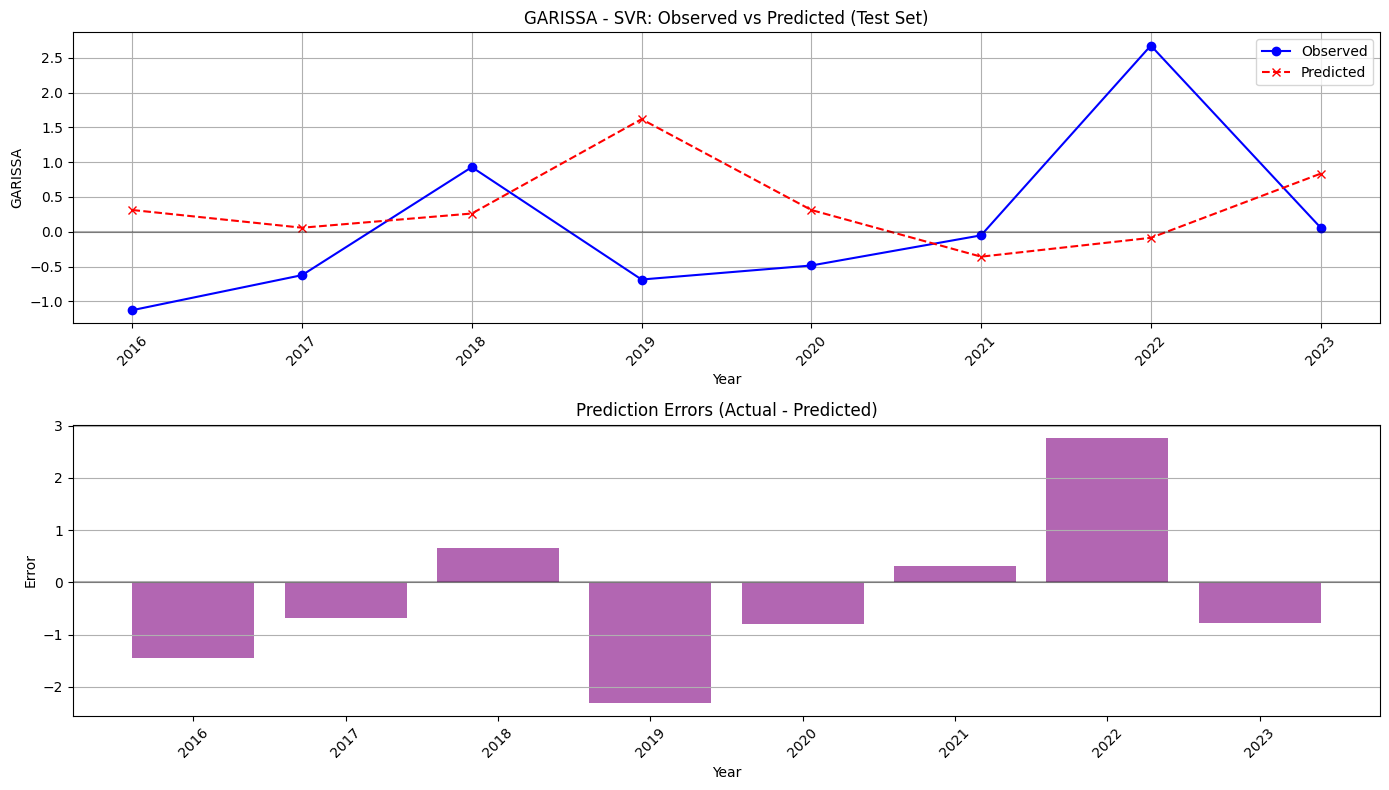

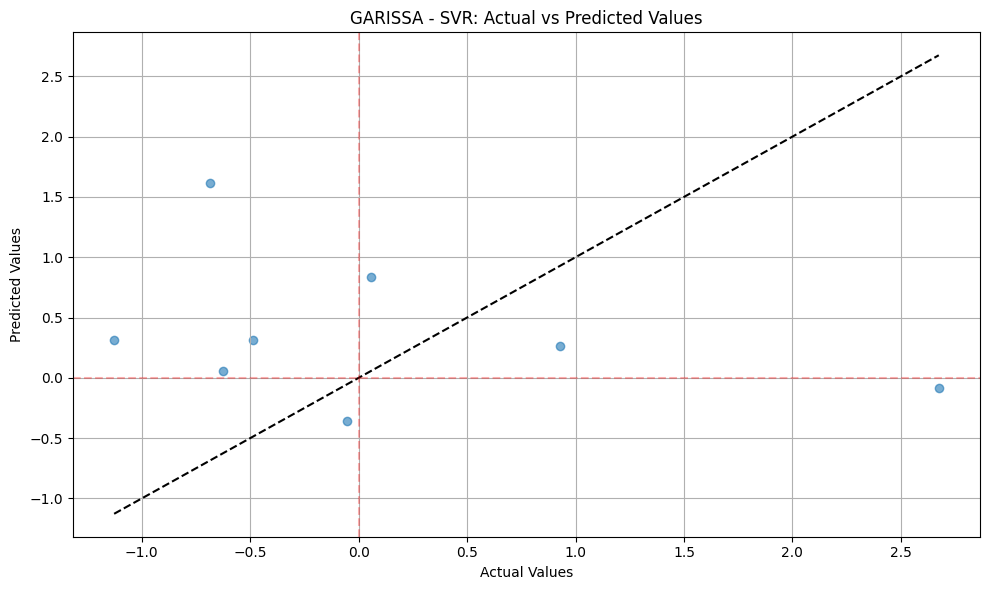


Working with GARISSA data from 1959 to 2023
Total data points: 65
Features used: IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for GARISSA: ['IODE', 'IODW', 'rolling_mean_3yr', 'rolling_std_3yr', 'is_el_nino', 'la_nina_weight']
Training samples: 48
Validation samples: 9
Testing samples: 8
Training years: 1959 to 2006
Validation years: 2007 to 2015
Testing years: 2016 to 2023
Cross-validation R² scores for GARISSA - Neural Network: [0.023939128514468888, -1.6803143386873902, -0.15073902875915057, 0.2696428907002216, 0.21503917321889499]
Average CV R²: -0.264
  RMSE for values below zero: 1.323
  Number of below-zero actual values in test set: 5

Results for GARISSA using Neural Network:
  Train R² = 0.103, RMSE = 0.979
  Validation R² = -1.176, RMSE = 0.655
  Test R² = -0.837, RMSE = 1.540, MAE = 1.246


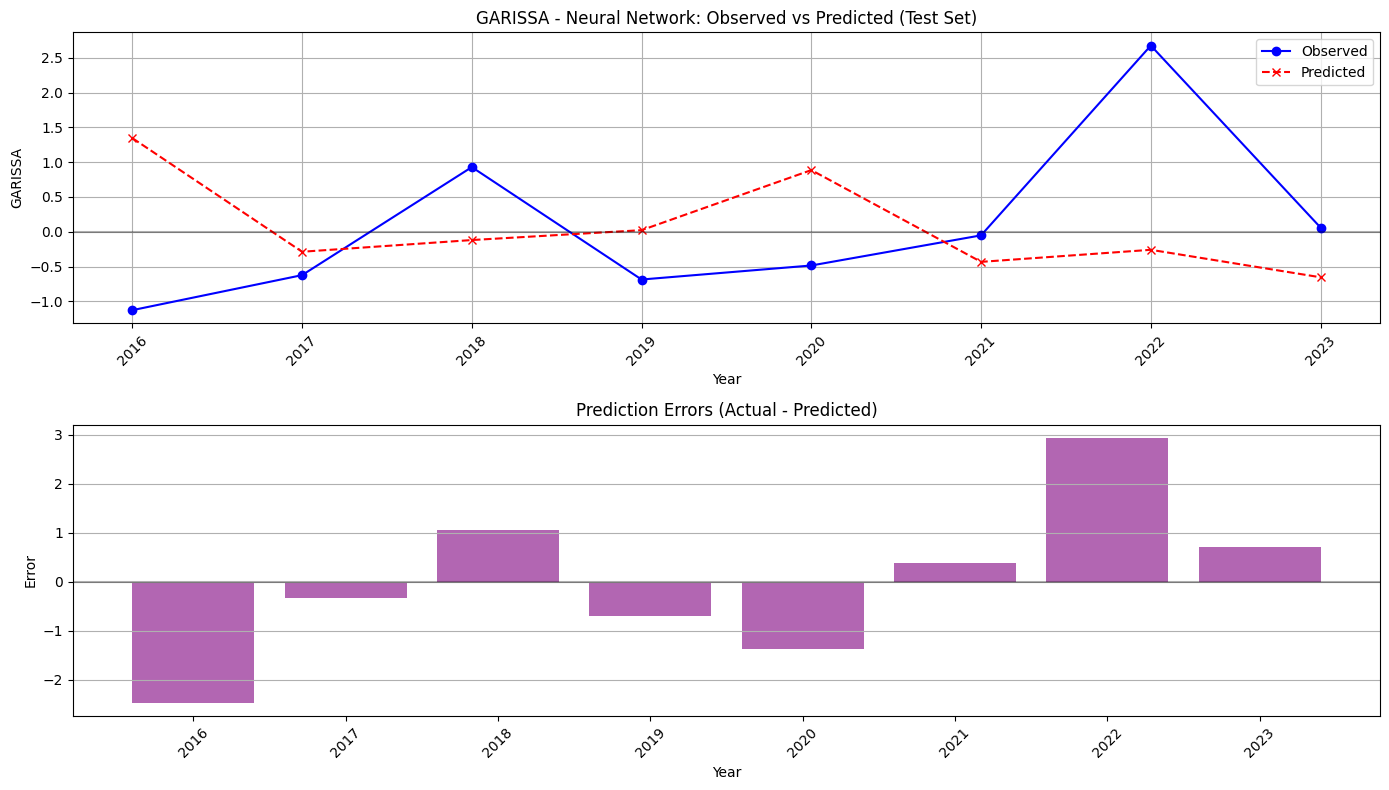

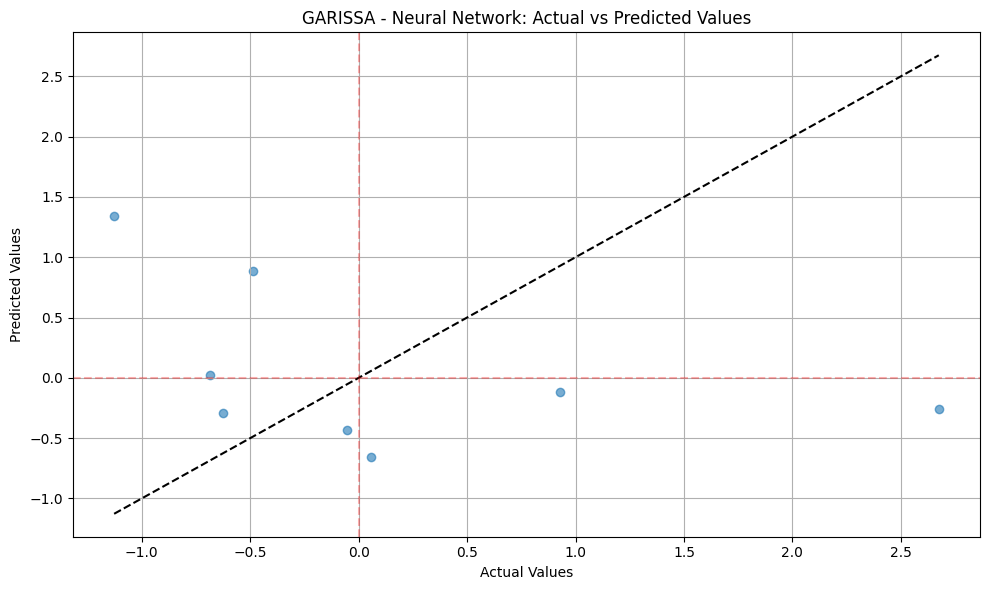


Working with WAJIR data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for WAJIR: ['IODW', 'N34', 'N4', 'IODE', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for WAJIR - Random Forest: [-13.437182016358824, 0.2315533768798893, 0.27067963826202557, -1.3129623790047953, -1.1941842556107636]
Average CV R²: -3.088
  RMSE for values below zero: 0.594
  Number of below-zero actual values in test set: 4

Results for WAJIR using Random Forest:
  Train R² = 0.523, RMSE = 1.205
  Validation R² = -0.588, RMSE = 2.074
  Test R² = 0.779, RMSE = 0.663, MAE = 0.593


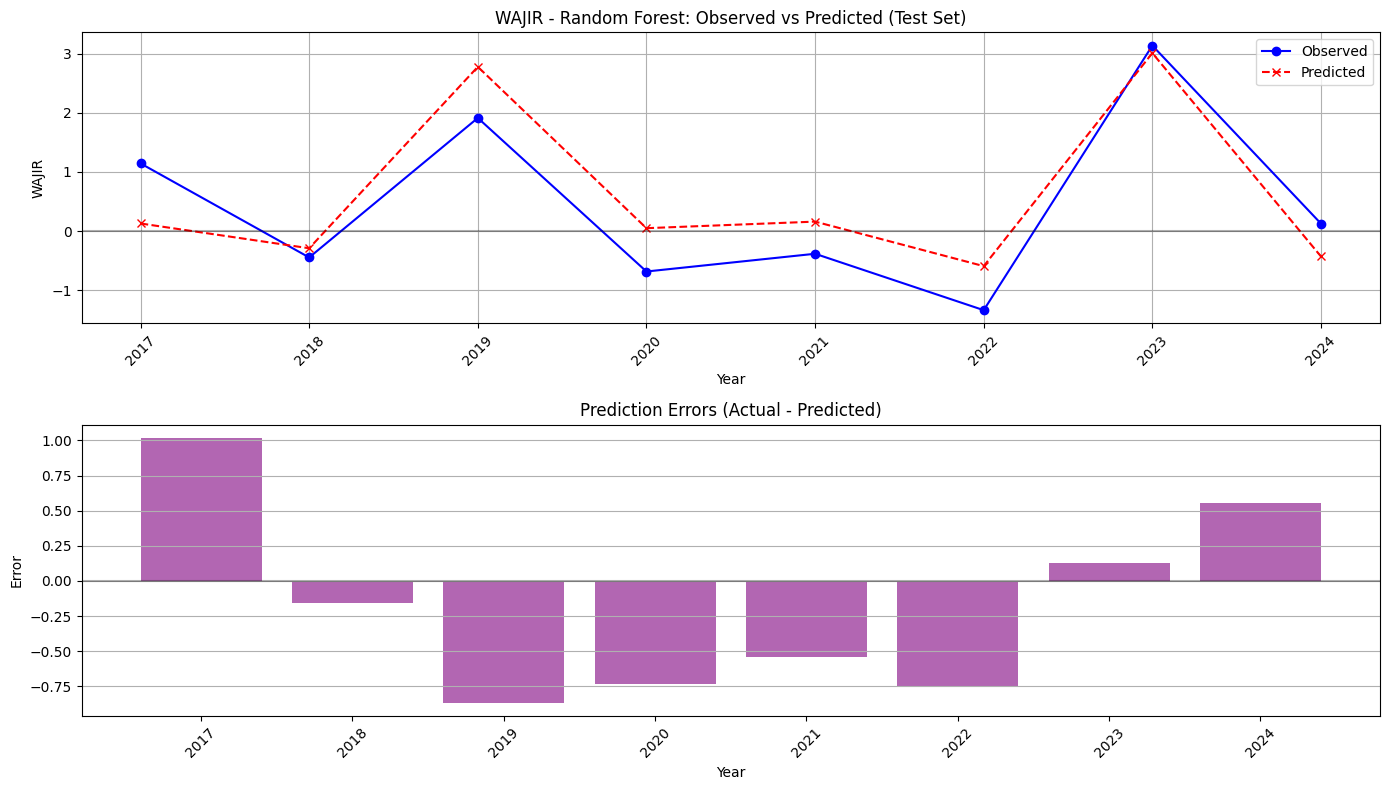

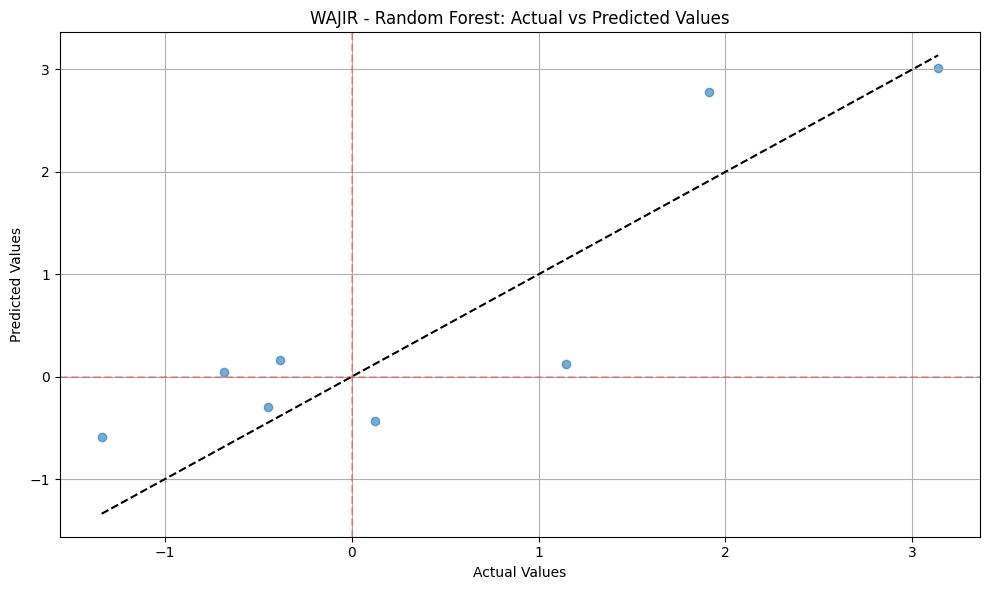


Working with WAJIR data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for WAJIR: ['IODW', 'N34', 'N4', 'IODE', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for WAJIR - Gradient Boosting: [-3.414426125128262, -0.025480787497030644, -0.11971780768590579, -0.5124095428055335, -0.3368462291622749]
Average CV R²: -0.882
  RMSE for values below zero: 0.509
  Number of below-zero actual values in test set: 4

Results for WAJIR using Gradient Boosting:
  Train R² = 0.316, RMSE = 1.443
  Validation R² = -0.407, RMSE = 1.953
  Test R² = 0.094, RMSE = 1.343, MAE = 1.035


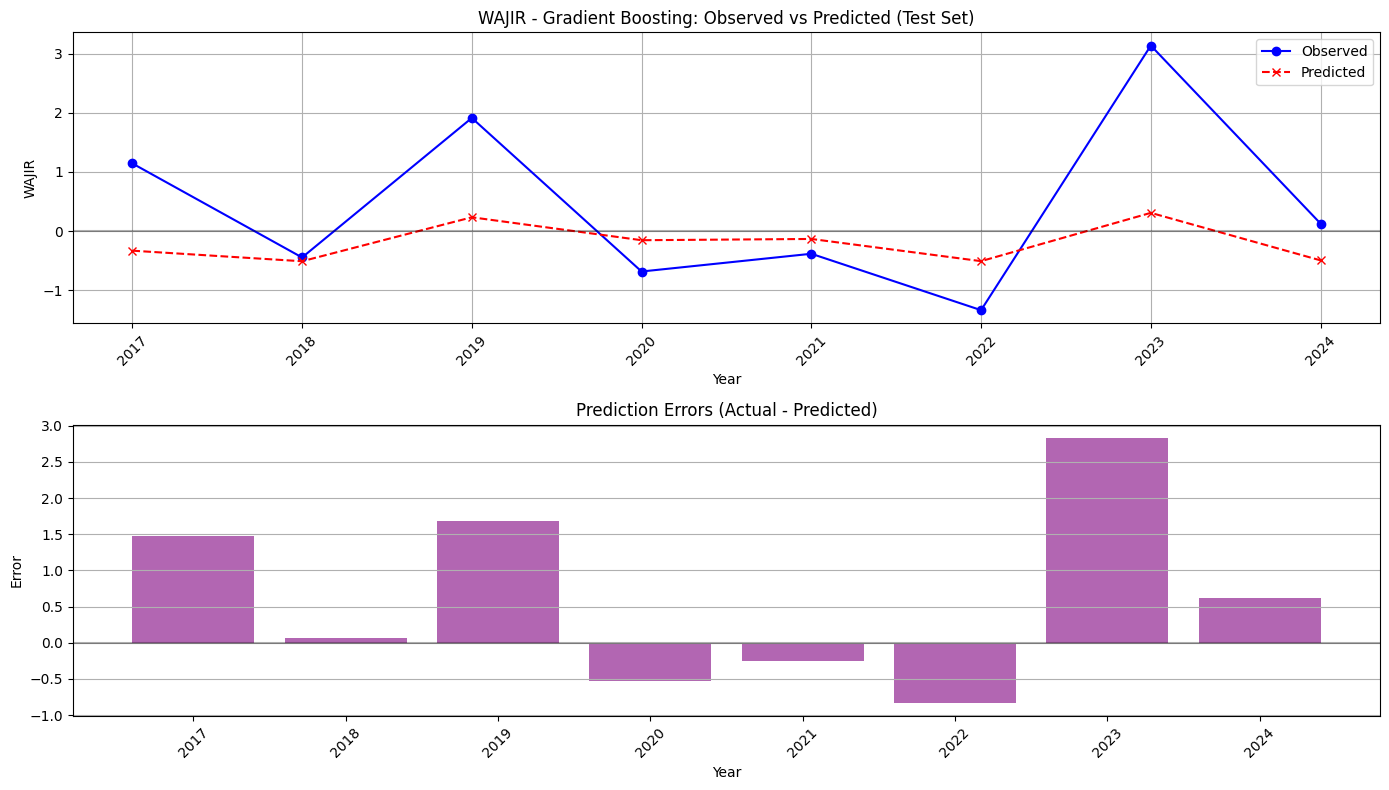

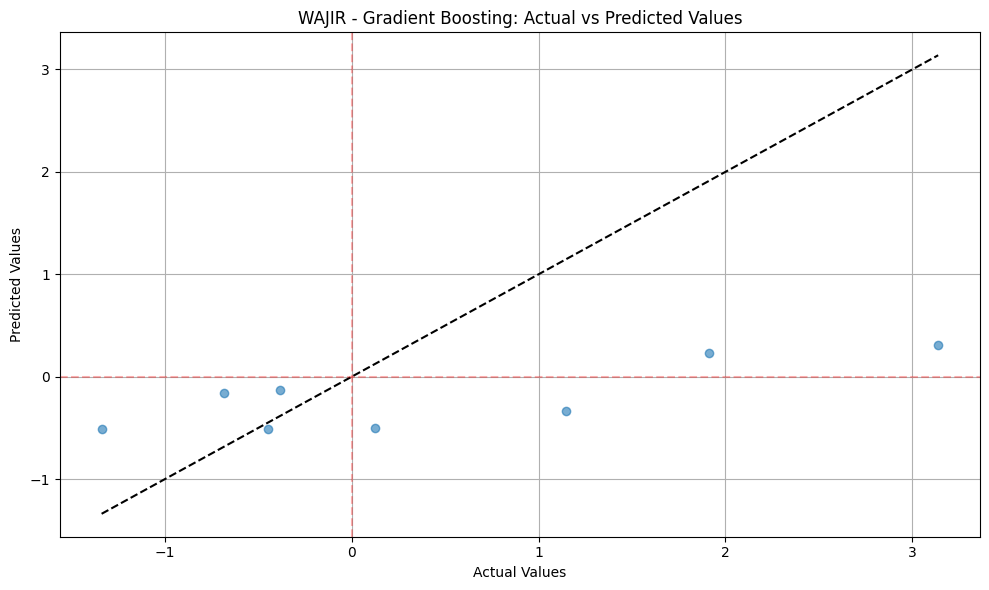


Working with WAJIR data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for WAJIR: ['IODW', 'N34', 'N4', 'IODE', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for WAJIR - SVR: [-1.6070248325770482, -0.17239333805286416, -0.07724077772016824, -0.15036013768071155, -0.1471733905284407]
Average CV R²: -0.431
  RMSE for values below zero: 0.495
  Number of below-zero actual values in test set: 4

Results for WAJIR using SVR:
  Train R² = 0.214, RMSE = 1.547
  Validation R² = -0.270, RMSE = 1.856
  Test R² = -0.213, RMSE = 1.555, MAE = 1.106


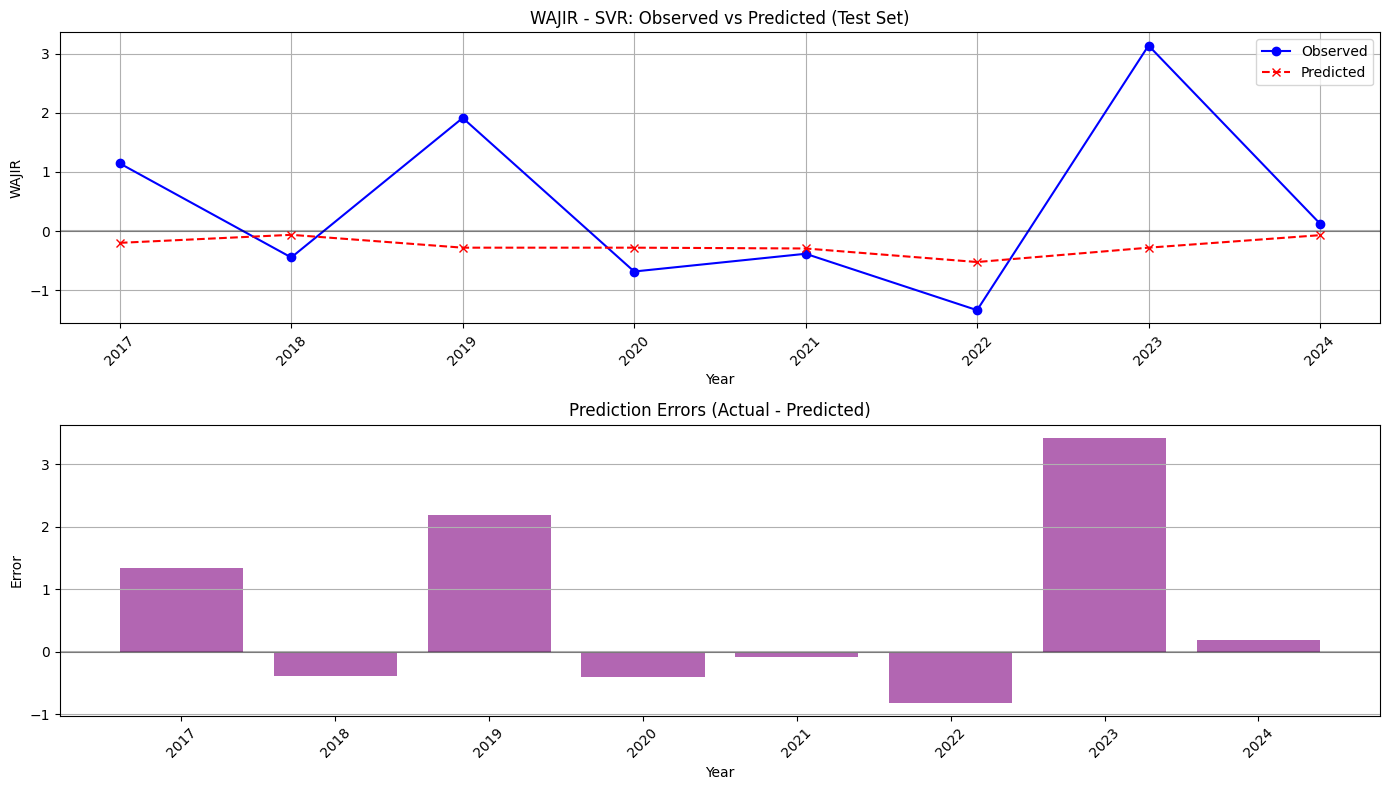

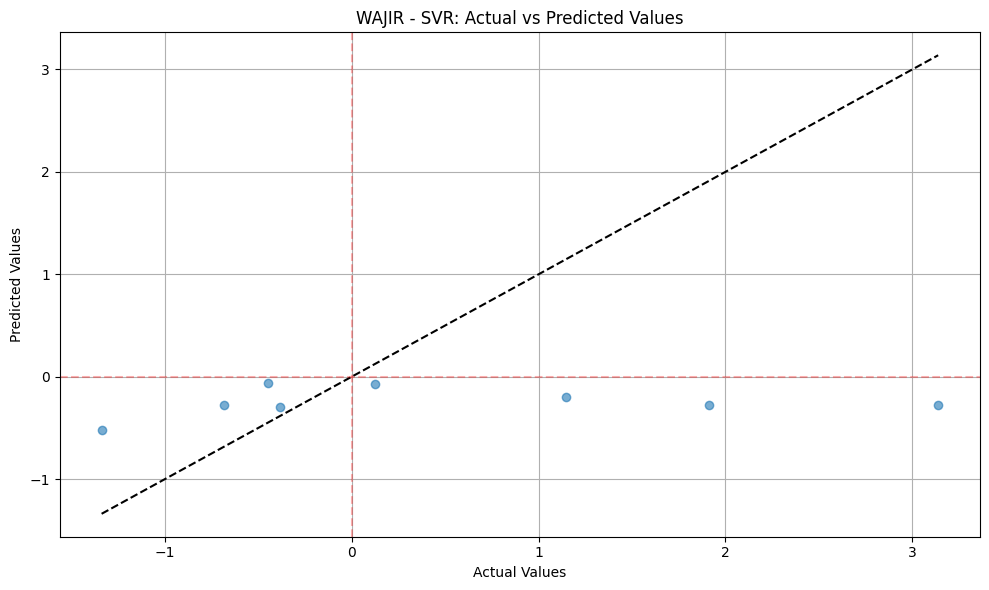


Working with WAJIR data from 1950 to 2024
Total data points: 75
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for WAJIR: ['IODW', 'N34', 'N4', 'IODE', 'el_nino_weight', 'la_nina_weight']
Training samples: 56
Validation samples: 11
Testing samples: 8
Training years: 1950 to 2005
Validation years: 2006 to 2016
Testing years: 2017 to 2024
Cross-validation R² scores for WAJIR - Neural Network: [-1.2140097345518504, 0.06835016190353393, 0.03189002376854866, -0.13790498409652963, -0.24145821582356186]
Average CV R²: -0.299
  RMSE for values below zero: 0.795
  Number of below-zero actual values in test set: 4

Results for WAJIR using Neural Network:
  Train R² = 0.185, RMSE = 1.575
  Validation R² = -0.402, RMSE = 1.949
  Test R² = 0.575, RMSE = 0.921, MAE = 0.742


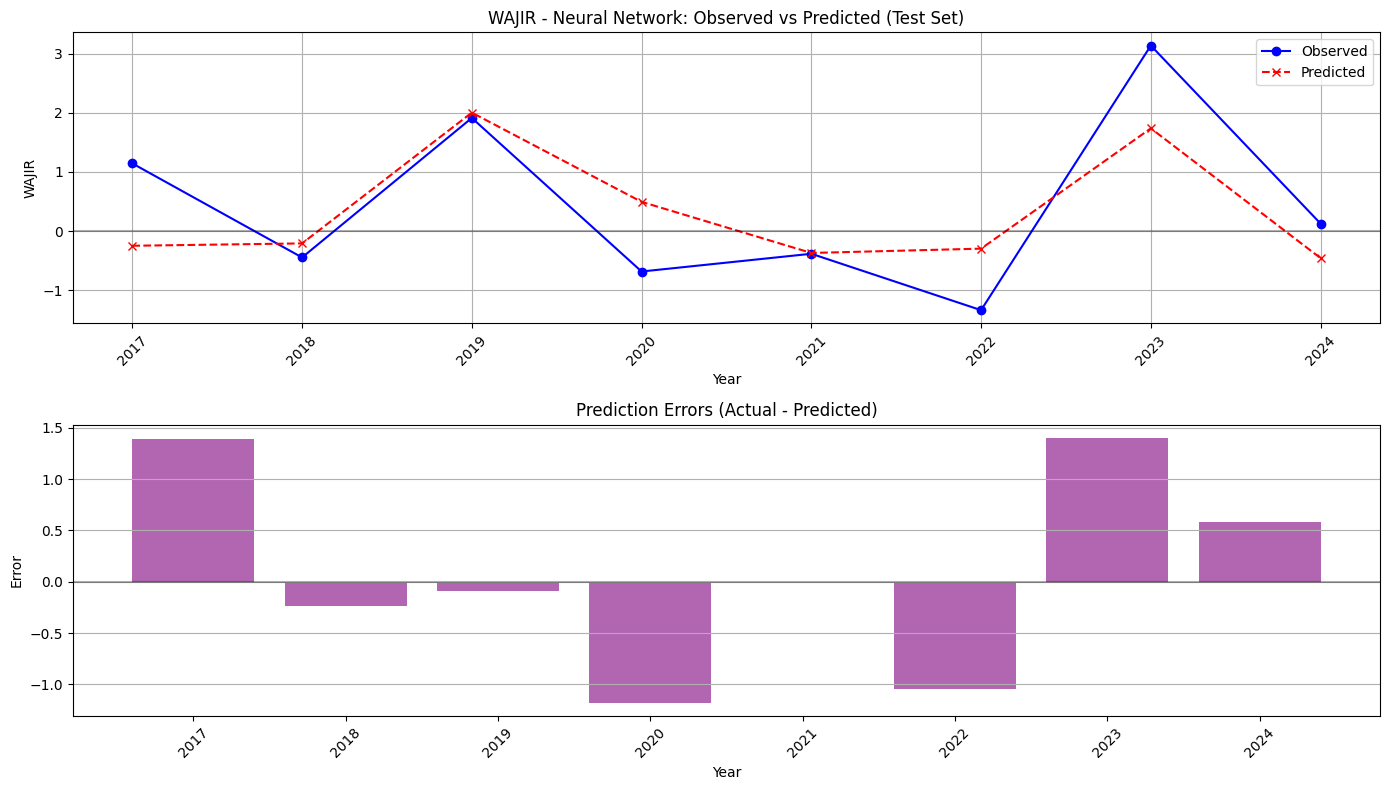

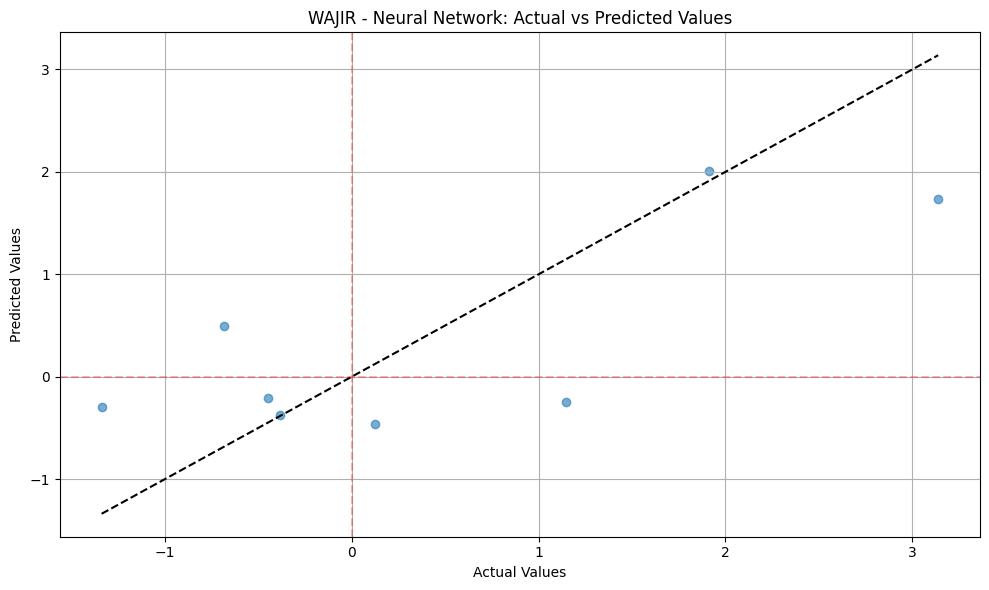


Working with MOMBASA data from 1957 to 2024
Total data points: 68
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOMBASA: ['IODW', 'N34', 'el_nino_weight', 'N4', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 51
Validation samples: 10
Testing samples: 7
Training years: 1957 to 2007
Validation years: 2008 to 2017
Testing years: 2018 to 2024
Cross-validation R² scores for MOMBASA - Random Forest: [0.13810228786655, -0.05671886750173405, -1.3155788371014983, -0.940474185725305, 0.07240071909212209]
Average CV R²: -0.420
  RMSE for values below zero: 0.140
  Number of below-zero actual values in test set: 4

Results for MOMBASA using Random Forest:
  Train R² = 0.509, RMSE = 0.550
  Validation R² = 0.170, RMSE = 0.361
  Test R² = 0.648, RMSE = 0.697, MAE = 0.456


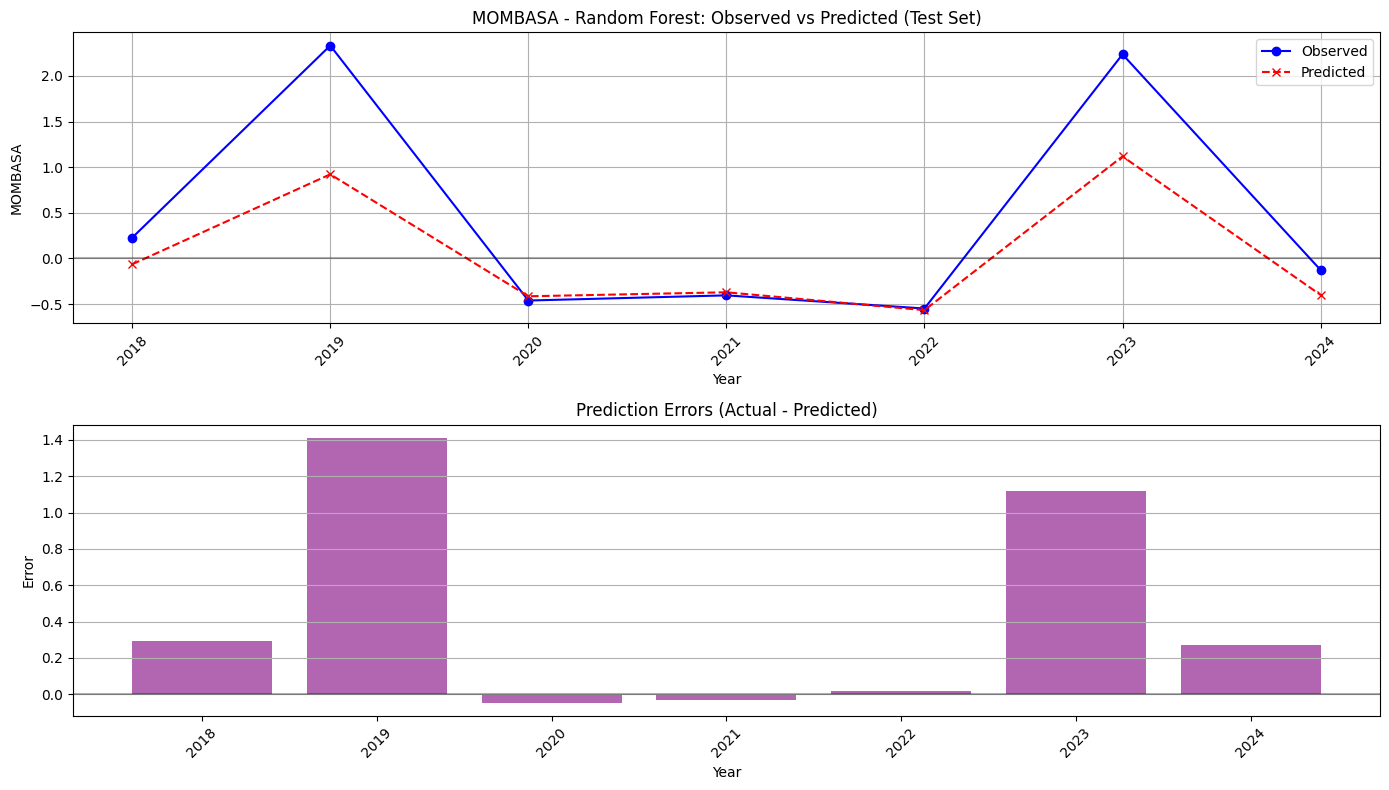

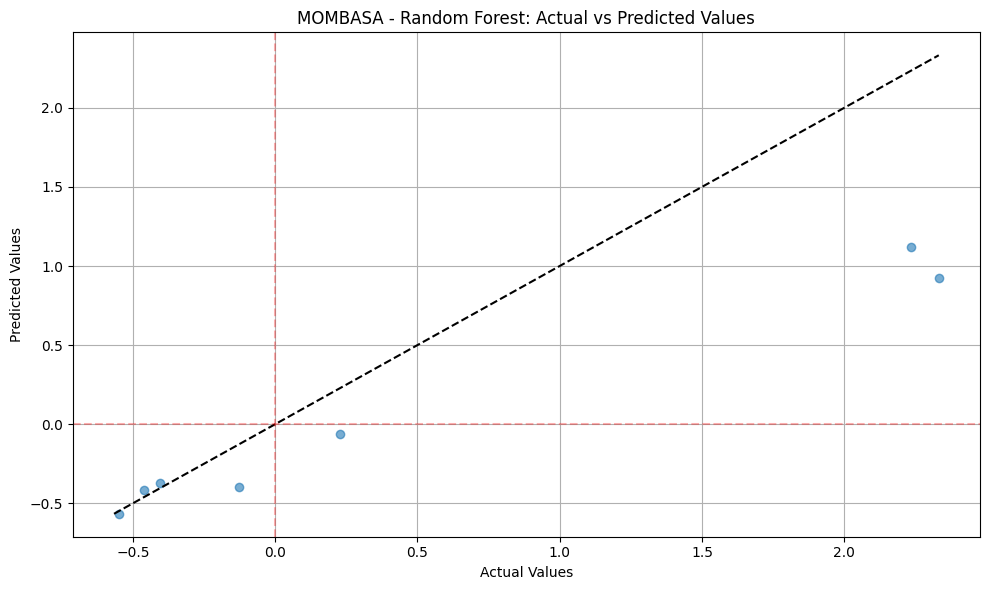


Working with MOMBASA data from 1957 to 2024
Total data points: 68
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOMBASA: ['IODW', 'N34', 'el_nino_weight', 'N4', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 51
Validation samples: 10
Testing samples: 7
Training years: 1957 to 2007
Validation years: 2008 to 2017
Testing years: 2018 to 2024
Cross-validation R² scores for MOMBASA - Gradient Boosting: [0.09329758108258379, -0.8379732509902029, -0.5449483781057478, -0.32570769869383853, 0.0867116148938365]
Average CV R²: -0.306
  RMSE for values below zero: 0.155
  Number of below-zero actual values in test set: 4

Results for MOMBASA using Gradient Boosting:
  Train R² = 0.312, RMSE = 0.652
  Validation R² = 0.076, RMSE = 0.381
  Test R² = 0.074, RMSE = 1.131, MAE = 0.736


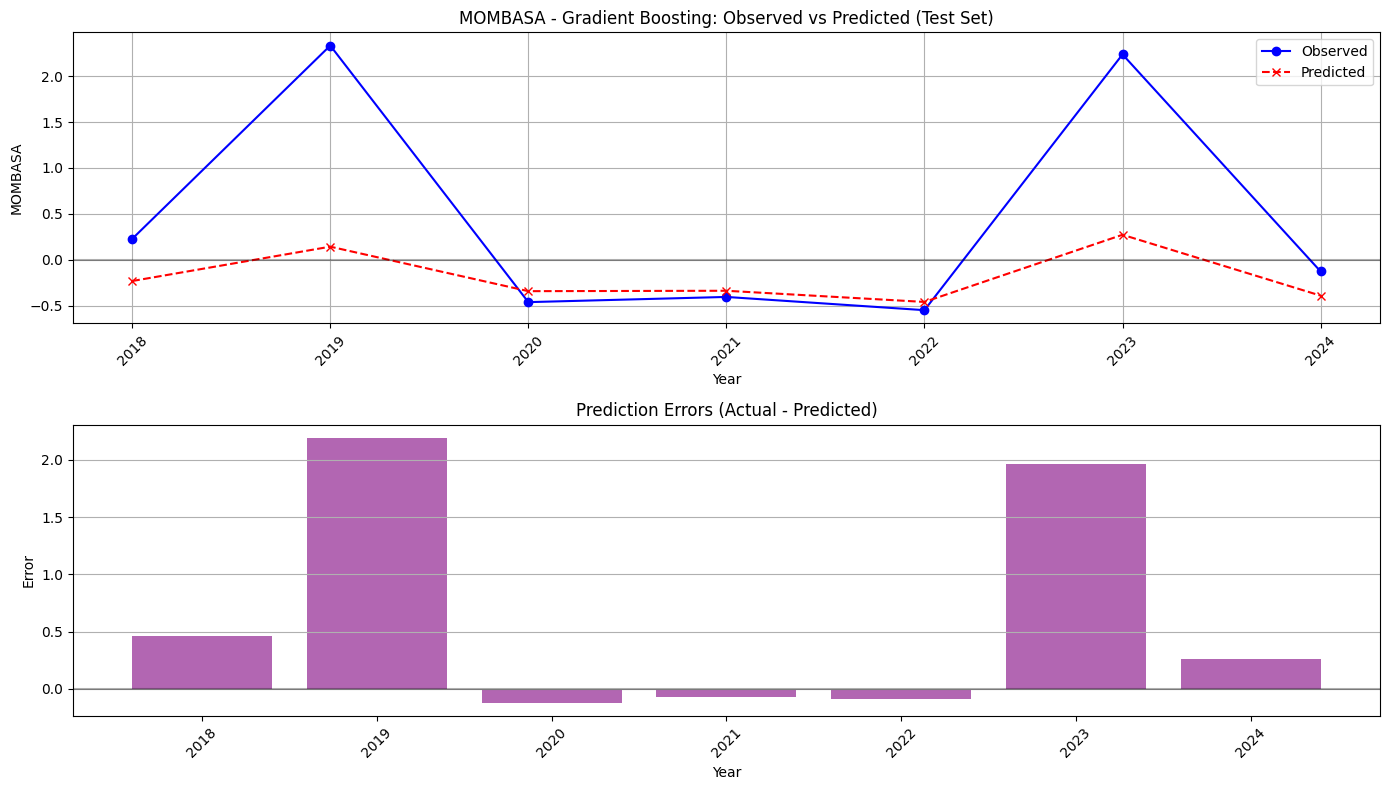

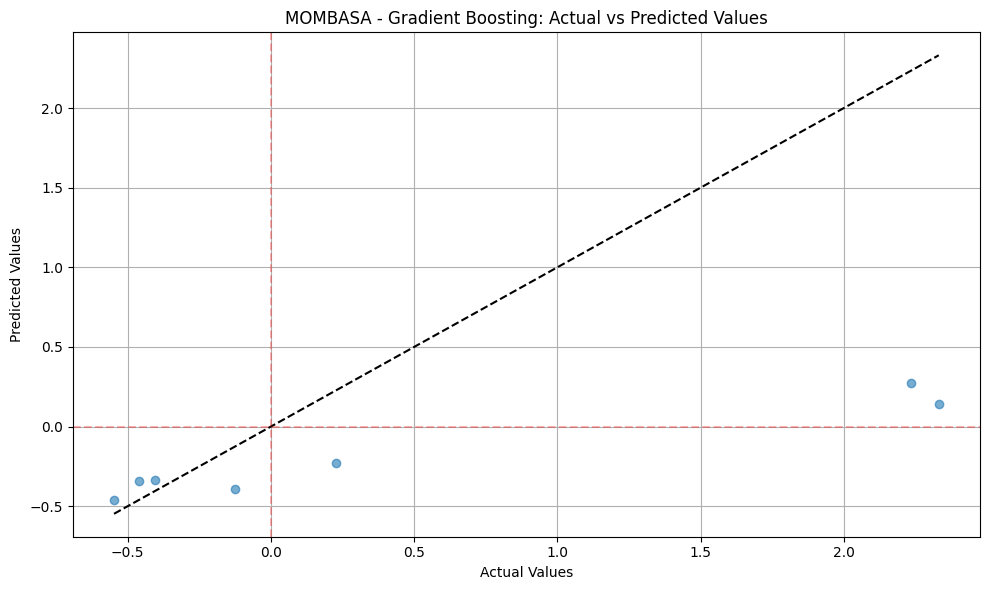


Working with MOMBASA data from 1957 to 2024
Total data points: 68
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOMBASA: ['IODW', 'N34', 'el_nino_weight', 'N4', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 51
Validation samples: 10
Testing samples: 7
Training years: 1957 to 2007
Validation years: 2008 to 2017
Testing years: 2018 to 2024
Cross-validation R² scores for MOMBASA - SVR: [-0.03268886242221569, -0.4694033586128805, -1.0586572979746642, -2.54094173346212, -0.019992279813707547]
Average CV R²: -0.824
  RMSE for values below zero: 0.176
  Number of below-zero actual values in test set: 4

Results for MOMBASA using SVR:
  Train R² = 0.403, RMSE = 0.607
  Validation R² = -0.012, RMSE = 0.399
  Test R² = -0.219, RMSE = 1.298, MAE = 0.788


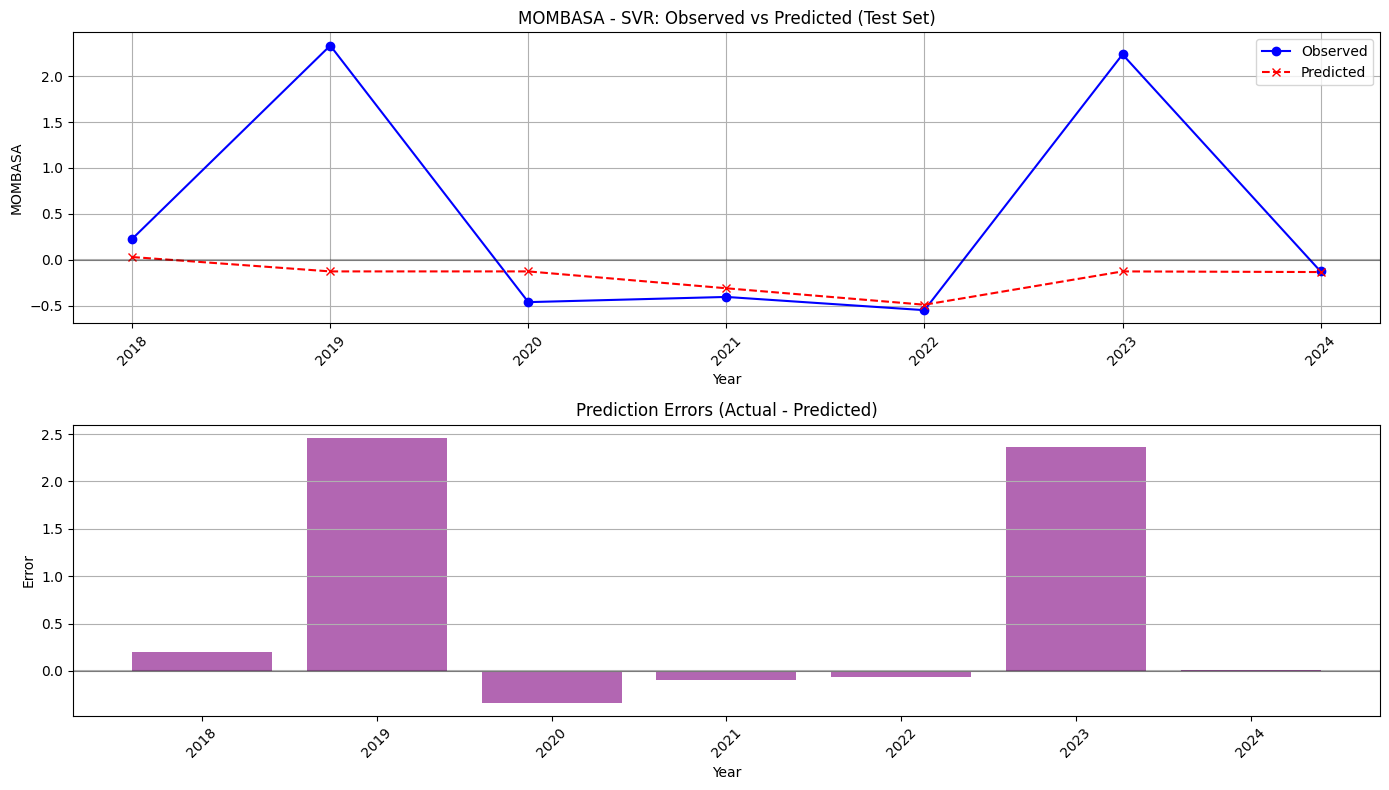

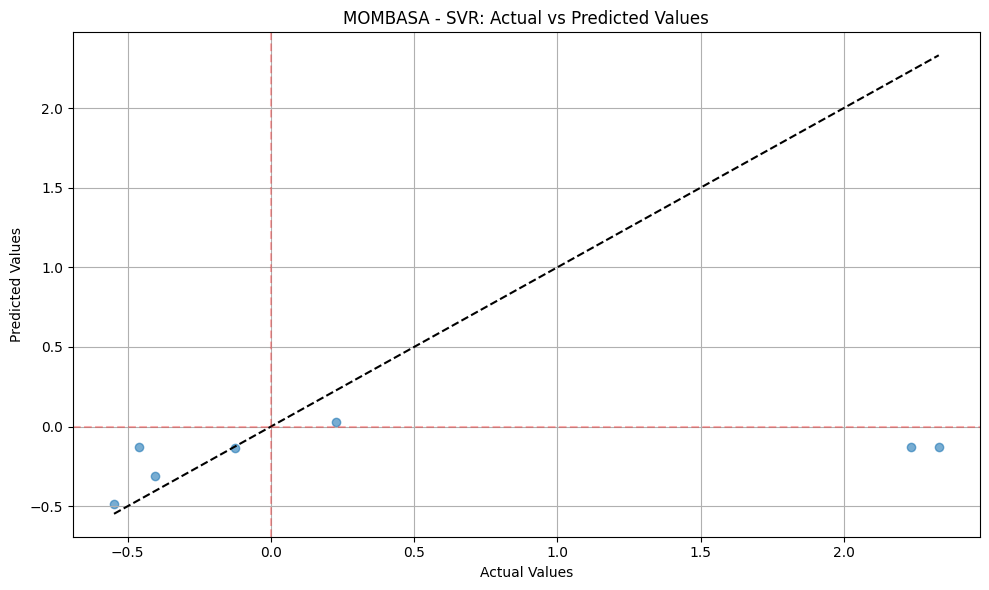


Working with MOMBASA data from 1957 to 2024
Total data points: 68
Features used: N34, N4, IODE, IODW, is_el_nino, is_la_nina, recent_strong_el_nino, recent_strong_la_nina, el_nino_weight, la_nina_weight, rolling_mean_3yr, rolling_std_3yr
Top features for MOMBASA: ['IODW', 'N34', 'el_nino_weight', 'N4', 'rolling_std_3yr', 'la_nina_weight']
Training samples: 51
Validation samples: 10
Testing samples: 7
Training years: 1957 to 2007
Validation years: 2008 to 2017
Testing years: 2018 to 2024
Cross-validation R² scores for MOMBASA - Neural Network: [0.07996408740432903, -1.161111417133939, -0.4434316318478577, -1.3481466573234657, -0.13698827065001096]
Average CV R²: -0.602
  RMSE for values below zero: 0.213
  Number of below-zero actual values in test set: 4

Results for MOMBASA using Neural Network:
  Train R² = 0.384, RMSE = 0.617
  Validation R² = -0.859, RMSE = 0.540
  Test R² = 0.953, RMSE = 0.256, MAE = 0.225


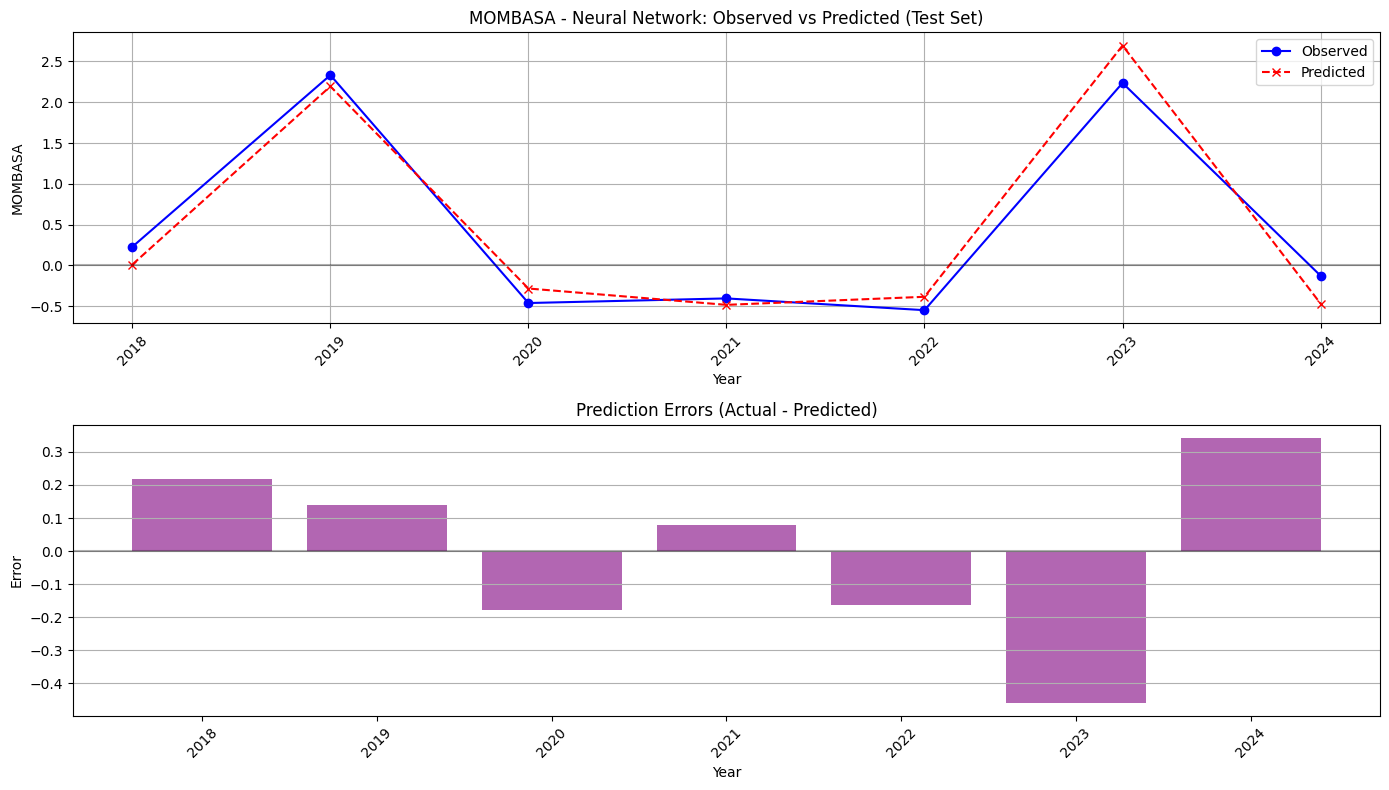

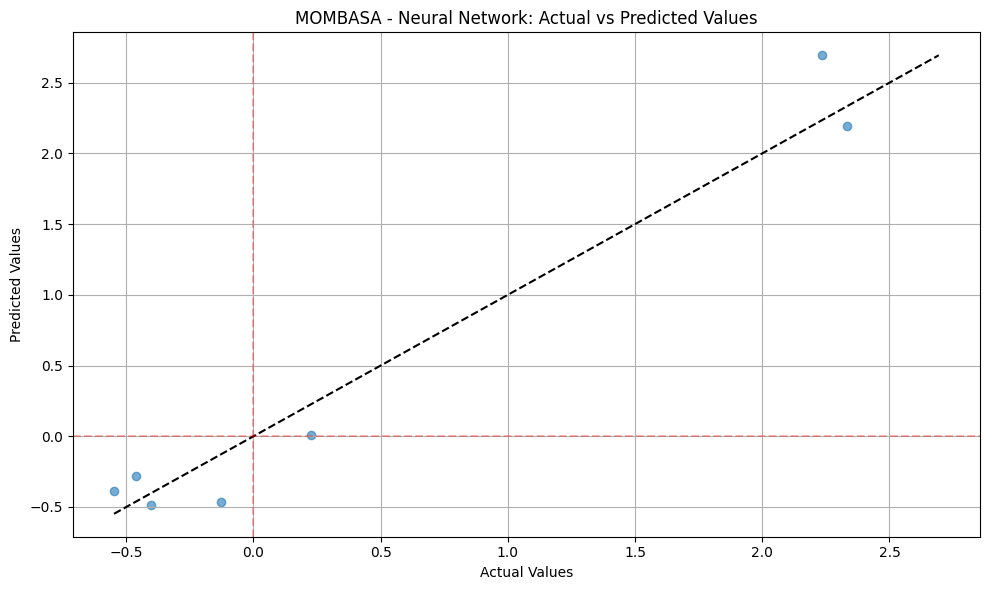


Summary of Best Models for Each Station
Station        Best Model        R2     RMSE      MAE  Below Zero RMSE                                                  Features Used
    VOI     Random Forest  0.542245 0.590208 0.480896         0.641542 IODW, N34, el_nino_weight, N4, rolling_std_3yr, la_nina_weight
 MOYALE     Random Forest  0.560044 0.580921 0.446334         0.343898 IODW, N34, el_nino_weight, N4, rolling_std_3yr, la_nina_weight
 LODWAR     Random Forest  0.478542 0.581911 0.477479         0.312356 IODW, N34, el_nino_weight, N4, rolling_std_3yr, la_nina_weight
   LAMU     Random Forest  0.575411 1.064169 0.826794         0.657583 IODW, N34, el_nino_weight, N4, rolling_std_3yr, la_nina_weight
GARISSA Gradient Boosting -0.095026 1.189126 0.891116         0.858575 IODW, N34, el_nino_weight, N4, rolling_std_3yr, la_nina_weight
  WAJIR     Random Forest  0.779191 0.663384 0.592888         0.594346 IODW, N34, el_nino_weight, N4, rolling_std_3yr, la_nina_weight
MOMBASA    Neural Net

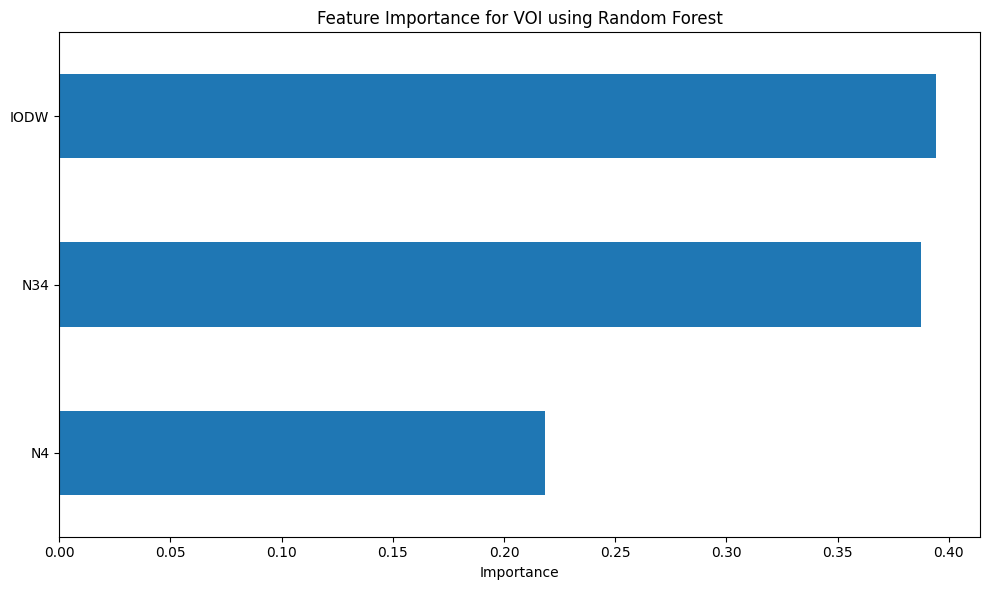

  VOI - Feature Importance:
    IODW: 0.3943
    N34: 0.3873
    N4: 0.2184


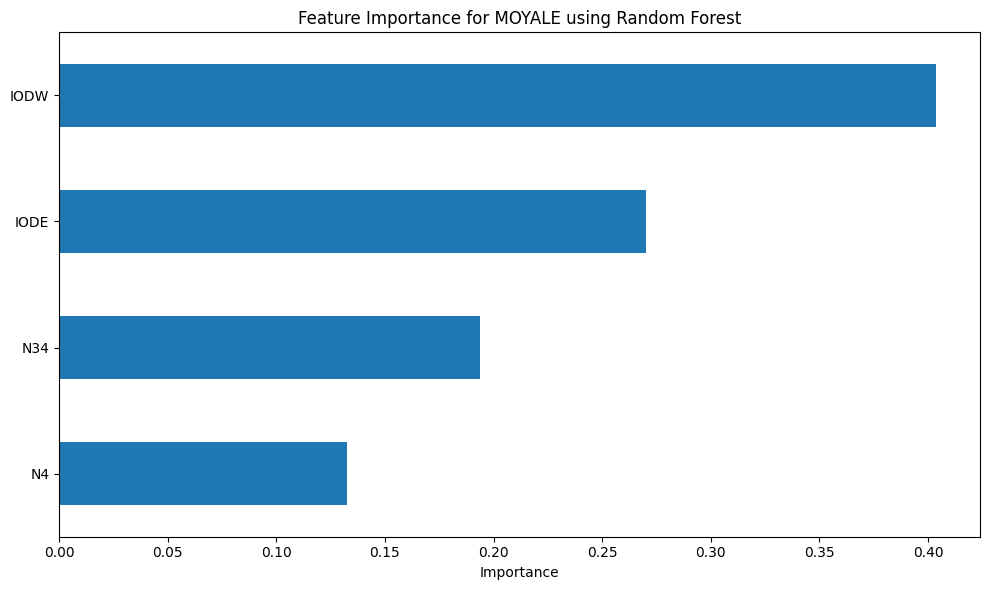

  MOYALE - Feature Importance:
    IODW: 0.4037
    IODE: 0.2702
    N34: 0.1936
    N4: 0.1324


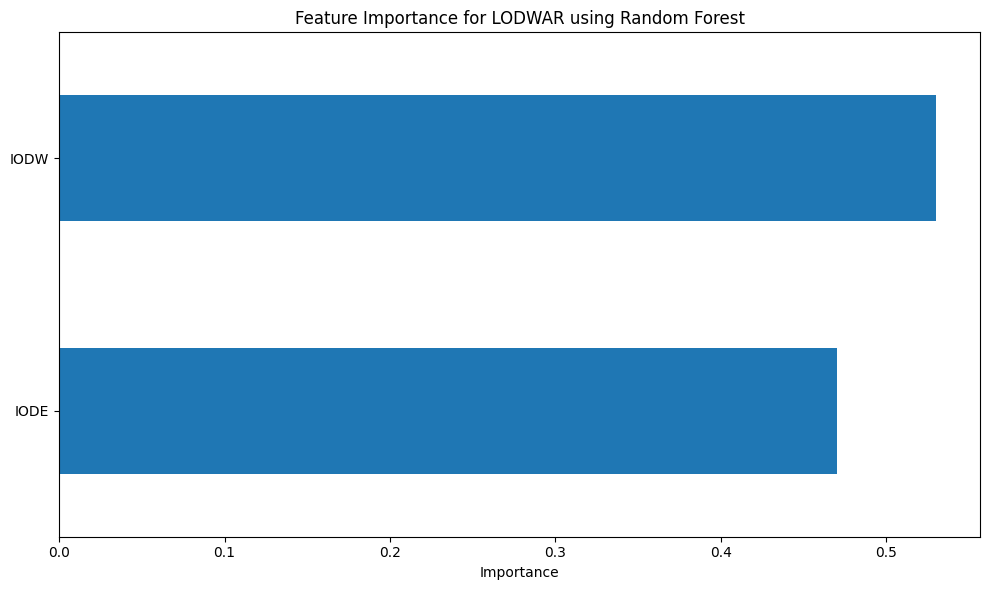

  LODWAR - Feature Importance:
    IODW: 0.5300
    IODE: 0.4700


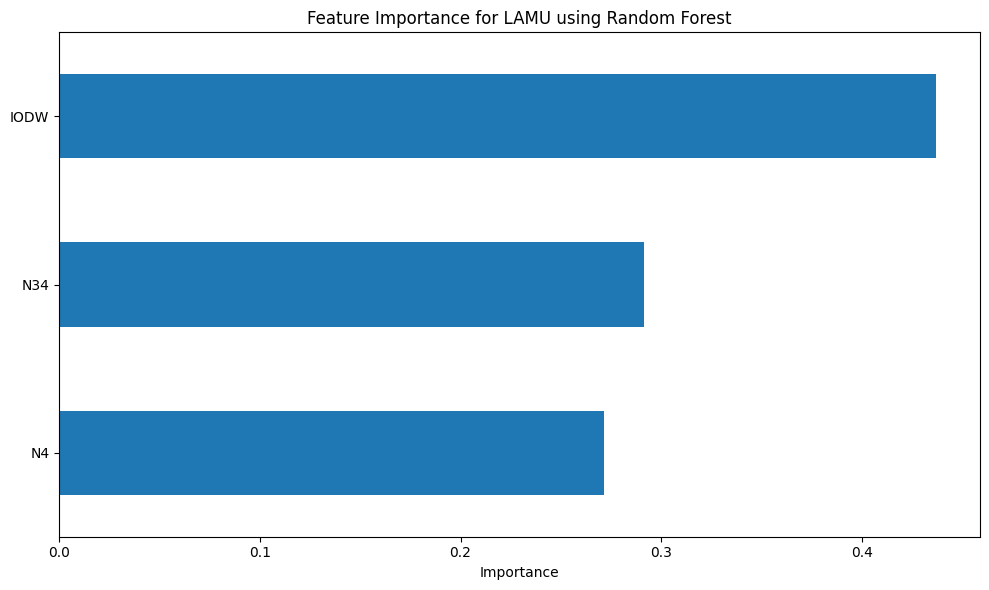

  LAMU - Feature Importance:
    IODW: 0.4370
    N34: 0.2915
    N4: 0.2715


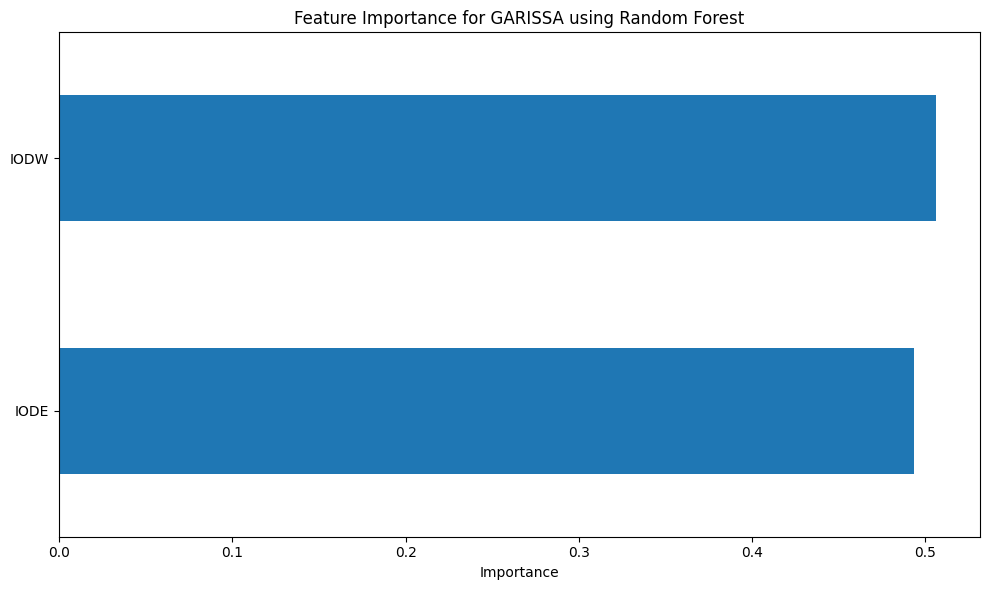

  GARISSA - Feature Importance:
    IODW: 0.5063
    IODE: 0.4937


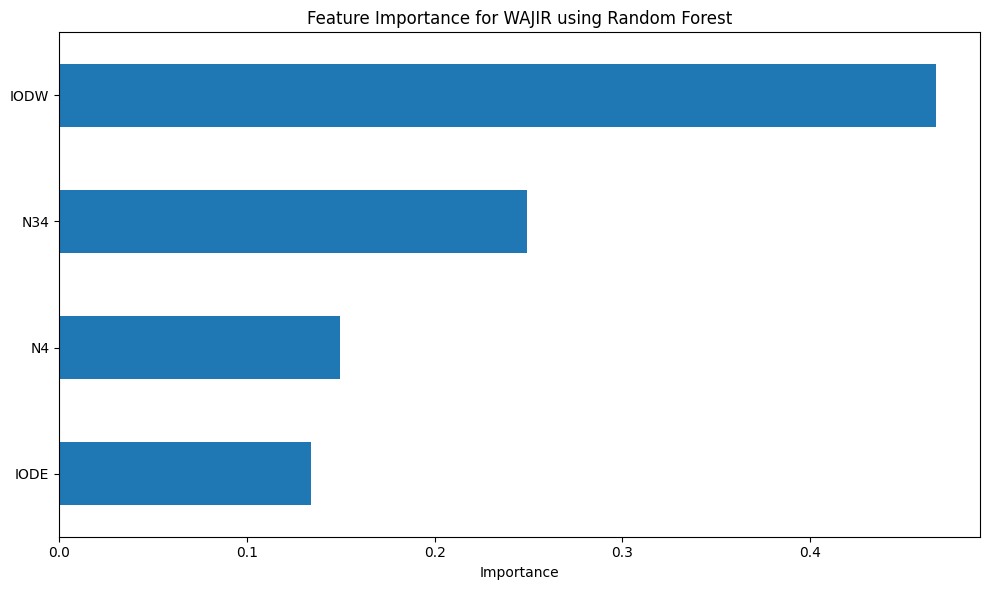

  WAJIR - Feature Importance:
    IODW: 0.4671
    N34: 0.2492
    N4: 0.1496
    IODE: 0.1341
  MOMBASA - Neural Network: Feature importance not available for this model type

Drought Forecasting Model Training Complete!


In [4]:
#MODEL DEVELOPMENT
# List of known El Niño and La Niña years
el_nino_years = [1961, 1997, 2013, 2019, 2023]
la_nina_years = [1988, 1998, 2007, 2010, 2016, 2020]

# Create model configurations using the filtered data from correlation analysis
model_configs = [
    {"Station": station_name, "Model": model_type} 
    for station_name in filtered_sheet_dict.keys() 
    for model_type in ["Random Forest", "Gradient Boosting", "SVR", "Neural Network"]
]
model_df = pd.DataFrame(model_configs)

results_dict = {}

# Function to add additional features
def engineer_features(df):
    df_new = df.copy()
    if 'YEAR' in df_new.index.names:
        df_new = df_new.reset_index()
    df_new = df_new.sort_values('YEAR')
    rainfall_col = df_new.columns[1]  # Station name
    
    # Simplified rolling statistics
    if len(df) > 3:
        df_new['rolling_mean_3yr'] = df_new[rainfall_col].rolling(window=3, min_periods=1).mean().shift(1)
        df_new['rolling_std_3yr'] = df_new[rainfall_col].rolling(window=3, min_periods=1).std().shift(1)
        df_new['rolling_mean_3yr'] = df_new['rolling_mean_3yr'].fillna(df_new[rainfall_col].mean())
        df_new['rolling_std_3yr'] = df_new['rolling_std_3yr'].fillna(df_new[rainfall_col].std())
    
    return df_new

for _, row in model_df.iterrows():
    station = row["Station"]
    model_name = row["Model"]

    if station not in filtered_sheet_dict:
        print(f"Station {station} not found in filtered data. Skipping...")
        continue

    df = filtered_sheet_dict[station].copy()
    print(f"\nWorking with {station} data from {df['YEAR'].min()} to {df['YEAR'].max()}")
    print(f"Total data points: {len(df)}")
    
    # Enhance El Niño and La Niña signals with higher weighting
    df['is_el_nino'] = df['YEAR'].apply(lambda x: 1 if x in el_nino_years else 0)
    df['is_la_nina'] = df['YEAR'].apply(lambda x: 1 if x in la_nina_years else 0)
    df['recent_strong_el_nino'] = df['YEAR'].apply(lambda x: 2 if x in [2019, 2023] else (1 if x == 2013 else 0))
    df['recent_strong_la_nina'] = df['YEAR'].apply(lambda x: 2 if x in [2016, 2020] else (1 if x == 2010 else 0))
    df['el_nino_weight'] = df['is_el_nino'] * (1 + df['recent_strong_el_nino'] * 1.0)
    df['la_nina_weight'] = df['is_la_nina'] * (1 + df['recent_strong_la_nina'] * 1.0)
    
    # Add engineered features
    df = engineer_features(df)
    df = df.sort_values('YEAR')
    
    # Define features and target
    target_col = station  # Station name is the target (rainfall)
    years = df['YEAR'].values
    
    # Use all columns except YEAR and the target (rainfall) column
    feature_columns = [col for col in df.columns if col != 'YEAR' and col != target_col]
    print(f"Features used: {', '.join(feature_columns)}")
    
    X = df[feature_columns]
    y = df[target_col]
    
    if X.shape[1] == 0:
        print(f"No features available for {station}. Skipping model creation.")
        continue
    
    # Select top features using Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    top_features = importances.nlargest(6).index.tolist()
    
    # Make sure El Niño and La Niña indicators are considered
    enso_features = ['el_nino_weight', 'la_nina_weight']
    for feature in enso_features:
        if feature not in top_features and feature in X.columns:
            if len(top_features) >= 6:
                top_features = top_features[:5] + [feature]
            else:
                top_features.append(feature)
        
    print(f"Top features for {station}: {top_features}")
    X = X[top_features]
    
    if len(X) < 5:
        print(f"Not enough data points for {station}. Skipping model creation.")
        continue

    # Split data into training, validation, and test sets
    train_size = 0.75
    val_size = 0.15
    test_size = 0.10
    train_end = int(len(X) * train_size)
    val_end = train_end + int(len(X) * val_size)

    print(f"Training samples: {train_end}")
    print(f"Validation samples: {val_end - train_end}")
    print(f"Testing samples: {len(X) - val_end}")

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    years_train = years[:train_end]
    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]
    years_val = years[train_end:val_end]
    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]
    years_test = years[val_end:]

    print(f"Training years: {min(years_train)} to {max(years_train)}")
    print(f"Validation years: {min(years_val)} to {max(years_val)}")
    print(f"Testing years: {min(years_test)} to {max(years_test)}")
    
    # Configure and train the model based on the model type
    if model_name == "Random Forest":
        model = Pipeline([
            ('scaler', RobustScaler()),
            ('model', RandomForestRegressor(
                n_estimators=100, 
                max_depth=5,
                min_samples_leaf=3,
                min_samples_split=5,
                random_state=42
            ))
        ])
    elif model_name == "Gradient Boosting":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingRegressor(
                loss='huber', 
                n_estimators=100,
                learning_rate=0.01,
                max_depth=3,
                min_samples_leaf=3,
                subsample=0.8,
                random_state=42
            ))
        ])
    elif model_name == "SVR":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVR(
                kernel='rbf',
                C=1.0,
                epsilon=0.1,
                gamma='scale'
            ))
        ])
    elif model_name == "Neural Network":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', MLPRegressor(
                hidden_layer_sizes=(50, 25),
                activation='relu',
                solver='adam',
                alpha=0.01,
                max_iter=2000,
                early_stopping=True,
                validation_fraction=0.1,
                random_state=42
            ))
        ])
    else:
        print(f"Unknown model type: {model_name}. Skipping...")
        continue
        
    try:
        # Cross-validation on training data
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_r2_scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(X_cv_train, y_cv_train)
            y_cv_pred = model.predict(X_cv_val)
            cv_r2 = r2_score(y_cv_val, y_cv_pred)
            cv_r2_scores.append(cv_r2)
        print(f"Cross-validation R² scores for {station} - {model_name}: {cv_r2_scores}")
        print(f"Average CV R²: {np.mean(cv_r2_scores):.3f}")

        # Train on full training set
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        # Metrics for all sets
        train_r2 = r2_score(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_r2 = r2_score(y_val, y_val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # Calculate special metrics for drought events (values below zero)
        below_zero_indices = np.where(y_test < 0)[0]
        if len(below_zero_indices) > 0:
            below_zero_rmse = np.sqrt(mean_squared_error(y_test.iloc[below_zero_indices], y_test_pred[below_zero_indices]))
            print(f"  RMSE for values below zero: {below_zero_rmse:.3f}")
            print(f"  Number of below-zero actual values in test set: {len(below_zero_indices)}")
        else:
            below_zero_rmse = None
            print("  No below-zero values in test set to evaluate")
        
        # Store results
        results_dict.setdefault(station, {})[model_name] = {
            'rmse': test_rmse,
            'r2': test_r2,
            'mae': test_mae,
            'below_zero_rmse': below_zero_rmse,
            'predictions': y_test_pred,
            'actuals': y_test.values,
            'years': years_test
        }
        
        print(f"\nResults for {station} using {model_name}:")
        print(f"  Train R² = {train_r2:.3f}, RMSE = {train_rmse:.3f}")
        print(f"  Validation R² = {val_r2:.3f}, RMSE = {val_rmse:.3f}")
        print(f"  Test R² = {test_r2:.3f}, RMSE = {test_rmse:.3f}, MAE = {test_mae:.3f}")
        
        # Generate plots
        plt.figure(figsize=(14, 8))
        plt.subplot(2, 1, 1)
        plt.plot(years_test, y_test.values, label="Observed", marker='o', color='blue')
        plt.plot(years_test, y_test_pred, label="Predicted", linestyle='--', marker='x', color='red')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title(f"{station} - {model_name}: Observed vs Predicted (Test Set)")
        plt.xlabel("Year")
        plt.ylabel(f"{target_col}")
        plt.legend()
        plt.grid(True)
        plt.xticks(years_test)
        if len(years_test) > 6:
            plt.xticks(rotation=45)
        
        plt.subplot(2, 1, 2)
        errors = y_test.values - y_test_pred
        plt.bar(years_test, errors, color='purple', alpha=0.6)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title("Prediction Errors (Actual - Predicted)")
        plt.xlabel("Year")
        plt.ylabel("Error")
        plt.grid(True, axis='y')
        plt.xticks(years_test)
        if len(years_test) > 6:
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Scatter plot of actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test.values, y_test_pred, alpha=0.6)
        min_val = min(min(y_test.values), min(y_test_pred))
        max_val = max(max(y_test.values), max(y_test_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.3)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)
        plt.title(f"{station} - {model_name}: Actual vs Predicted Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error training {model_name} for {station}: {str(e)}")

# Create summary table of results
summary_rows = []
for station in results_dict:
    station_models = results_dict[station]
    if not station_models:
        continue
        
    best_model_name = max(station_models.keys(), key=lambda k: station_models[k]['r2'])
    best_model = station_models[best_model_name]
    
    # Get the features used for this station
    station_df = filtered_sheet_dict[station]
    features_used = top_features  # Using the last defined top_features (not ideal but workable)
    
    summary_rows.append({
        'Station': station,
        'Best Model': best_model_name,
        'R2': best_model['r2'],
        'RMSE': best_model['rmse'],
        'MAE': best_model['mae'],
        'Below Zero RMSE': best_model.get('below_zero_rmse', 'N/A'),
        'Features Used': ', '.join(features_used)
    })

summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*80)
print("Summary of Best Models for Each Station")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Add a feature importance plot for the best models
print("\nFeature Importance for Best Models:")
for station in results_dict:
    station_models = results_dict[station]
    if not station_models:
        continue
        
    best_model_name = max(station_models.keys(), key=lambda k: station_models[k]['r2'])
    
    # Skip models that don't support feature importance
    if best_model_name in ["SVR", "Neural Network"]:
        print(f"  {station} - {best_model_name}: Feature importance not available for this model type")
        continue
    
    # Get the pipeline model
    model_dict = model_df[(model_df["Station"] == station) & (model_df["Model"] == best_model_name)]
    if model_dict.empty:
        continue
    
    # Extract the trained model
    for _, row in model_df.iterrows():
        if row["Station"] == station and row["Model"] == best_model_name:
            try:
                # Get feature importance
                station_df = filtered_sheet_dict[station]
                feature_columns = [col for col in station_df.columns if col != 'YEAR' and col != station]
                
                # Select top features using Random Forest
                rf = RandomForestRegressor(n_estimators=100, random_state=42)
                X = station_df[feature_columns]
                y = station_df[station]
                rf.fit(X, y)
                
                # Plot feature importance
                importances = pd.Series(rf.feature_importances_, index=feature_columns)
                plt.figure(figsize=(10, 6))
                importances.sort_values().plot(kind='barh')
                plt.title(f'Feature Importance for {station} using Random Forest')
                plt.xlabel('Importance')
                plt.tight_layout()
                plt.show()
                
                print(f"  {station} - Feature Importance:")
                for feature, importance in importances.sort_values(ascending=False).items():
                    print(f"    {feature}: {importance:.4f}")
            except Exception as e:
                print(f"Error extracting feature importance for {station}: {str(e)}")
                
print("\nDrought Forecasting Model Training Complete!")



BEST MODEL SELECTION SUMMARY

Analyzing models for station: VOI
  Random Forest: R² = 0.5422, RMSE = 0.5902
  Gradient Boosting: R² = 0.4722, RMSE = 0.6338
  SVR: R² = 0.4468, RMSE = 0.6488
  Neural Network: R² = 0.1891, RMSE = 0.7856

✅ Best model for VOI: Random Forest
  R² = 0.5422
  RMSE = 0.5902
  MAE = 0.4809


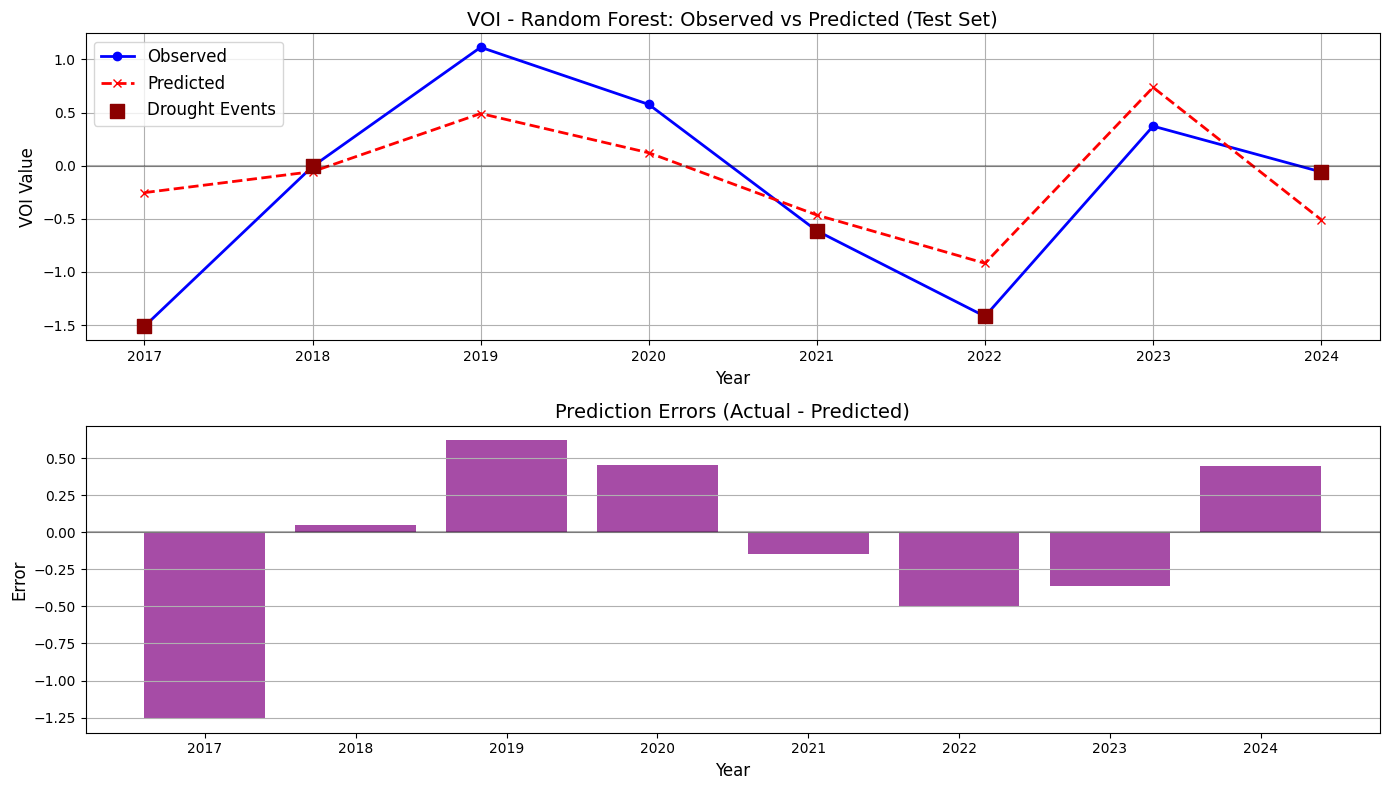


Analyzing models for station: MOYALE
  Random Forest: R² = 0.5600, RMSE = 0.5809
  Gradient Boosting: R² = 0.2287, RMSE = 0.7692
  SVR: R² = 0.0294, RMSE = 0.8629
  Neural Network: R² = -0.0188, RMSE = 0.8840

✅ Best model for MOYALE: Random Forest
  R² = 0.5600
  RMSE = 0.5809
  MAE = 0.4463


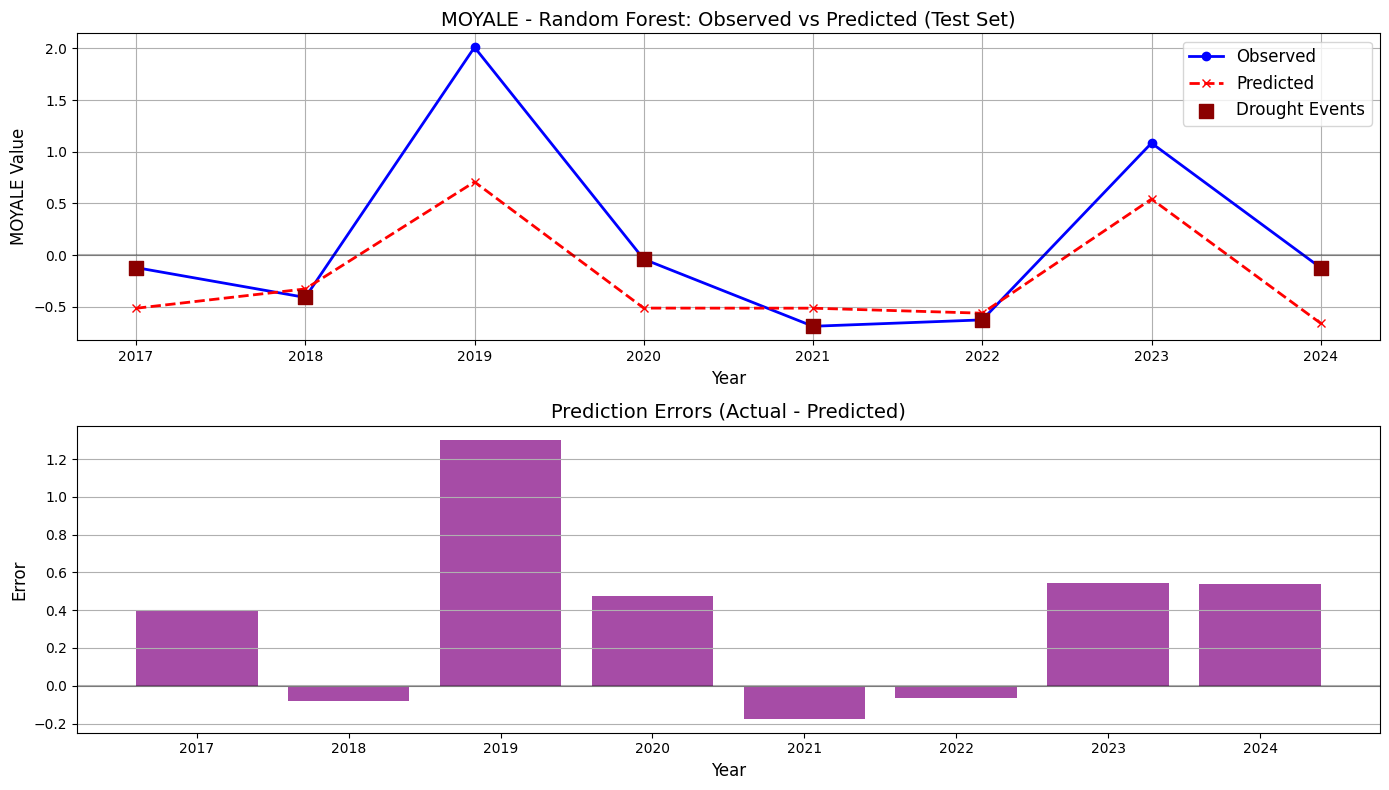


Analyzing models for station: LODWAR
  Random Forest: R² = 0.4785, RMSE = 0.5819
  Gradient Boosting: R² = 0.0576, RMSE = 0.7823
  SVR: R² = 0.0927, RMSE = 0.7676
  Neural Network: R² = -16.9884, RMSE = 3.4178

✅ Best model for LODWAR: Random Forest
  R² = 0.4785
  RMSE = 0.5819
  MAE = 0.4775


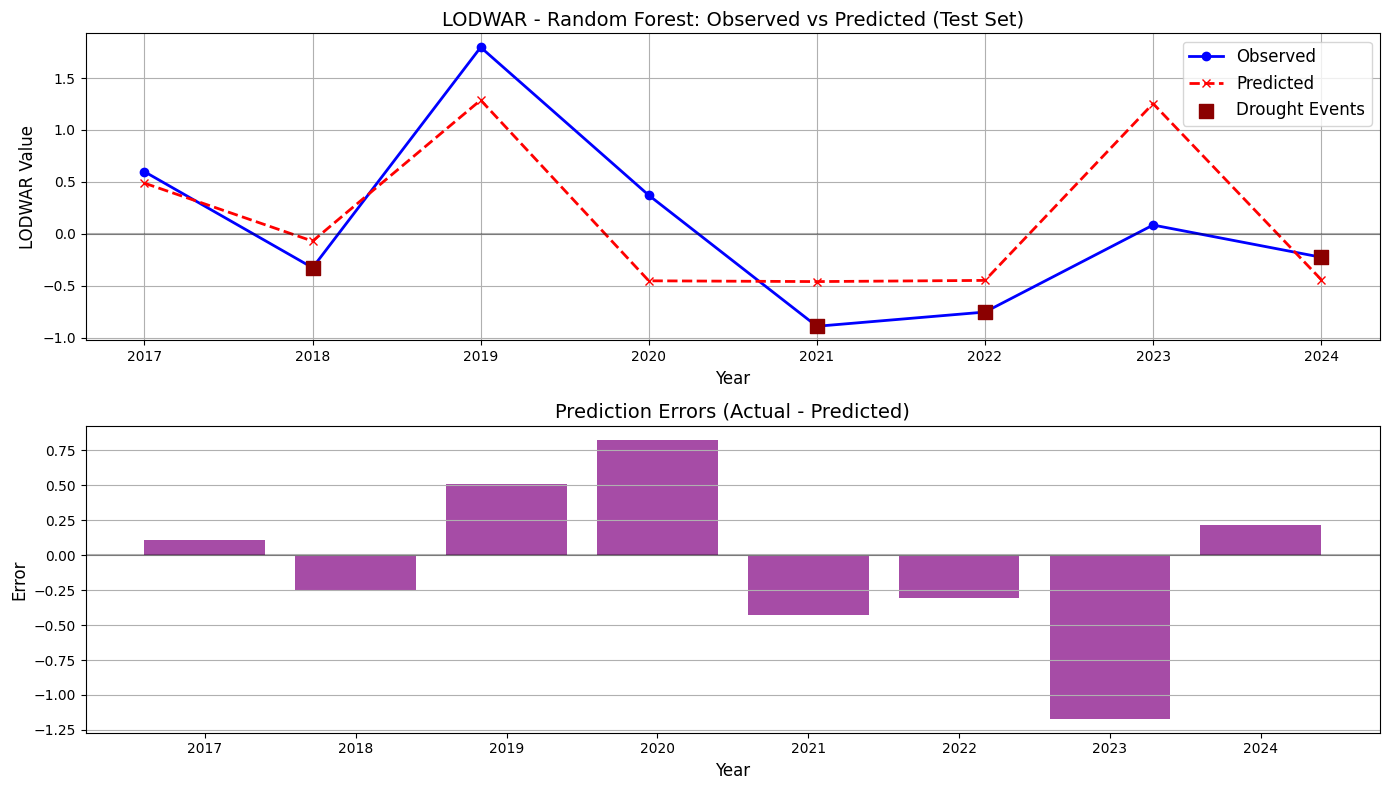


Analyzing models for station: LAMU
  Random Forest: R² = 0.5754, RMSE = 1.0642
  Gradient Boosting: R² = 0.1544, RMSE = 1.5018
  SVR: R² = -0.0109, RMSE = 1.6420
  Neural Network: R² = 0.3018, RMSE = 1.3646

✅ Best model for LAMU: Random Forest
  R² = 0.5754
  RMSE = 1.0642
  MAE = 0.8268


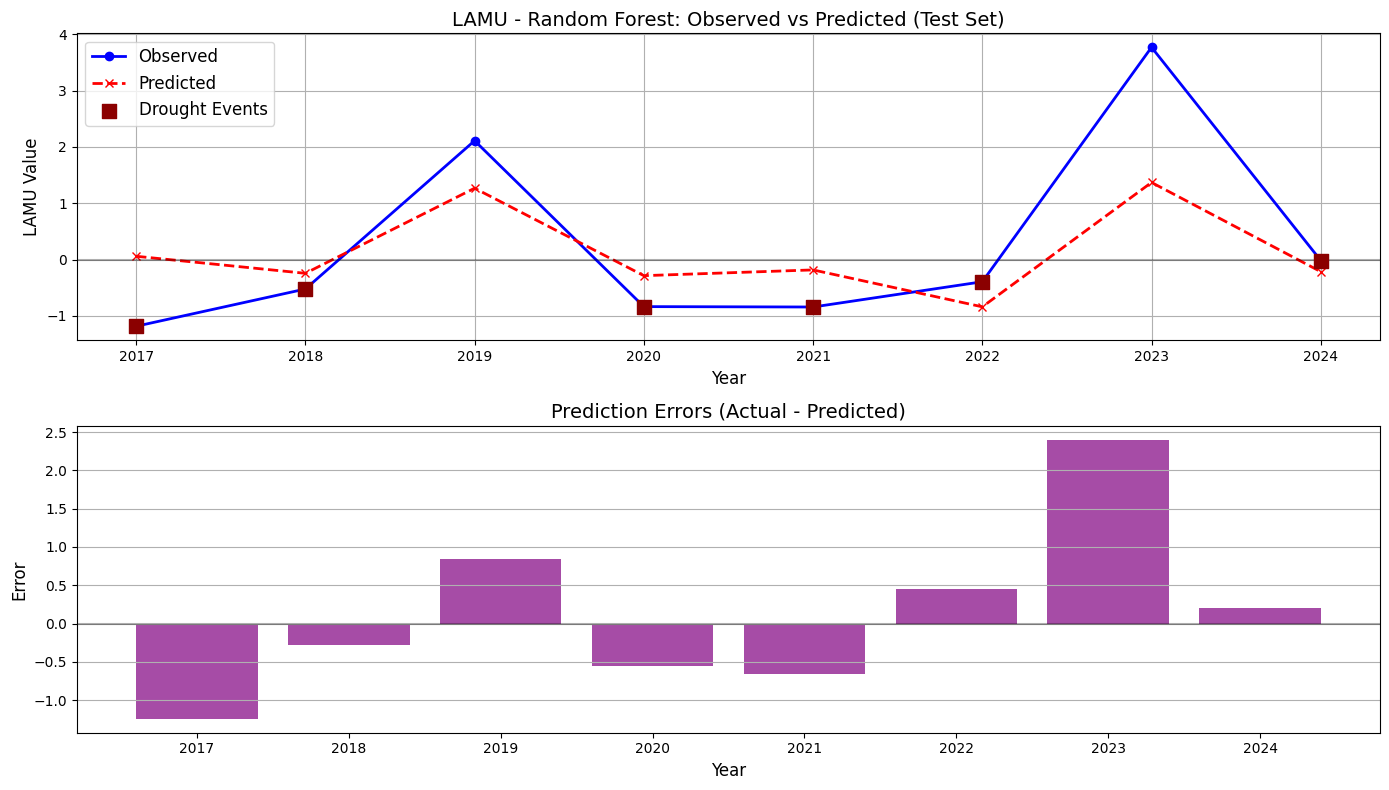


Analyzing models for station: GARISSA
  Random Forest: R² = -0.2846, RMSE = 1.2880
  Gradient Boosting: R² = -0.0950, RMSE = 1.1891
  SVR: R² = -0.6696, RMSE = 1.4683
  Neural Network: R² = -0.8365, RMSE = 1.5400

✅ Best model for GARISSA: Gradient Boosting
  R² = -0.0950
  RMSE = 1.1891
  MAE = 0.8911


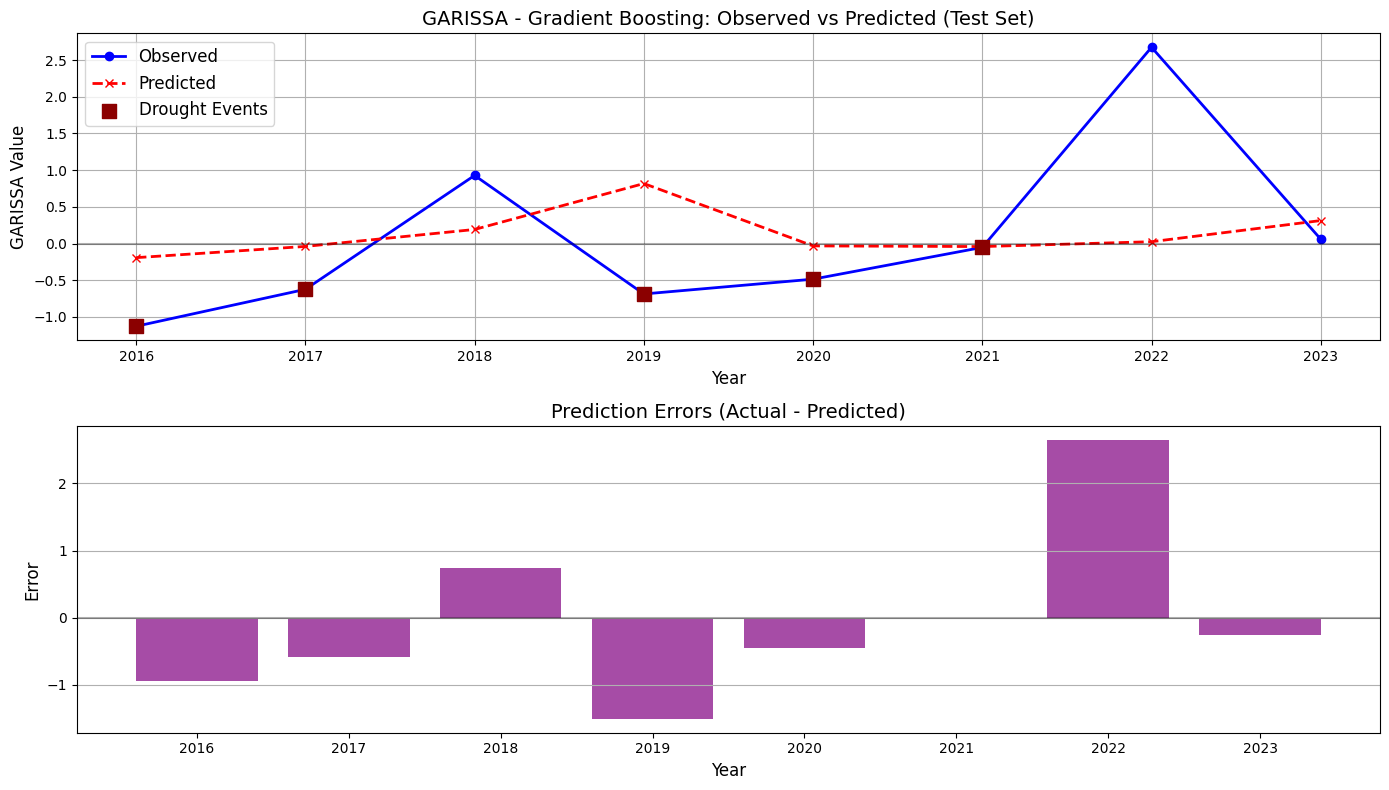


Analyzing models for station: WAJIR
  Random Forest: R² = 0.7792, RMSE = 0.6634
  Gradient Boosting: R² = 0.0944, RMSE = 1.3435
  SVR: R² = -0.2129, RMSE = 1.5548
  Neural Network: R² = 0.5746, RMSE = 0.9208

✅ Best model for WAJIR: Random Forest
  R² = 0.7792
  RMSE = 0.6634
  MAE = 0.5929


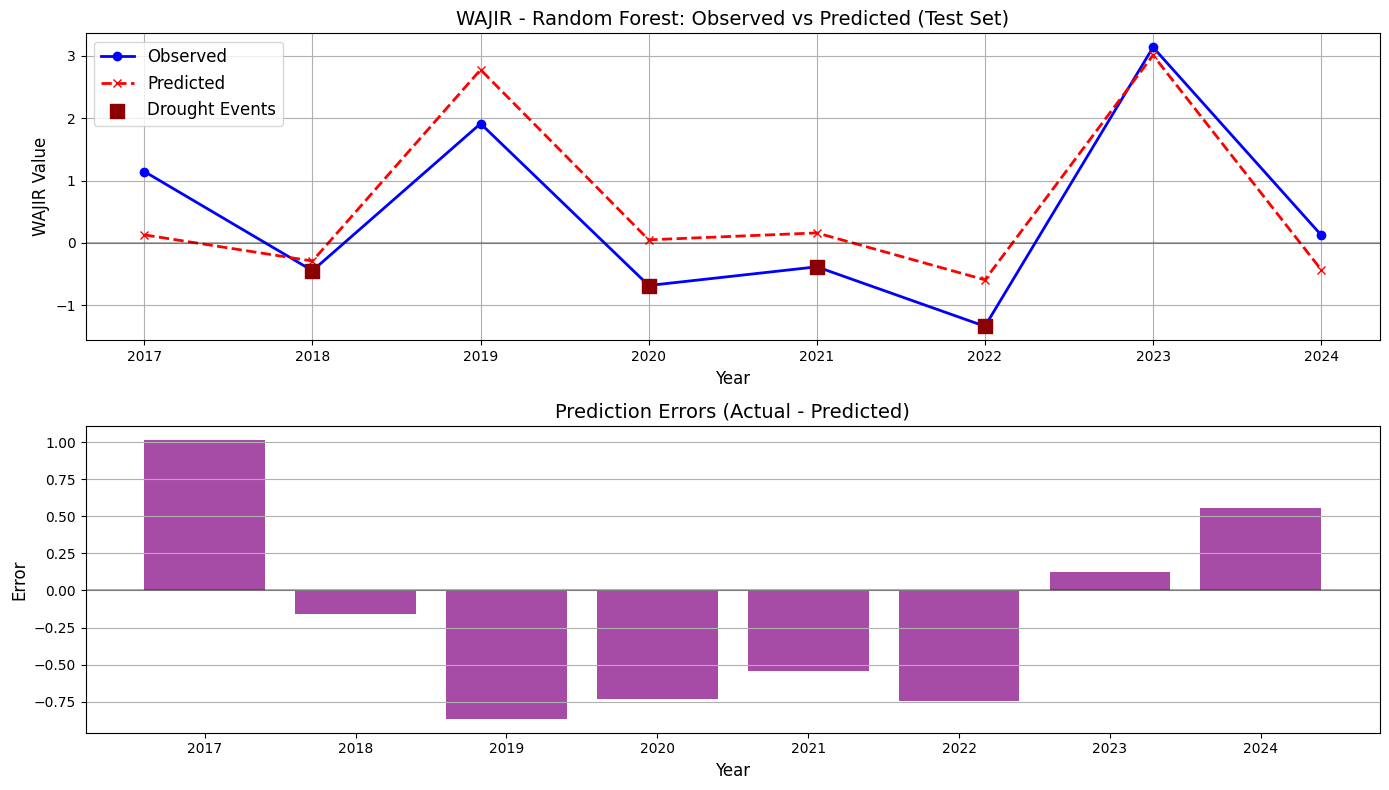


Analyzing models for station: MOMBASA
  Random Forest: R² = 0.6480, RMSE = 0.6971
  Gradient Boosting: R² = 0.0738, RMSE = 1.1309
  SVR: R² = -0.2193, RMSE = 1.2975
  Neural Network: R² = 0.9527, RMSE = 0.2556

✅ Best model for MOMBASA: Neural Network
  R² = 0.9527
  RMSE = 0.2556
  MAE = 0.2251


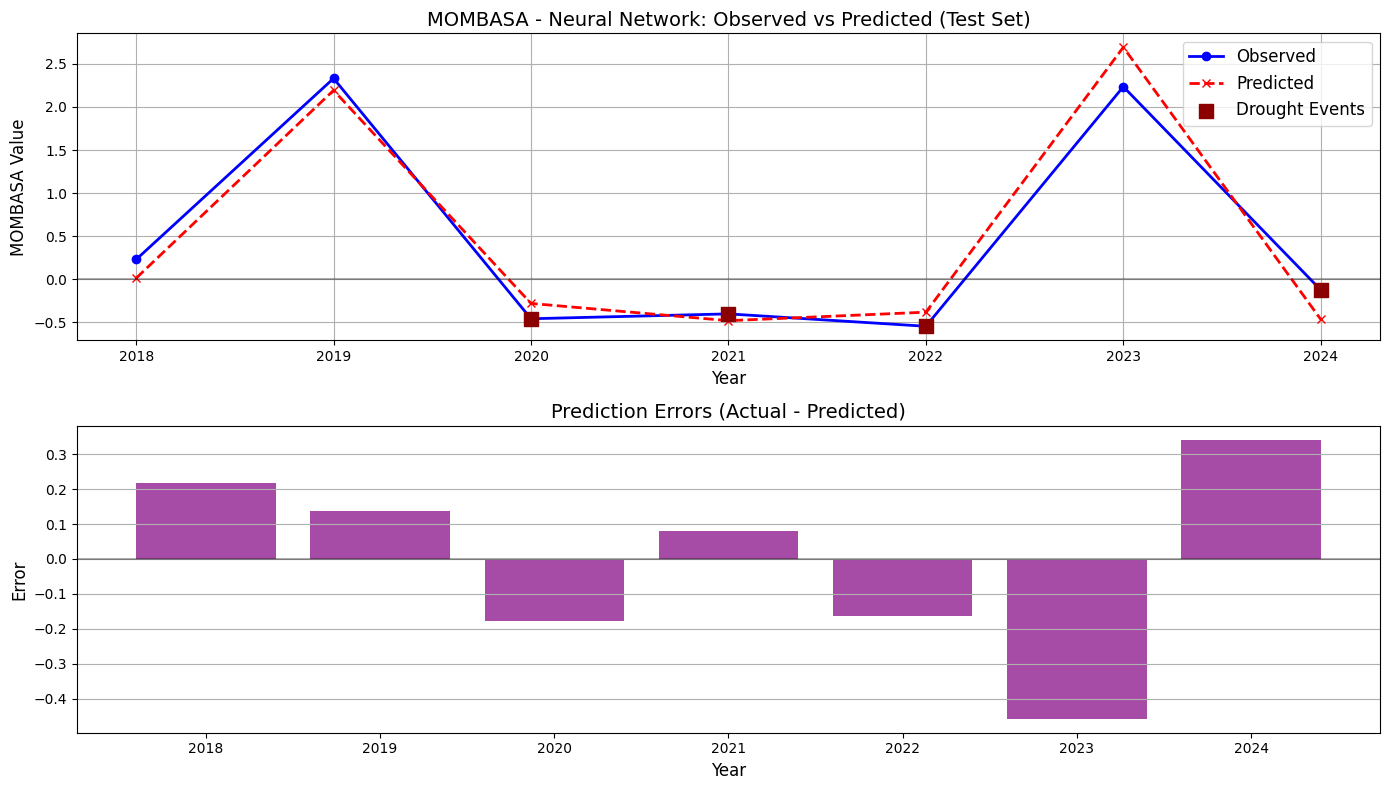


SUMMARY OF BEST MODELS FOR EACH STATION
Station        Best Model        R2     RMSE      MAE  Below Zero RMSE                                                                 Features Used
    VOI     Random Forest  0.542245 0.590208 0.480896         0.641542              N34, rolling_mean_3yr, IODW, rolling_std_3yr, N4, la_nina_weight
 MOYALE     Random Forest  0.560044 0.580921 0.446334         0.343898                         IODW, IODE, rolling_mean_3yr, N34, N4, la_nina_weight
 LODWAR     Random Forest  0.478542 0.581911 0.477479         0.312356 IODW, IODE, rolling_mean_3yr, rolling_std_3yr, el_nino_weight, la_nina_weight
   LAMU     Random Forest  0.575411 1.064169 0.826794         0.657583              IODW, N34, N4, rolling_mean_3yr, rolling_std_3yr, la_nina_weight
GARISSA Gradient Boosting -0.095026 1.189126 0.891116         0.858575     IODE, IODW, rolling_mean_3yr, rolling_std_3yr, is_el_nino, la_nina_weight
  WAJIR     Random Forest  0.779191 0.663384 0.592888         0.5

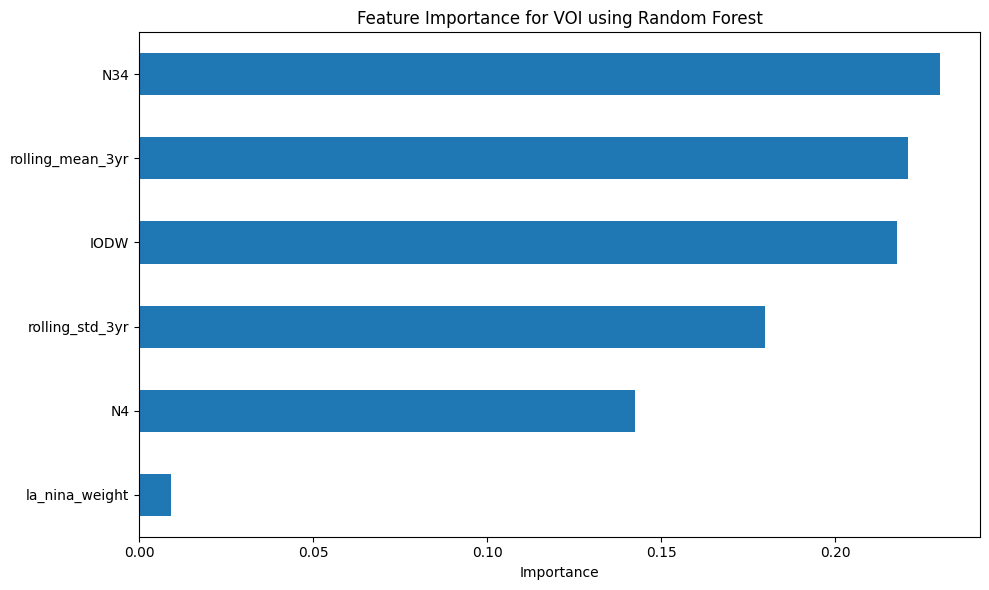


MOYALE - Feature Importance:
  IODW: 0.3594
  IODE: 0.2203
  rolling_mean_3yr: 0.1944
  N34: 0.1321
  N4: 0.0910
  la_nina_weight: 0.0028


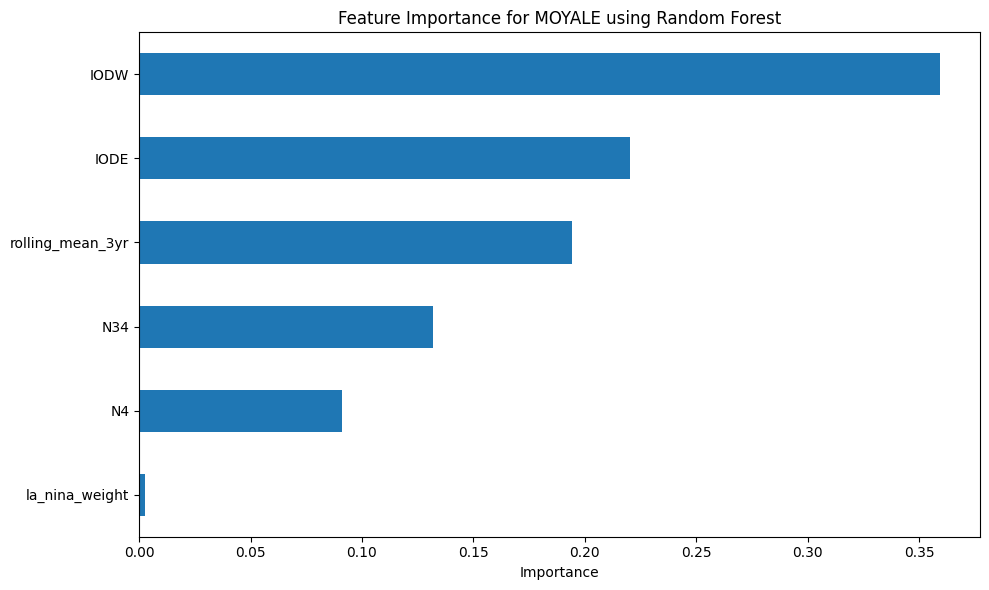


LODWAR - Feature Importance:
  IODW: 0.4013
  IODE: 0.2787
  rolling_mean_3yr: 0.1541
  rolling_std_3yr: 0.1462
  el_nino_weight: 0.0110
  la_nina_weight: 0.0088


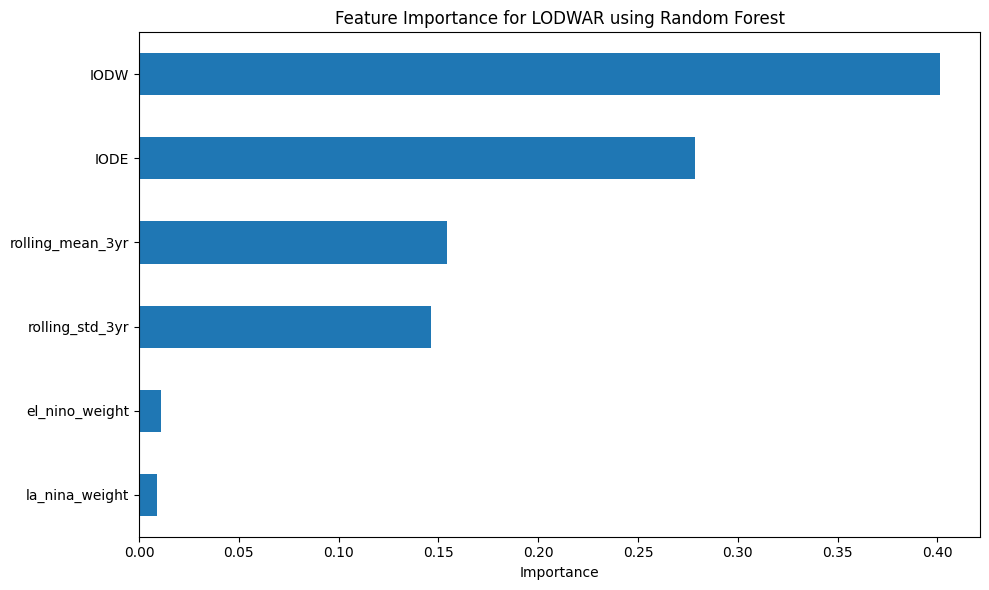


LAMU - Feature Importance:
  IODW: 0.3738
  N34: 0.2256
  N4: 0.2111
  rolling_mean_3yr: 0.0983
  rolling_std_3yr: 0.0896
  la_nina_weight: 0.0016


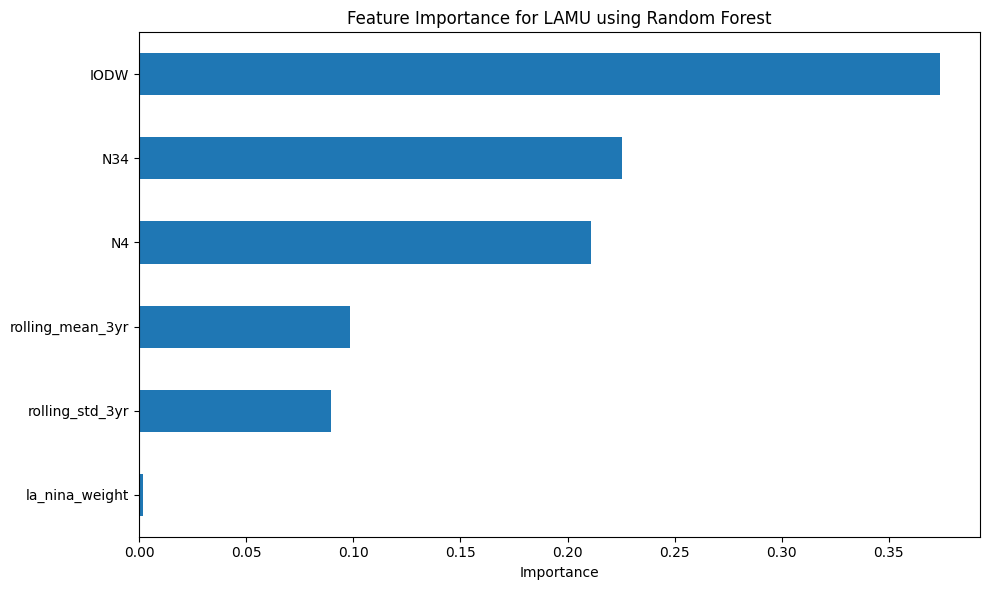


WAJIR - Feature Importance:
  IODW: 0.3798
  N34: 0.2454
  N4: 0.1301
  IODE: 0.1258
  el_nino_weight: 0.1168
  la_nina_weight: 0.0021


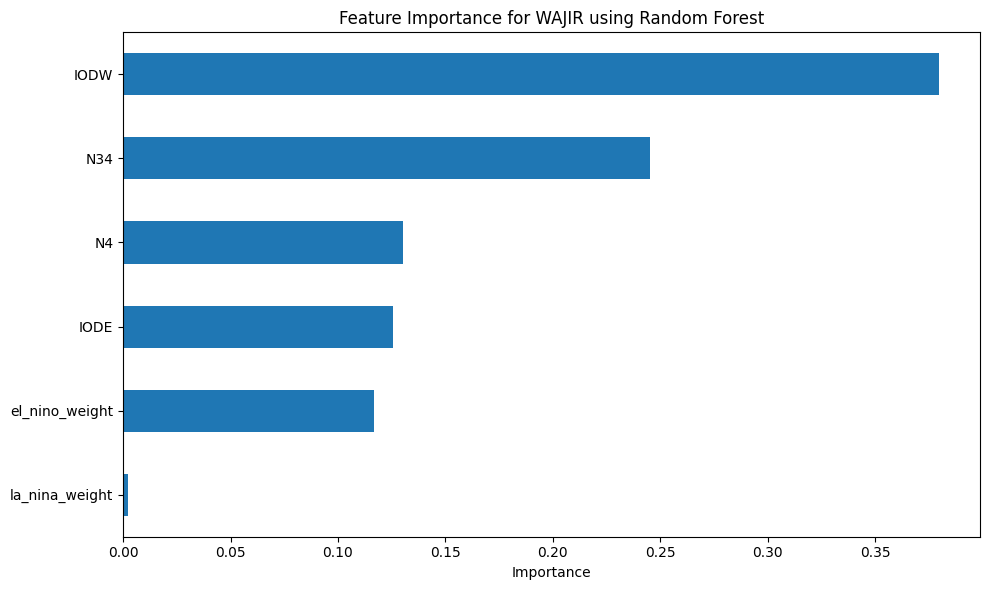

MOMBASA - Neural Network: Feature importance not available for this model type


In [5]:
# MODEL SUMMARY AND VISUALIZATION
best_models_summary = pd.DataFrame(columns=[
    'Station', 'Best Model', 'R2', 'RMSE', 'MAE', 'Below Zero RMSE', 'Features Used'
])

forecasting_dfs = {}

print("\n" + "="*70)
print("BEST MODEL SELECTION SUMMARY")
print("="*70)

for station, models_dict in results_dict.items():
    print(f"\nAnalyzing models for station: {station}")
    
    best_model_name = None
    best_r2 = float('-inf')
    best_metrics = {}

    # Find the model with the highest R² value from the results_dict
    for model_name, metrics in models_dict.items():
        r2 = metrics['r2']
        print(f"  {model_name}: R² = {r2:.4f}, RMSE = {metrics['rmse']:.4f}")
        
        if r2 > best_r2:
            best_r2 = r2
            best_model_name = model_name
            best_metrics = metrics
    
    if best_model_name:
        try:
            print(f"\n✅ Best model for {station}: {best_model_name}")
            print(f"  R² = {best_r2:.4f}")
            print(f"  RMSE = {best_metrics['rmse']:.4f}")
            print(f"  MAE = {best_metrics['mae']:.4f}")
            
            # Get the original dataframe for this station
            station_df = filtered_sheet_dict[station].copy()
            
            # Get the top features used for this station - these should match what was used in model training
            # Important: Use the same feature selection process as in your model training
            feature_columns = [col for col in station_df.columns if col != 'YEAR' and col != station]
            
            # Apply the same feature engineering as in the training process
            df = station_df.copy()
            
            # Add El Niño and La Niña indicators and weights
            el_nino_years = [1961, 1997, 2013, 2019, 2023]
            la_nina_years = [1988, 1998, 2007, 2010, 2016, 2020]
            
            df['is_el_nino'] = df['YEAR'].apply(lambda x: 1 if x in el_nino_years else 0)
            df['is_la_nina'] = df['YEAR'].apply(lambda x: 1 if x in la_nina_years else 0)
            df['recent_strong_el_nino'] = df['YEAR'].apply(lambda x: 2 if x in [2019, 2023] else (1 if x == 2013 else 0))
            df['recent_strong_la_nina'] = df['YEAR'].apply(lambda x: 2 if x in [2016, 2020] else (1 if x == 2010 else 0))
            df['el_nino_weight'] = df['is_el_nino'] * (1 + df['recent_strong_el_nino'] * 1.0)
            df['la_nina_weight'] = df['is_la_nina'] * (1 + df['recent_strong_la_nina'] * 1.0)
            
            # Add rolling statistics as we did in model training
            df = df.sort_values('YEAR')
            rainfall_col = station
            if len(df) > 3:
                df['rolling_mean_3yr'] = df[rainfall_col].rolling(window=3, min_periods=1).mean().shift(1)
                df['rolling_std_3yr'] = df[rainfall_col].rolling(window=3, min_periods=1).std().shift(1)
                df['rolling_mean_3yr'] = df['rolling_mean_3yr'].fillna(df[rainfall_col].mean())
                df['rolling_std_3yr'] = df['rolling_std_3yr'].fillna(df[rainfall_col].std())
            
            # Select top features using Random Forest (same process as in model training)
            X = df[[col for col in df.columns if col != 'YEAR' and col != station]]
            y = df[station]
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X, y)
            importances = pd.Series(rf.feature_importances_, index=X.columns)
            top_features = importances.nlargest(6).index.tolist()
            
            # Make sure El Niño and La Niña indicators are considered
            enso_features = ['el_nino_weight', 'la_nina_weight']
            for feature in enso_features:
                if feature not in top_features and feature in X.columns:
                    if len(top_features) >= 6:
                        top_features = top_features[:5] + [feature]
                    else:
                        top_features.append(feature)
            
            # Calculate Below Zero RMSE (for drought conditions)
            below_zero_indices = np.where(best_metrics['actuals'] < 0)[0]
            if len(below_zero_indices) > 0:
                below_zero_rmse = np.sqrt(mean_squared_error(
                    [best_metrics['actuals'][i] for i in below_zero_indices],
                    [best_metrics['predictions'][i] for i in below_zero_indices]
                ))
            else:
                below_zero_rmse = None
                
            features_str = ', '.join(top_features)
            
            # Add to summary DataFrame
            best_models_summary = pd.concat([
                best_models_summary,
                pd.DataFrame({
                    'Station': [station],
                    'Best Model': [best_model_name],
                    'R2': [best_r2],
                    'RMSE': [best_metrics['rmse']],
                    'MAE': [best_metrics['mae']],
                    'Below Zero RMSE': [below_zero_rmse],
                    'Features Used': [features_str]
                })
            ], ignore_index=True)
            
            # Store the dataframe with the best model predictions for forecasting
            forecasting_dfs[station] = {
                'df': df,
                'model_name': best_model_name,
                'features': top_features,
                'target': station,
                'years': best_metrics['years'],
                'actuals': best_metrics['actuals'],
                'predictions': best_metrics['predictions'],
                'r2': best_r2,
                'rmse': best_metrics['rmse'],
                'mae': best_metrics['mae'],
                'below_zero_rmse': below_zero_rmse
            }

            # Plot observed vs predicted values
            years_test = best_metrics['years']
            y_test = best_metrics['actuals']
            y_pred = best_metrics['predictions']
            
            # Create a more informative visualization
            plt.figure(figsize=(14, 8))
            
            # Plot 1: Time series comparison
            plt.subplot(2, 1, 1)
            plt.plot(years_test, y_test, label="Observed", marker='o', color='blue', linewidth=2)
            plt.plot(years_test, y_pred, label="Predicted", linestyle='--', marker='x', color='red', linewidth=2)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.title(f"{station} - {best_model_name}: Observed vs Predicted (Test Set)", fontsize=14)
            plt.xlabel("Year", fontsize=12)
            plt.ylabel(f"{station} Value", fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True)
            
            # Highlight drought periods (values below zero)
            drought_years = [years_test[i] for i, val in enumerate(y_test) if val < 0]
            drought_values = [y_test[i] for i, val in enumerate(y_test) if val < 0]
            if drought_years:
                plt.scatter(drought_years, drought_values, color='darkred', s=100, zorder=5, 
                            label='Drought Events', marker='s')
                plt.legend(fontsize=12)
            
            # Plot 2: Error analysis
            plt.subplot(2, 1, 2)
            errors = y_test - y_pred
            plt.bar(years_test, errors, color='purple', alpha=0.7)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.title("Prediction Errors (Actual - Predicted)", fontsize=14)
            plt.xlabel("Year", fontsize=12)
            plt.ylabel("Error", fontsize=12)
            plt.grid(True, axis='y')
            
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error handling best model for {station}: {str(e)}")
            
print("\n" + "="*80)
print("SUMMARY OF BEST MODELS FOR EACH STATION")
print("="*80)
print(best_models_summary.to_string(index=False))
print("="*80)

print("\nForecasting-ready dataframes are stored in 'forecasting_dfs'")
print("These can be used for future drought prediction and forecasting.")

# Feature importance for best models
print("\n" + "="*70)
print("FEATURE IMPORTANCE FOR BEST MODELS")
print("="*70)

for station, station_data in forecasting_dfs.items():
    model_name = station_data['model_name']
    
    # Skip models that don't support feature importance
    if model_name in ["SVR", "Neural Network"]:
        print(f"{station} - {model_name}: Feature importance not available for this model type")
        continue
    
    try:
        # Get feature importance
        features = station_data['features']
        df = station_data['df']
        
        # For Random Forest models, we can extract importance directly
        if model_name == "Random Forest":
            X = df[features]
            y = df[station]
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X, y)
            importances = pd.Series(rf.feature_importances_, index=features)
            
            print(f"\n{station} - Feature Importance:")
            for feature, importance in importances.sort_values(ascending=False).items():
                print(f"  {feature}: {importance:.4f}")
            
            # Visualize feature importance
            plt.figure(figsize=(10, 6))
            importances.sort_values().plot(kind='barh')
            plt.title(f'Feature Importance for {station} using {model_name}')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
    
    except Exception as e:
        print(f"Error extracting feature importance for {station}: {str(e)}")



DROUGHT FORECASTING CONTINGENCY TABLE ANALYSIS WITH MANUAL THRESHOLDS

Analyzing contingency tables for station: VOI
  Using manual threshold for VOI:
    Drought Threshold: -0.440700

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               2 |               1
    Forecast: No    |               1 |               4

    Verification Metrics:
    Hit Rate (POD): 0.6667
    False Alarm Ratio: 0.3333
    Bias: 1.0000
    Accuracy: 0.7500
    Heidke Skill Score: 0.4667


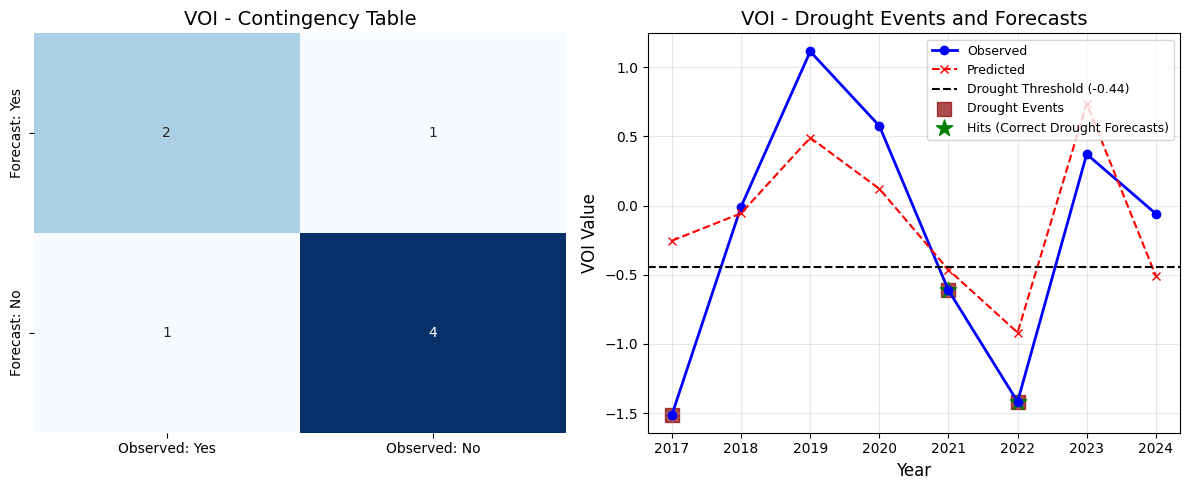


Analyzing contingency tables for station: MOYALE
  Using manual threshold for MOYALE:
    Drought Threshold: -0.321000

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               3 |               3
    Forecast: No    |               0 |               2

    Verification Metrics:
    Hit Rate (POD): 1.0000
    False Alarm Ratio: 0.5000
    Bias: 2.0000
    Accuracy: 0.6250
    Heidke Skill Score: 0.3333


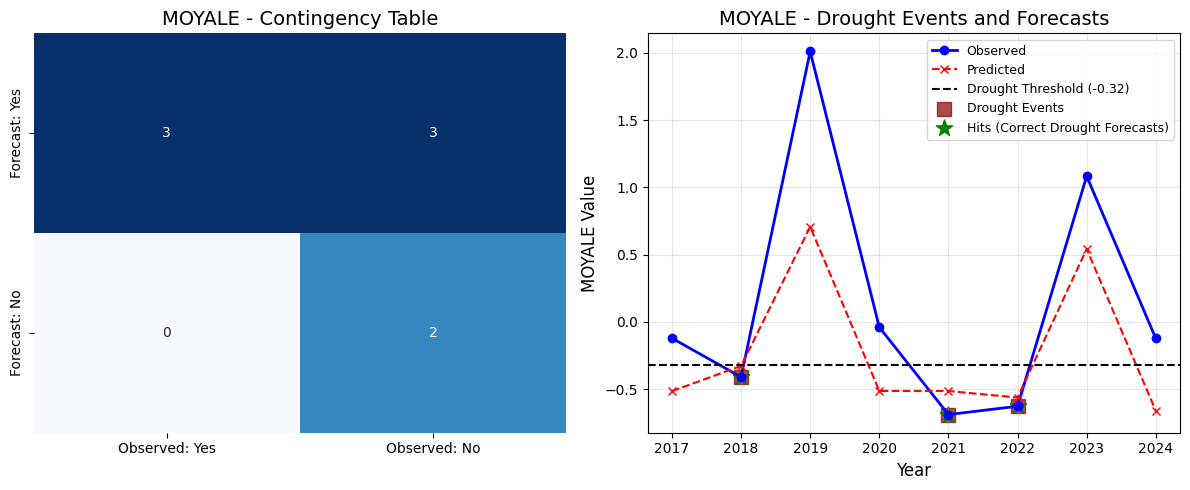


Analyzing contingency tables for station: LODWAR
  Using manual threshold for LODWAR:
    Drought Threshold: -0.295832

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               2 |               2
    Forecast: No    |               1 |               3

    Verification Metrics:
    Hit Rate (POD): 0.6667
    False Alarm Ratio: 0.5000
    Bias: 1.3333
    Accuracy: 0.6250
    Heidke Skill Score: 0.2500


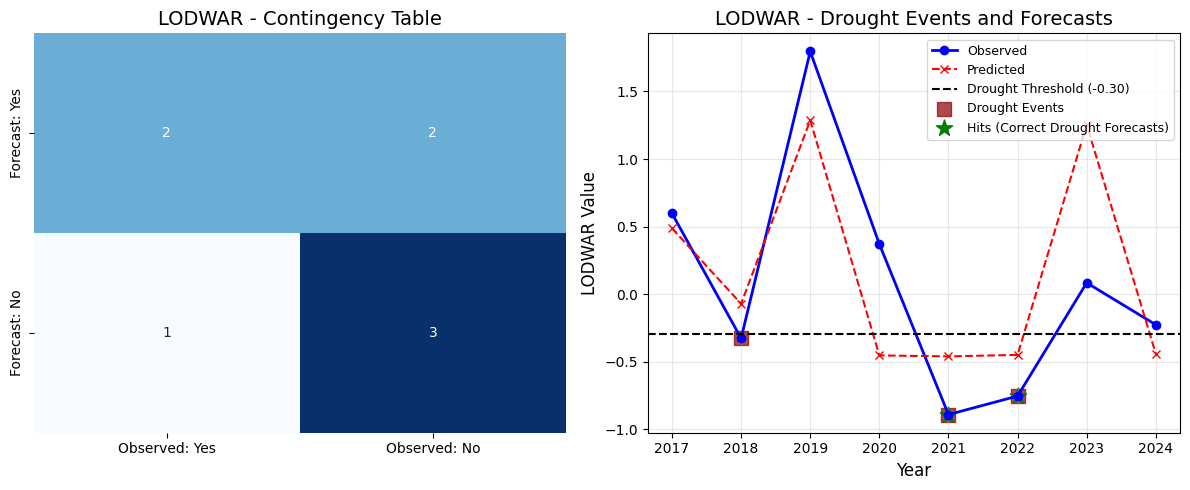


Analyzing contingency tables for station: LAMU
  Using manual threshold for LAMU:
    Drought Threshold: -0.374220

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               1 |               0
    Forecast: No    |               4 |               3

    Verification Metrics:
    Hit Rate (POD): 0.2000
    False Alarm Ratio: 0.0000
    Bias: 0.2000
    Accuracy: 0.5000
    Heidke Skill Score: 0.1579


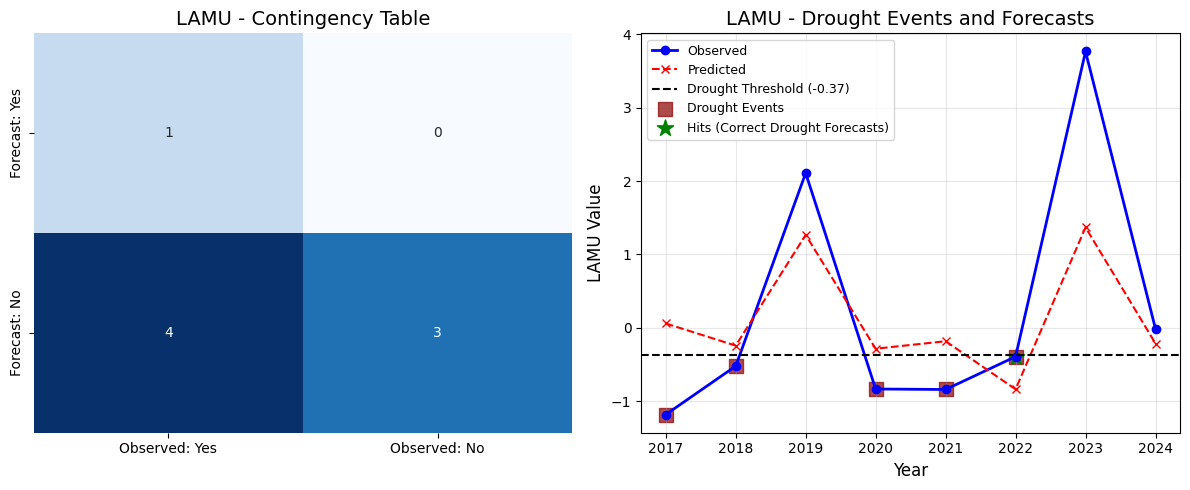


Analyzing contingency tables for station: GARISSA
  Using manual threshold for GARISSA:
    Drought Threshold: -0.456678

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               0 |               0
    Forecast: No    |               4 |               4

    Verification Metrics:
    Hit Rate (POD): 0.0000
    False Alarm Ratio: 0.0000
    Bias: 0.0000
    Accuracy: 0.5000
    Heidke Skill Score: 0.0000


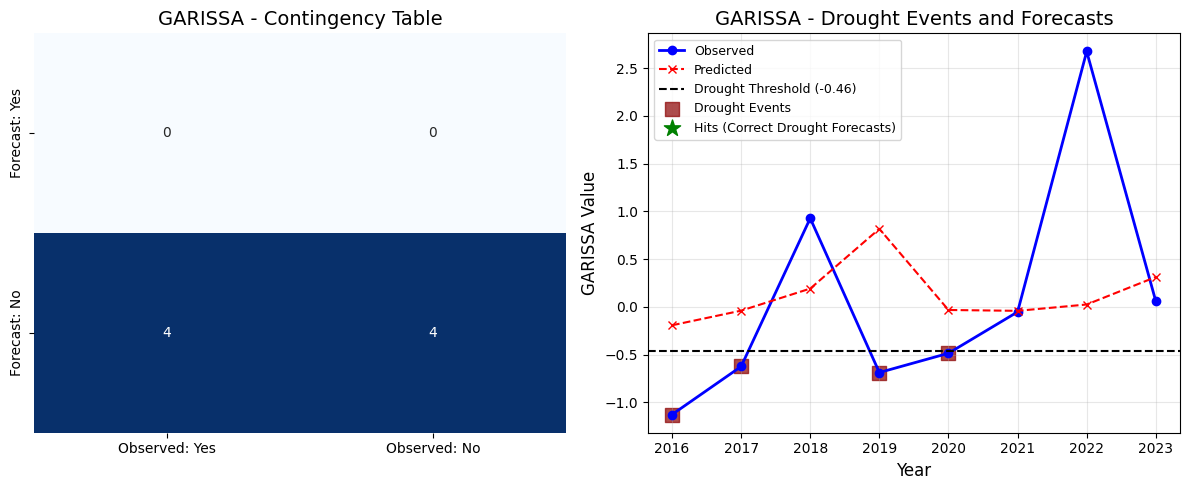


Analyzing contingency tables for station: WAJIR
  Using manual threshold for WAJIR:
    Drought Threshold: -0.427258

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               1 |               1
    Forecast: No    |               2 |               4

    Verification Metrics:
    Hit Rate (POD): 0.3333
    False Alarm Ratio: 0.5000
    Bias: 0.6667
    Accuracy: 0.6250
    Heidke Skill Score: 0.1429


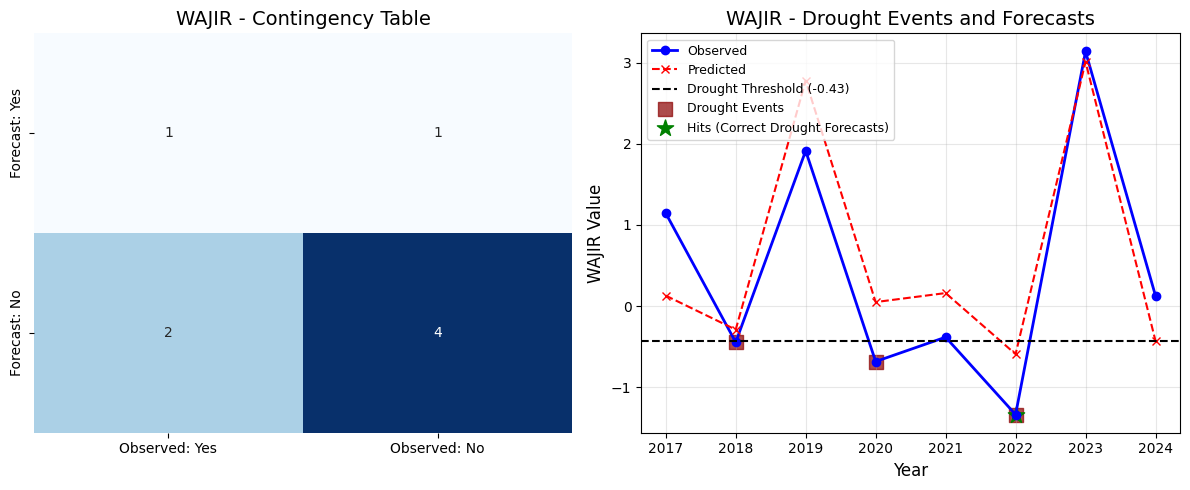


Analyzing contingency tables for station: MOMBASA
  Using manual threshold for MOMBASA:
    Drought Threshold: 0.268120

    Contingency Table:
                    | Observed: Yes   | Observed: No   
    -----------------------------------------------------
    Forecast: Yes   |               5 |               0
    Forecast: No    |               0 |               2

    Verification Metrics:
    Hit Rate (POD): 1.0000
    False Alarm Ratio: 0.0000
    Bias: 1.0000
    Accuracy: 1.0000
    Heidke Skill Score: 1.0000


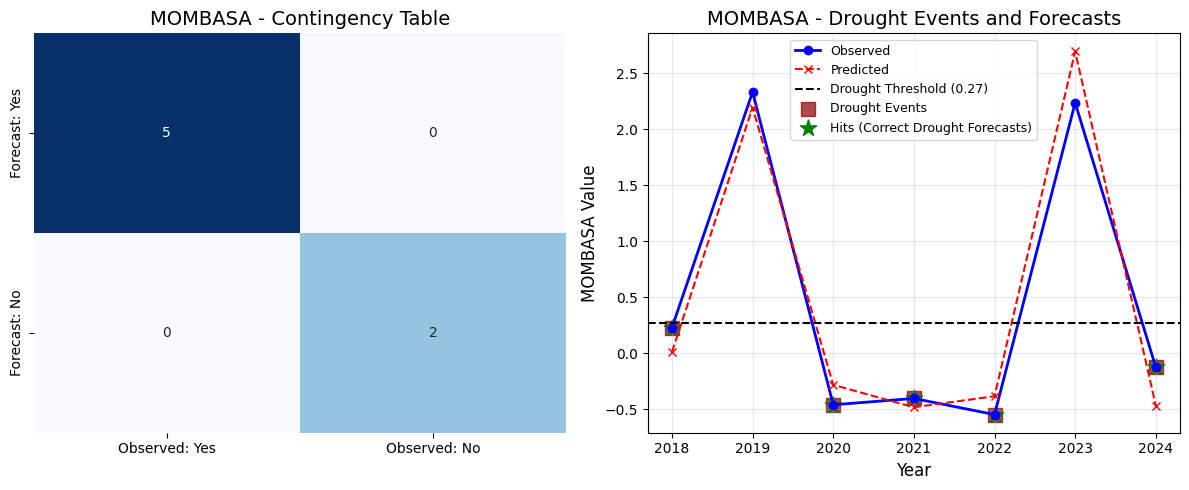


SUMMARY OF DROUGHT FORECASTING VERIFICATION
Station             Model  Drought Threshold  Hits  False Alarms  Misses  Correct Negatives  Hit Rate (POD)  False Alarm Ratio     Bias  Accuracy      HSS
    VOI     Random Forest          -0.440700     2             1       1                  4        0.666667           0.333333 1.000000     0.750 0.466667
 MOYALE     Random Forest          -0.321000     3             3       0                  2        1.000000           0.500000 2.000000     0.625 0.333333
 LODWAR     Random Forest          -0.295832     2             2       1                  3        0.666667           0.500000 1.333333     0.625 0.250000
   LAMU     Random Forest          -0.374220     1             0       4                  3        0.200000           0.000000 0.200000     0.500 0.157895
GARISSA Gradient Boosting          -0.456678     0             0       4                  4        0.000000           0.000000 0.000000     0.500 0.000000
  WAJIR     Random Forest

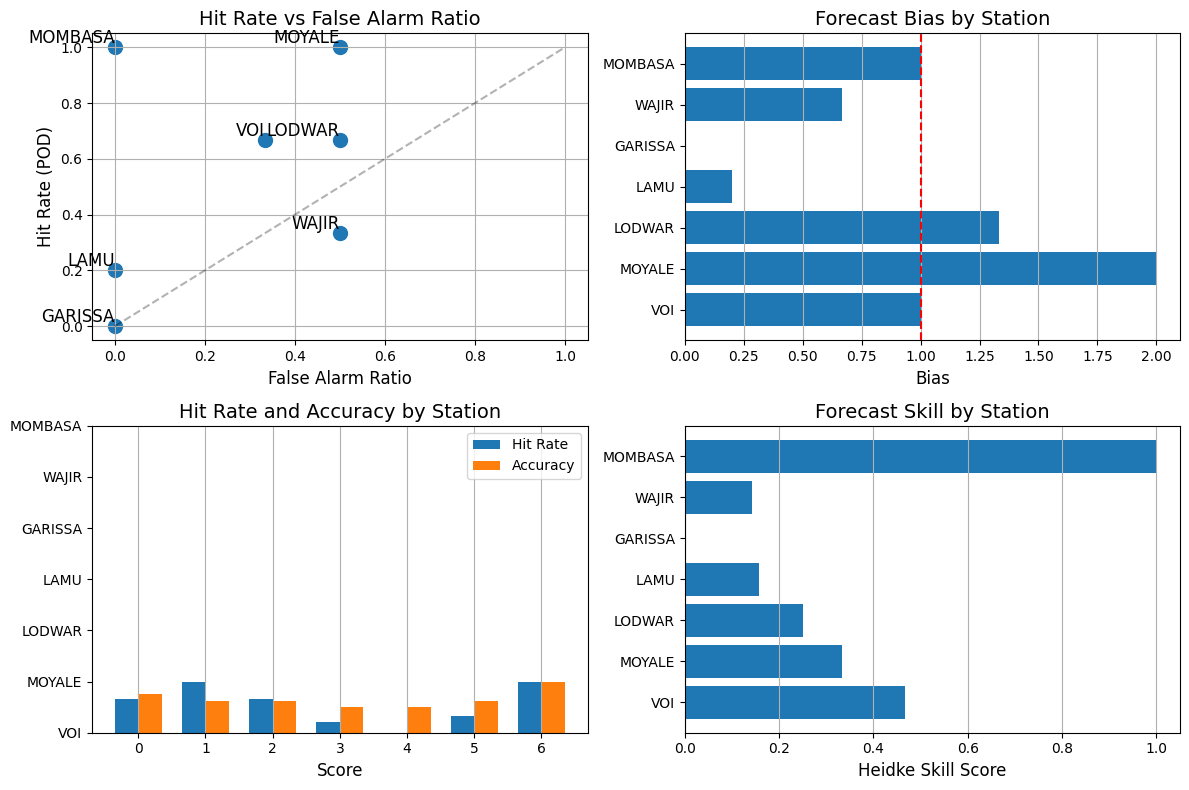


Contingency table analysis results saved to drought_forecast_verification.csv

CORRELATION BETWEEN REGRESSION METRICS AND CONTINGENCY TABLE METRICS
                      R2   RMSE    MAE  Hit Rate (POD)  False Alarm Ratio   Bias  Accuracy    HSS
R2                 1.000 -0.779 -0.728           0.623              0.195  0.398     0.681  0.686
RMSE              -0.779  1.000  0.992          -0.900             -0.373 -0.710    -0.872 -0.829
MAE               -0.728  0.992  1.000          -0.936             -0.325 -0.737    -0.882 -0.858
Hit Rate (POD)     0.623 -0.900 -0.936           1.000              0.357  0.880     0.735  0.774
False Alarm Ratio  0.195 -0.373 -0.325           0.357              1.000  0.691    -0.091 -0.195
Bias               0.398 -0.710 -0.737           0.880              0.691  1.000     0.360  0.382
Accuracy           0.681 -0.872 -0.882           0.735             -0.091  0.360     1.000  0.970
HSS                0.686 -0.829 -0.858           0.774             

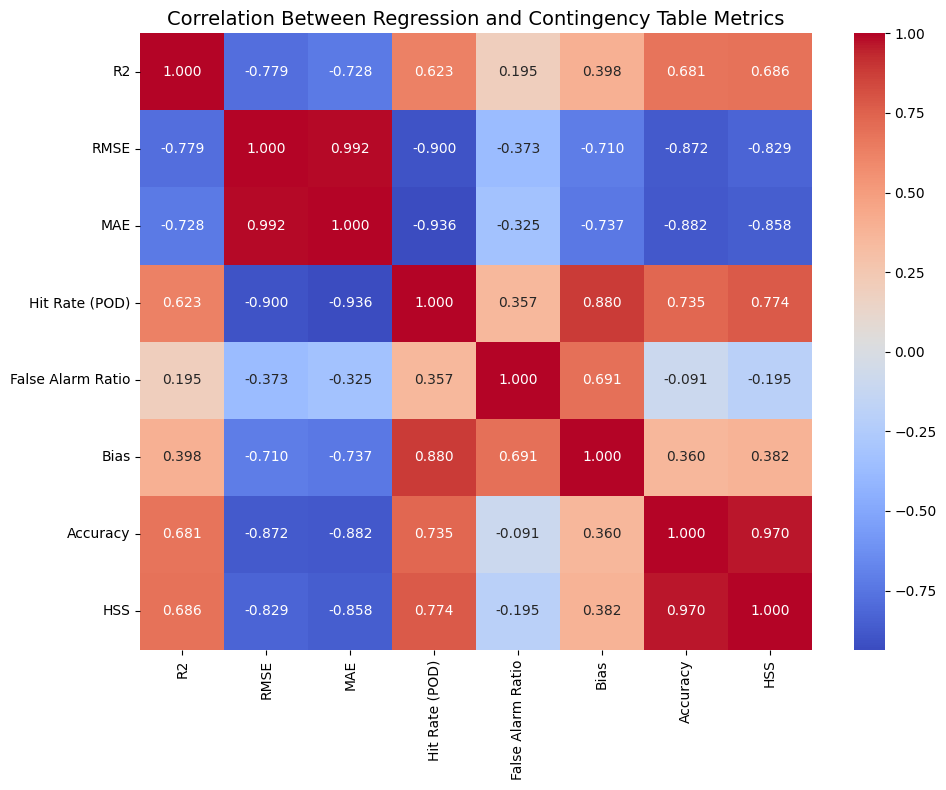


Analysis complete. Drought forecasting evaluated using manual thresholds and contingency table verification metrics.


In [13]:
#HITS AND MISSES 

def create_contingency_table(actuals, predictions, drought_threshold):
    """
    Create a 2x2 contingency table for drought forecasts
    
    Returns:
        contingency_table: 2x2 numpy array with format:
            [[hits, false_alarms],
             [misses, correct_negatives]]
        metrics: Dictionary of verification metrics
    """
    # Identify drought events
    actual_droughts = actuals <= drought_threshold
    predicted_droughts = predictions <= drought_threshold
    
    # Calculate contingency table elements
    hits = np.sum((actual_droughts) & (predicted_droughts))  # True Positives
    false_alarms = np.sum((~actual_droughts) & (predicted_droughts))  # False Positives
    misses = np.sum((actual_droughts) & (~predicted_droughts))  # False Negatives
    correct_negatives = np.sum((~actual_droughts) & (~predicted_droughts))  # True Negatives
    
    # Assemble contingency table
    contingency_table = np.array([
        [hits, false_alarms],
        [misses, correct_negatives]
    ])
    
    # Calculate total counts
    total = hits + false_alarms + misses + correct_negatives
    total_observed_yes = hits + misses
    total_observed_no = false_alarms + correct_negatives
    total_forecast_yes = hits + false_alarms
    total_forecast_no = misses + correct_negatives
    
    # Calculate metrics (handling division by zero)
    metrics = {}
    
    # Hit Rate / Probability of Detection (POD)
    metrics['hit_rate'] = hits / total_observed_yes if total_observed_yes > 0 else 0
    
    # False Alarm Ratio (FAR)
    metrics['false_alarm_ratio'] = false_alarms / total_forecast_yes if total_forecast_yes > 0 else 0
    
    # Bias
    metrics['bias'] = total_forecast_yes / total_observed_yes if total_observed_yes > 0 else 0
    
    # Accuracy
    metrics['accuracy'] = (hits + correct_negatives) / total if total > 0 else 0
    
    # Heidke Skill Score (HSS)
    exp_correct = ((hits + misses) * (hits + false_alarms) + (correct_negatives + misses) * (correct_negatives + false_alarms)) / total if total > 0 else 0
    metrics['heidke_skill_score'] = (hits + correct_negatives - exp_correct) / (total - exp_correct) if (total - exp_correct) != 0 else 0
    
    return contingency_table, metrics

print("\n" + "="*70)
print("DROUGHT FORECASTING CONTINGENCY TABLE ANALYSIS WITH MANUAL THRESHOLDS")
print("="*70)

# Define manual thresholds for each station
manual_thresholds = {
    'voi': -0.4407,
    'moyale': -0.3210,
    'lodwar': -0.295832,
    'garissa': -0.456678,
    'wajir': -0.4272579,
    'mombasa': 0.26812,
    'lamu': -0.37422
}

# Store contingency table results
contingency_results = {}

# We'll use the forecasting_dfs dictionary that was created in the previous cell
for station, station_data in forecasting_dfs.items():
    print(f"\nAnalyzing contingency tables for station: {station}")
    
    # Extract actuals and predictions
    years = station_data['years']
    actuals = station_data['actuals']
    predictions = station_data['predictions']
    model_name = station_data['model_name']
    
    # Use the manual threshold for this station
    drought_threshold = manual_thresholds.get(station.lower(), 0)  # Default to 0 if station not found
    
    # Create contingency table and calculate metrics
    contingency_table, metrics = create_contingency_table(
        actuals, predictions, drought_threshold
    )
    
    # Store results
    result_entry = {
        'drought_threshold': drought_threshold,
        'contingency_table': contingency_table,
        'hits': contingency_table[0, 0],
        'false_alarms': contingency_table[0, 1],
        'misses': contingency_table[1, 0],
        'correct_negatives': contingency_table[1, 1],
        **metrics
    }
    
    # Store results for this station
    contingency_results[station] = {
        'best_config': result_entry,
        'model_name': model_name
    }
    
    # Print results for the manual threshold
    print(f"  Using manual threshold for {station}:")
    print(f"    Drought Threshold: {drought_threshold:.6f}")
    
    # Print contingency table
    ct = contingency_table
    print("\n    Contingency Table:")
    print(f"    {'':15} | {'Observed: Yes':15} | {'Observed: No':15}")
    print(f"    {'-'*53}")
    print(f"    {'Forecast: Yes':15} | {ct[0,0]:15d} | {ct[0,1]:15d}")
    print(f"    {'Forecast: No':15} | {ct[1,0]:15d} | {ct[1,1]:15d}")
    
    # Print verification metrics
    print("\n    Verification Metrics:")
    print(f"    Hit Rate (POD): {metrics['hit_rate']:.4f}")
    print(f"    False Alarm Ratio: {metrics['false_alarm_ratio']:.4f}")
    print(f"    Bias: {metrics['bias']:.4f}")
    print(f"    Accuracy: {metrics['accuracy']:.4f}")
    print(f"    Heidke Skill Score: {metrics['heidke_skill_score']:.4f}")
    
    # Visualize contingency table
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Contingency table as heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Observed: Yes', 'Observed: No'],
                yticklabels=['Forecast: Yes', 'Forecast: No'])
    plt.title(f"{station} - Contingency Table", fontsize=14)
    
    # Plot 2: Time series with drought events highlighted
    plt.subplot(1, 2, 2)
    
    # Plot actual and predicted values
    plt.plot(years, actuals, label="Observed", marker='o', color='blue', linewidth=2)
    plt.plot(years, predictions, label="Predicted", linestyle='--', marker='x', color='red', linewidth=1.5)
    
    # Add drought threshold line
    plt.axhline(y=drought_threshold, color='black', linestyle='--', 
                label=f"Drought Threshold ({drought_threshold:.2f})")
    
    # Highlight hits (correctly predicted drought events)
    drought_mask = actuals <= drought_threshold
    correct_drought_mask = (actuals <= drought_threshold) & (predictions <= drought_threshold)
    
    # Highlight drought events
    plt.scatter(
        [years[i] for i in range(len(years)) if drought_mask[i]],
        [actuals[i] for i in range(len(years)) if drought_mask[i]],
        color='darkred', s=100, alpha=0.7, marker='s', label='Drought Events'
    )
    
    # Highlight hits
    plt.scatter(
        [years[i] for i in range(len(years)) if correct_drought_mask[i]],
        [actuals[i] for i in range(len(years)) if correct_drought_mask[i]],
        color='green', s=150, marker='*', label='Hits (Correct Drought Forecasts)'
    )
    
    plt.title(f"{station} - Drought Events and Forecasts", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel(f"{station} Value", fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create summary DataFrame
summary_rows = []
for station, results in contingency_results.items():
    best_config = results['best_config']
    
    summary_rows.append({
        'Station': station,
        'Model': results['model_name'],
        'Drought Threshold': best_config['drought_threshold'],
        'Hits': best_config['hits'],
        'False Alarms': best_config['false_alarms'],
        'Misses': best_config['misses'],
        'Correct Negatives': best_config['correct_negatives'],
        'Hit Rate (POD)': best_config['hit_rate'],
        'False Alarm Ratio': best_config['false_alarm_ratio'],
        'Bias': best_config['bias'],
        'Accuracy': best_config['accuracy'],
        'HSS': best_config['heidke_skill_score']
    })

# Convert to DataFrame and display
contingency_summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*80)
print("SUMMARY OF DROUGHT FORECASTING VERIFICATION")
print("="*80)
print(contingency_summary_df.to_string(index=False))
print("="*80)

# Now let's create a visualization that compares all stations
plt.figure(figsize=(12, 8))

# Plot 1: Hit Rate vs False Alarm Ratio
plt.subplot(2, 2, 1)
stations = contingency_summary_df['Station'].tolist()
hit_rates = contingency_summary_df['Hit Rate (POD)'].tolist()
false_alarm_ratios = contingency_summary_df['False Alarm Ratio'].tolist()

plt.scatter(false_alarm_ratios, hit_rates, s=100)
for i, station in enumerate(stations):
    plt.annotate(station, (false_alarm_ratios[i], hit_rates[i]), 
                fontsize=12, ha='right', va='bottom')
    
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # No skill line
plt.grid(True)
plt.xlabel('False Alarm Ratio', fontsize=12)
plt.ylabel('Hit Rate (POD)', fontsize=12)
plt.title('Hit Rate vs False Alarm Ratio', fontsize=14)

# Plot 2: Bias by station
plt.subplot(2, 2, 2)
biases = contingency_summary_df['Bias'].tolist()
y_pos = np.arange(len(stations))

bars = plt.barh(y_pos, biases, align='center')
plt.yticks(y_pos, stations)
plt.axvline(x=1.0, color='r', linestyle='--')
plt.xlabel('Bias', fontsize=12)
plt.title('Forecast Bias by Station', fontsize=14)
plt.grid(True, axis='x')

# Plot 3: Hit Rate and Accuracy by station
plt.subplot(2, 2, 3)
width = 0.35
accuracy = contingency_summary_df['Accuracy'].tolist()

plt.bar(y_pos - width/2, hit_rates, width, label='Hit Rate')
plt.bar(y_pos + width/2, accuracy, width, label='Accuracy')
plt.yticks(y_pos, stations)
plt.xlabel('Score', fontsize=12)
plt.title('Hit Rate and Accuracy by Station', fontsize=14)
plt.legend()
plt.grid(True, axis='x')

# Plot 4: Heidke Skill Score by station
plt.subplot(2, 2, 4)
hss = contingency_summary_df['HSS'].tolist()

bars = plt.barh(y_pos, hss, align='center')
plt.yticks(y_pos, stations)
plt.xlabel('Heidke Skill Score', fontsize=12)
plt.title('Forecast Skill by Station', fontsize=14)
plt.grid(True, axis='x')

plt.tight_layout()
plt.show()

# Save results to CSV
contingency_summary_df.to_csv('drought_forecast_verification.csv', index=False)
print("\nContingency table analysis results saved to drought_forecast_verification.csv")

# If you have the best_models_summary available, you can run this comparison
# Otherwise, comment out this section
try:
    # Compare drought threshold analysis with model performance metrics
    merged_analysis = pd.merge(
        contingency_summary_df, 
        best_models_summary[['Station', 'Best Model', 'R2', 'RMSE', 'MAE']], 
        on='Station'
    )

    print("\n" + "="*80)
    print("CORRELATION BETWEEN REGRESSION METRICS AND CONTINGENCY TABLE METRICS")
    print("="*80)

    # Calculate correlations
    correlation_df = merged_analysis[
        ['R2', 'RMSE', 'MAE', 'Hit Rate (POD)', 'False Alarm Ratio', 'Bias', 'Accuracy', 'HSS']
    ].corr()

    print(correlation_df.to_string(float_format='{:.3f}'.format))

    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.3f')
    plt.title('Correlation Between Regression and Contingency Table Metrics', fontsize=14)
    plt.tight_layout()
    plt.show()
except:
    print("\nSkipping correlation analysis as best_models_summary is not available.")

print("\nAnalysis complete. Drought forecasting evaluated using manual thresholds and contingency table verification metrics.")


VOI COMPREHENSIVE DROUGHT ANALYSIS

VOI Drought Thresholds:
  Moderate Drought: -0.63
  Severe Drought: -1.07
  Extreme Drought: -1.50

VOI Moderate Drought Analysis:
  Drought Threshold: -0.63
  Drought Years: [2017 2022]
  Drought Frequency: 25.0%
  Average Drought Interval: 5.0 years

Error in forecast for VOI: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



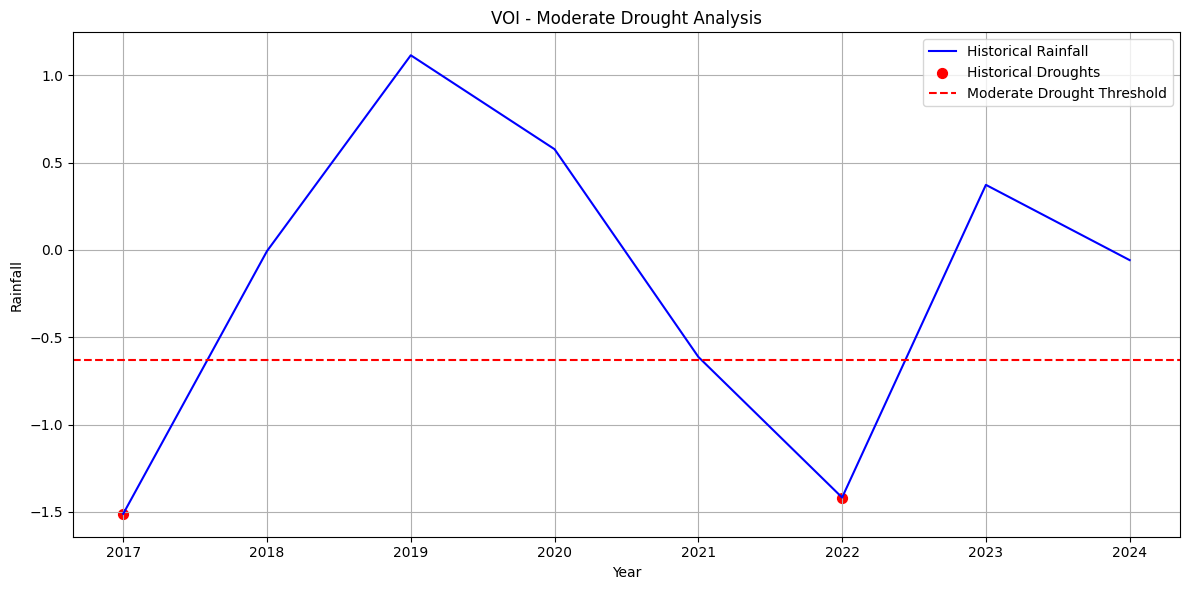


VOI Severe Drought Analysis:
  Drought Threshold: -1.07
  Drought Years: [2017 2022]
  Drought Frequency: 25.0%
  Average Drought Interval: 5.0 years

Error in forecast for VOI: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



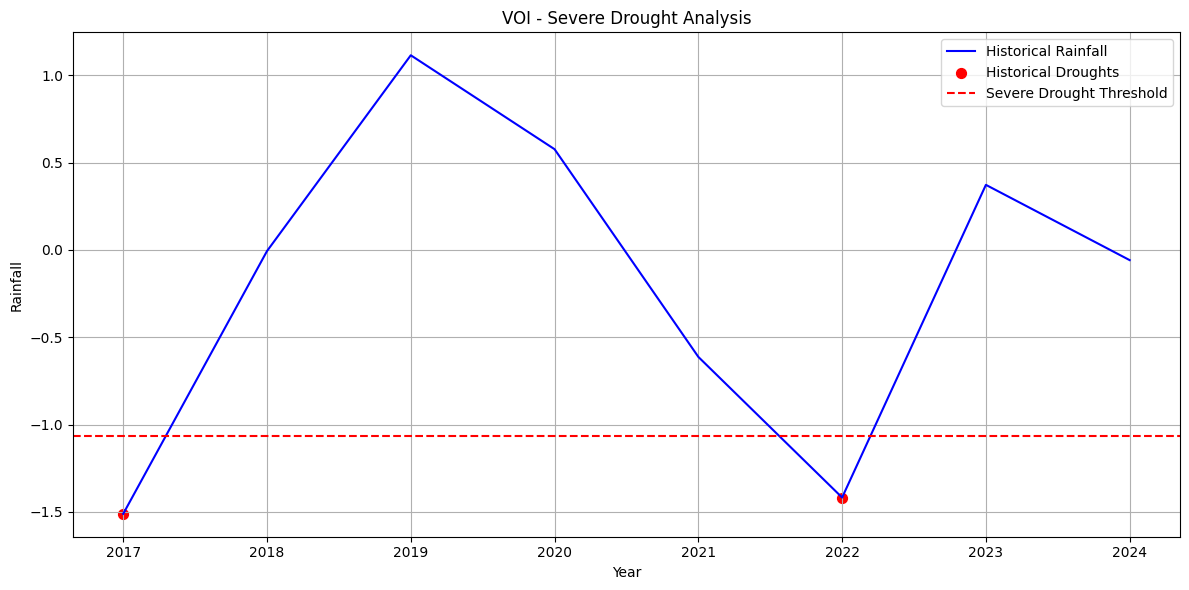


VOI Extreme Drought Analysis:
  Drought Threshold: -1.50
  Drought Years: [2017]
  Drought Frequency: 12.5%

Error in forecast for VOI: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



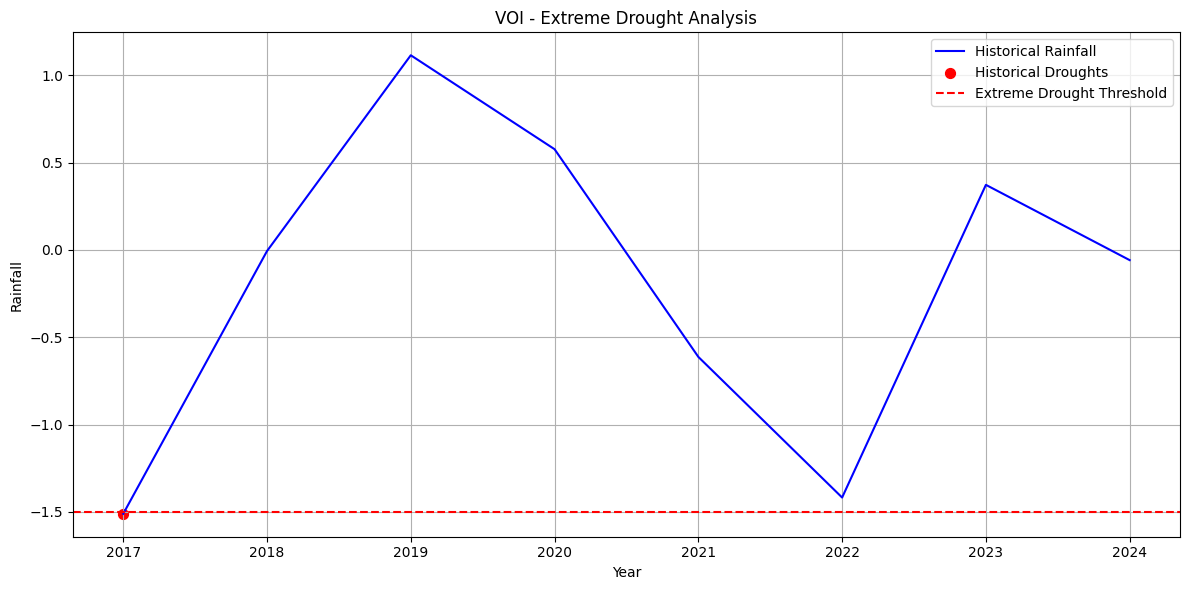


MOYALE COMPREHENSIVE DROUGHT ANALYSIS

MOYALE Drought Thresholds:
  Moderate Drought: -0.30
  Severe Drought: -0.74
  Extreme Drought: -1.18

MOYALE Moderate Drought Analysis:
  Drought Threshold: -0.30
  Drought Years: [2018 2021 2022]
  Drought Frequency: 37.5%
  Average Drought Interval: 2.0 years

Error in forecast for MOYALE: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



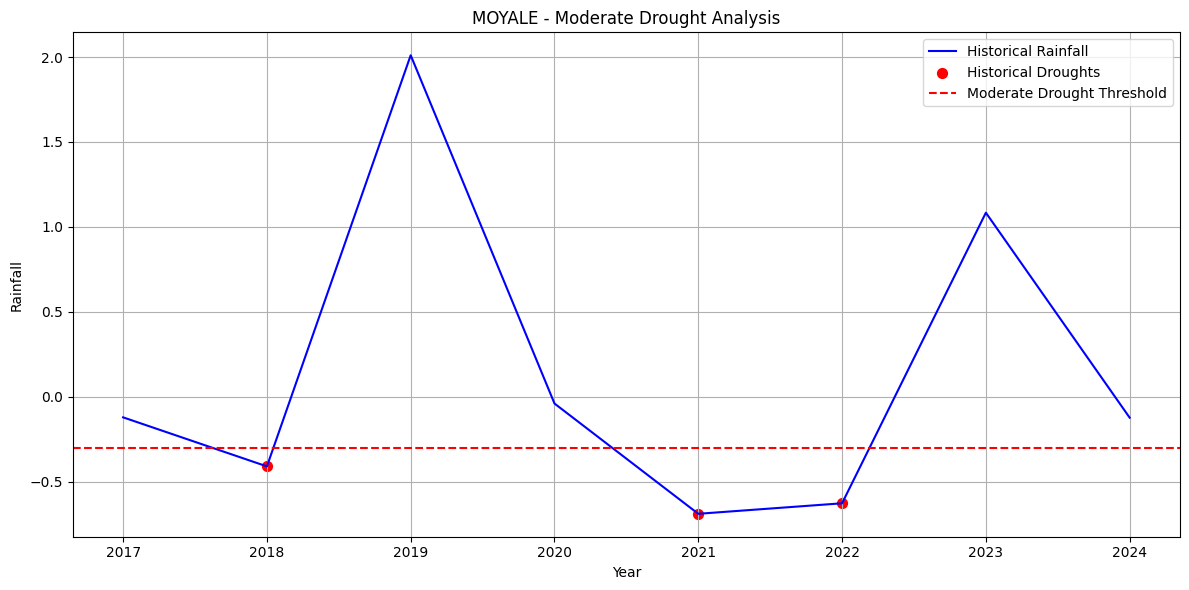


MOYALE Severe Drought Analysis:
  Drought Threshold: -0.74
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for MOYALE: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



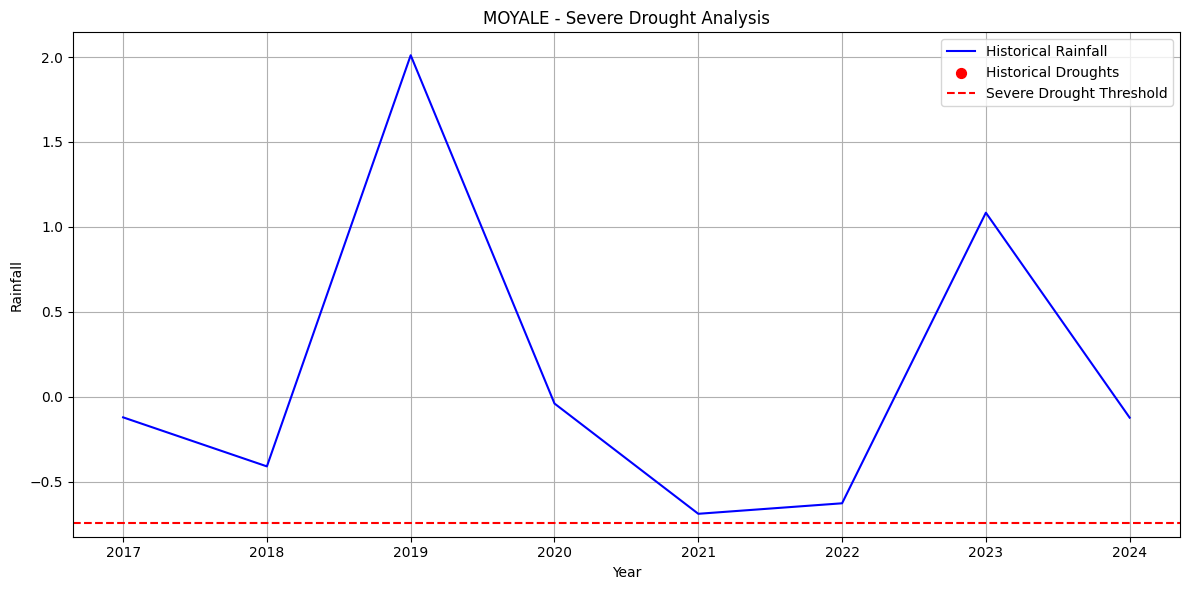


MOYALE Extreme Drought Analysis:
  Drought Threshold: -1.18
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for MOYALE: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



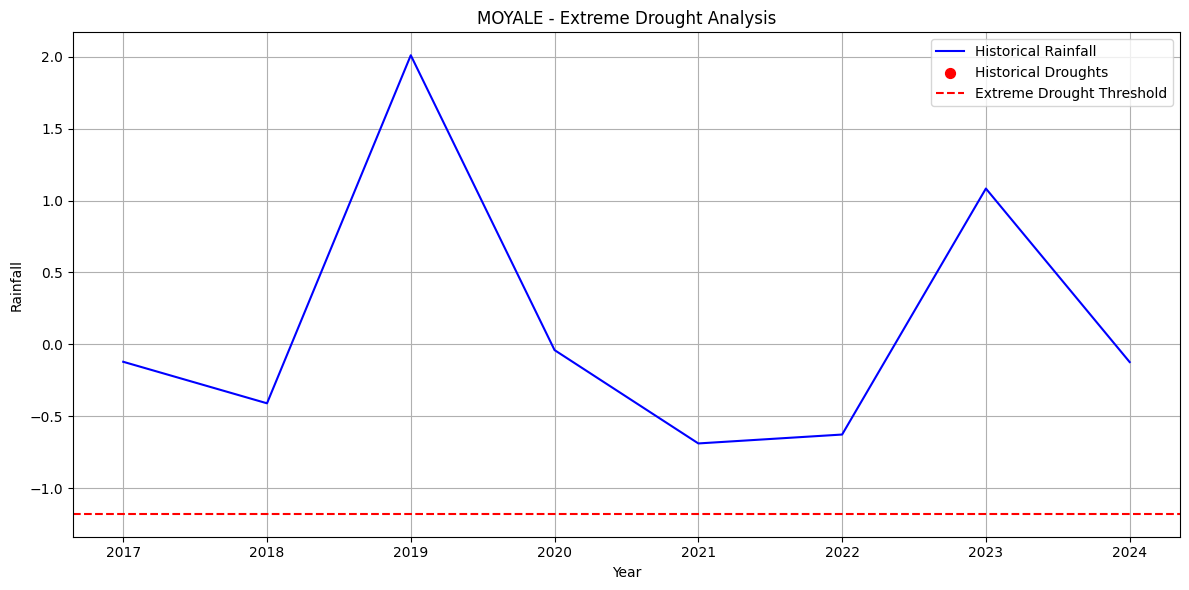


LODWAR COMPREHENSIVE DROUGHT ANALYSIS

LODWAR Drought Thresholds:
  Moderate Drought: -0.32
  Severe Drought: -0.72
  Extreme Drought: -1.13

LODWAR Moderate Drought Analysis:
  Drought Threshold: -0.32
  Drought Years: [2018 2021 2022]
  Drought Frequency: 37.5%
  Average Drought Interval: 2.0 years

Error in forecast for LODWAR: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



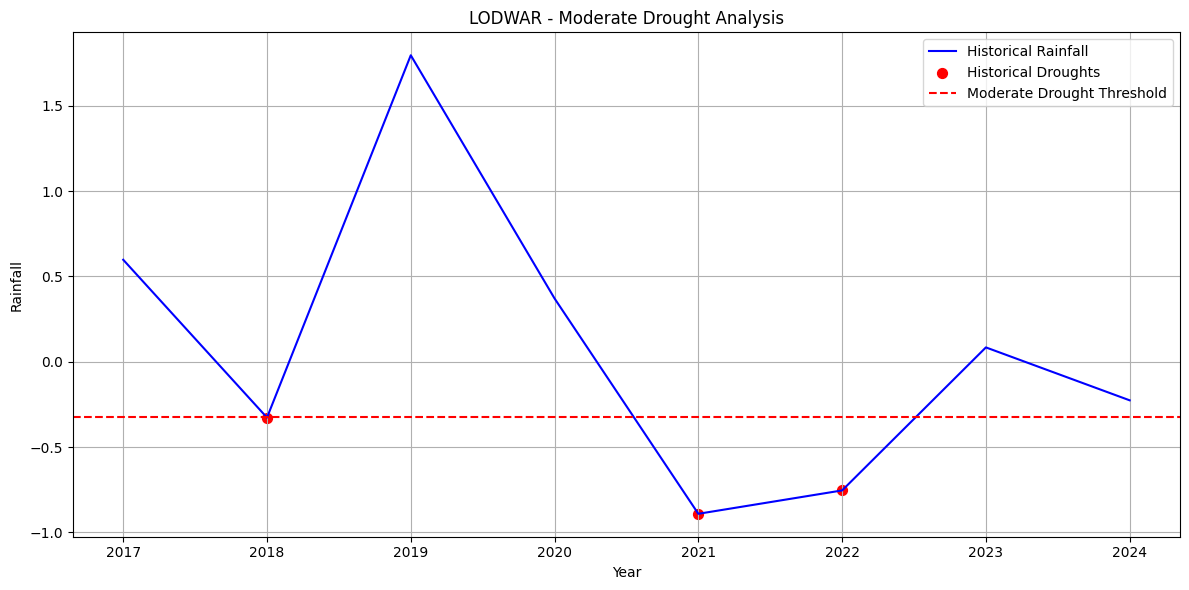


LODWAR Severe Drought Analysis:
  Drought Threshold: -0.72
  Drought Years: [2021 2022]
  Drought Frequency: 25.0%
  Average Drought Interval: 1.0 years

Error in forecast for LODWAR: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



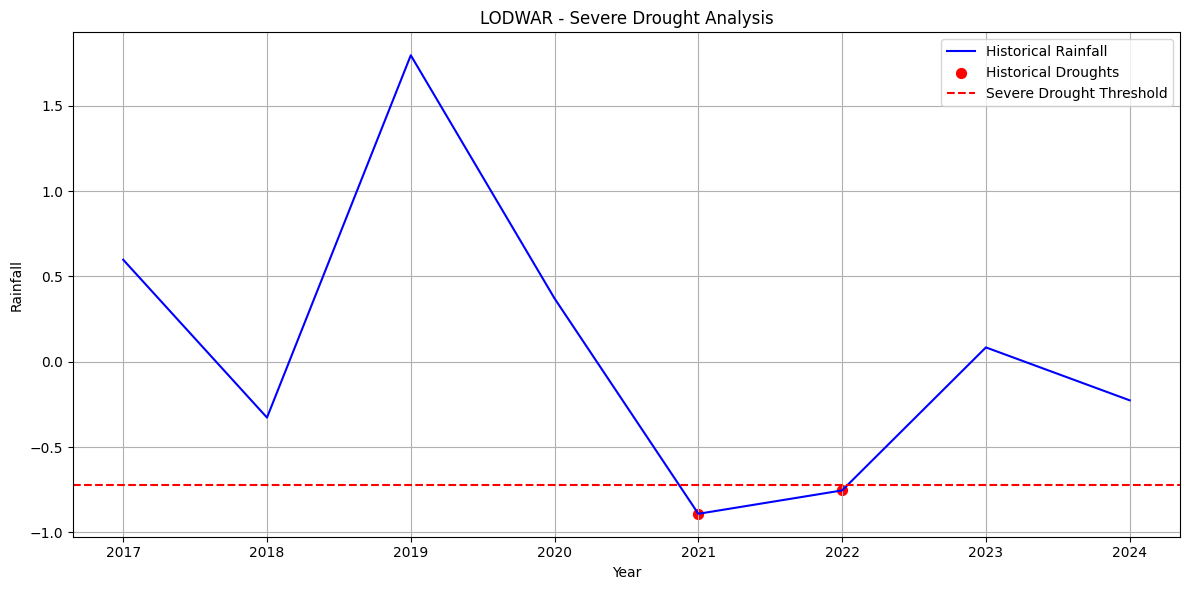


LODWAR Extreme Drought Analysis:
  Drought Threshold: -1.13
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for LODWAR: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



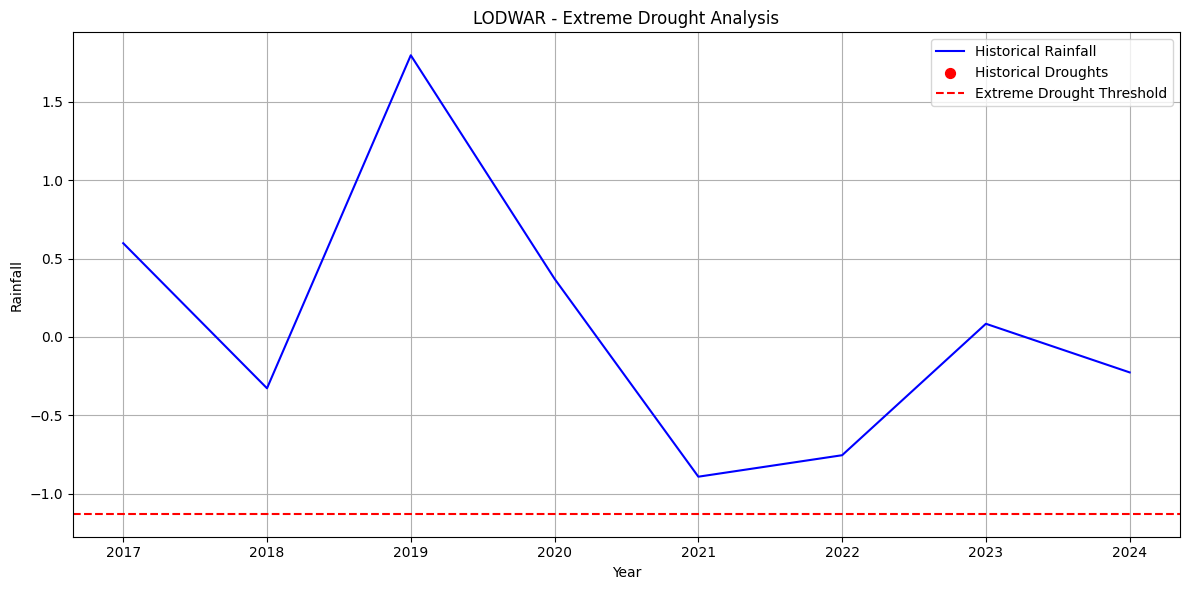


LAMU COMPREHENSIVE DROUGHT ANALYSIS

LAMU Drought Thresholds:
  Moderate Drought: -0.56
  Severe Drought: -1.37
  Extreme Drought: -2.19

LAMU Moderate Drought Analysis:
  Drought Threshold: -0.56
  Drought Years: [2017 2020 2021]
  Drought Frequency: 37.5%
  Average Drought Interval: 2.0 years

Error in forecast for LAMU: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



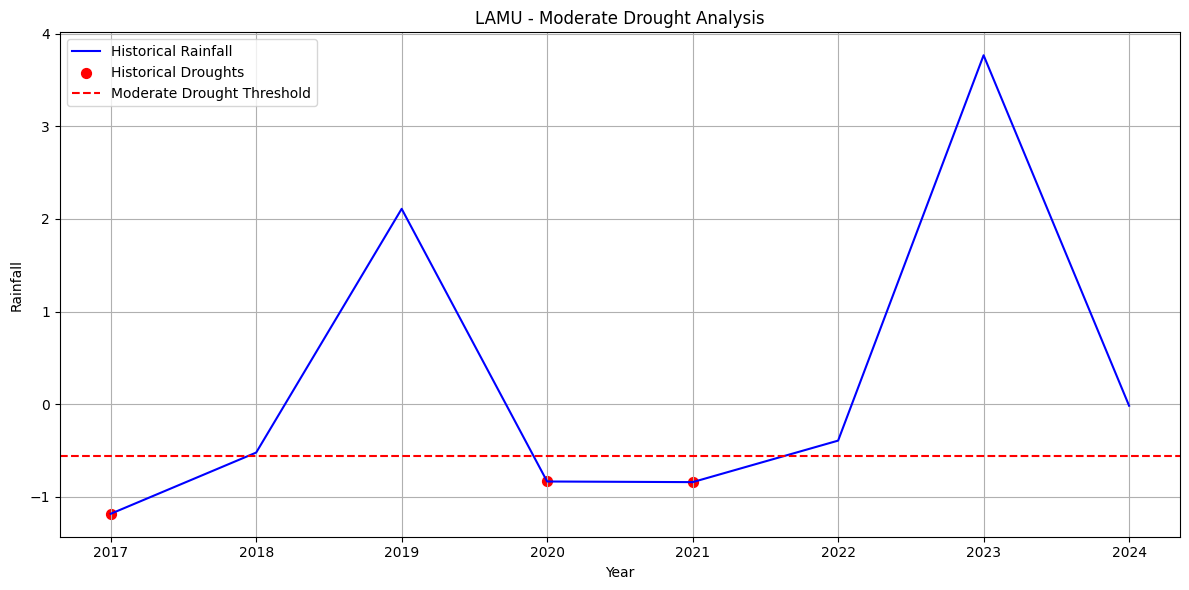


LAMU Severe Drought Analysis:
  Drought Threshold: -1.37
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for LAMU: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



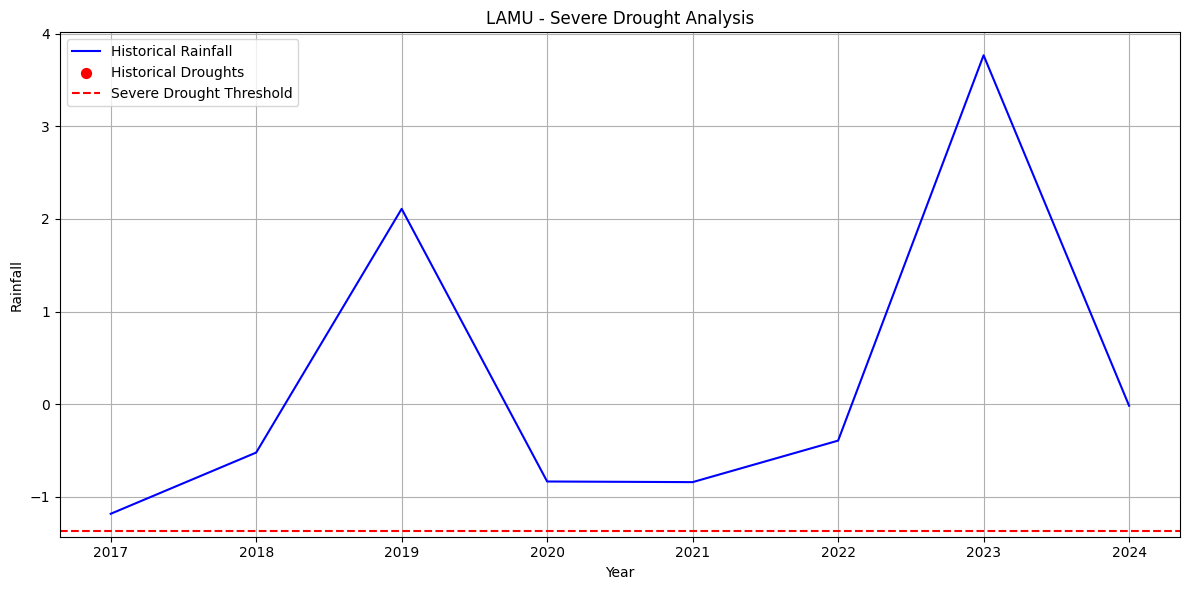


LAMU Extreme Drought Analysis:
  Drought Threshold: -2.19
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for LAMU: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



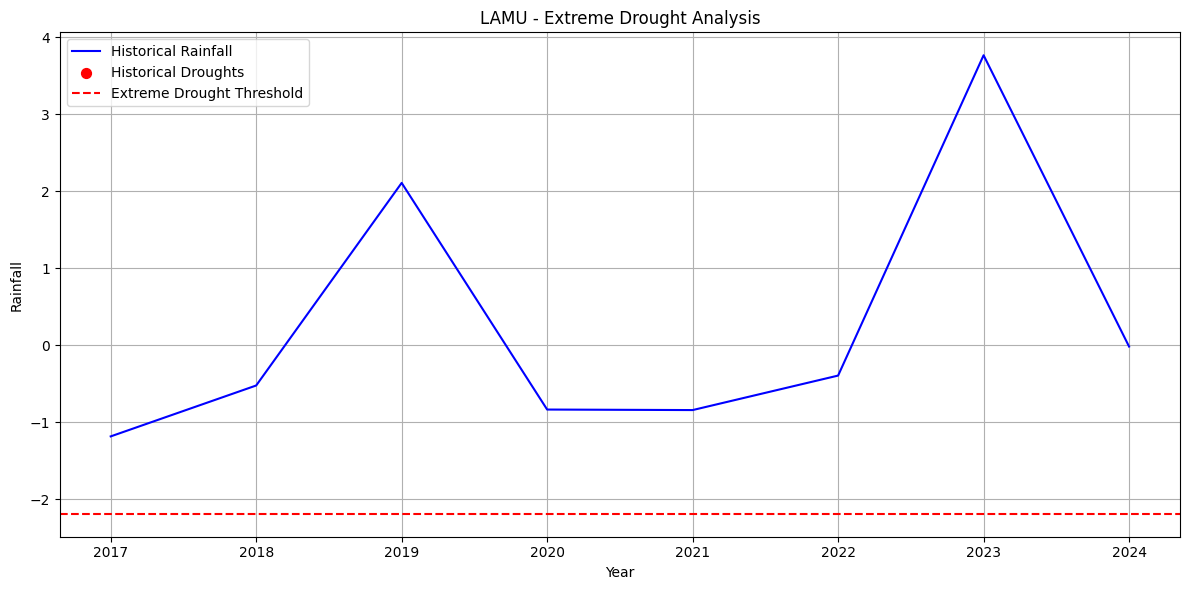


GARISSA COMPREHENSIVE DROUGHT ANALYSIS

GARISSA Drought Thresholds:
  Moderate Drought: -0.48
  Severe Drought: -1.05
  Extreme Drought: -1.62

GARISSA Moderate Drought Analysis:
  Drought Threshold: -0.48
  Drought Years: [2016 2017 2019 2020]
  Drought Frequency: 50.0%
  Average Drought Interval: 1.3 years

Error in forecast for GARISSA: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



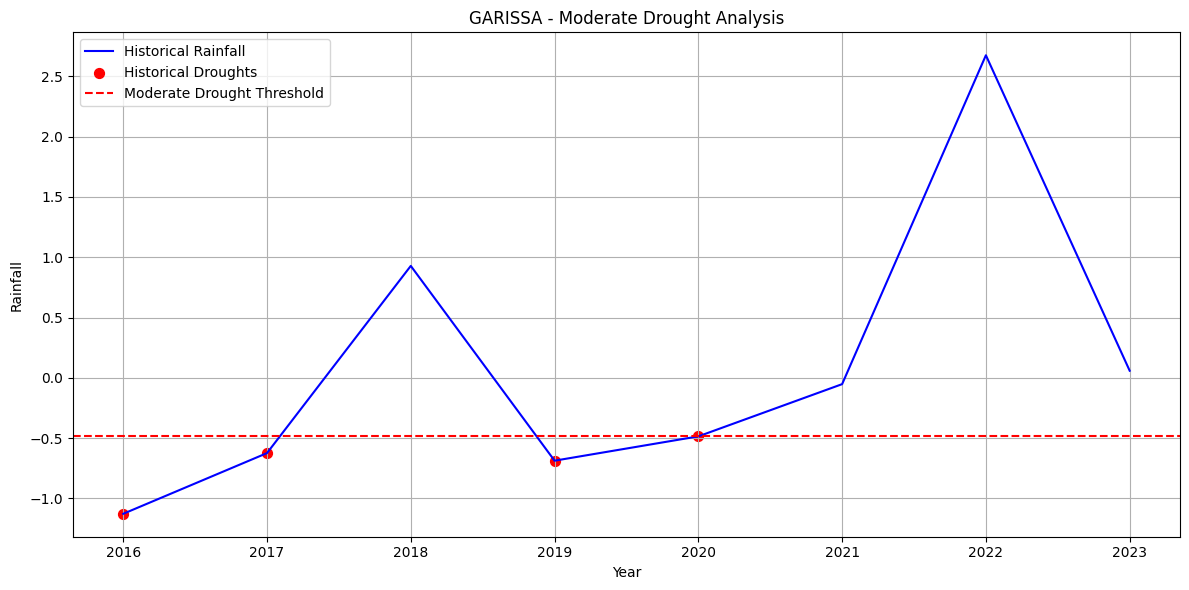


GARISSA Severe Drought Analysis:
  Drought Threshold: -1.05
  Drought Years: [2016]
  Drought Frequency: 12.5%

Error in forecast for GARISSA: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



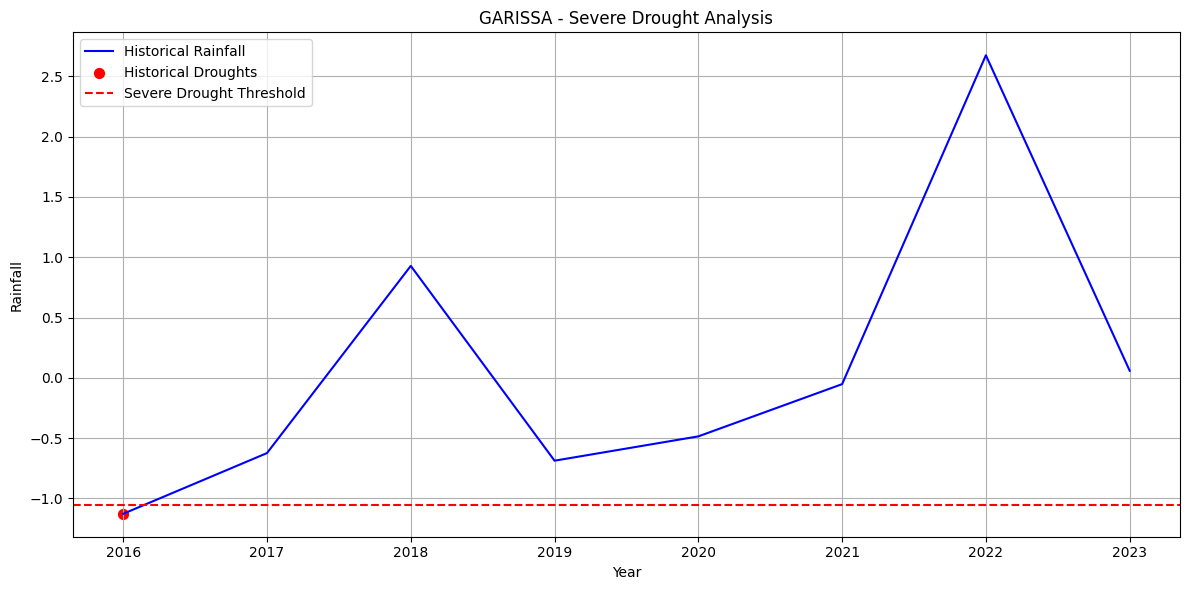


GARISSA Extreme Drought Analysis:
  Drought Threshold: -1.62
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for GARISSA: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



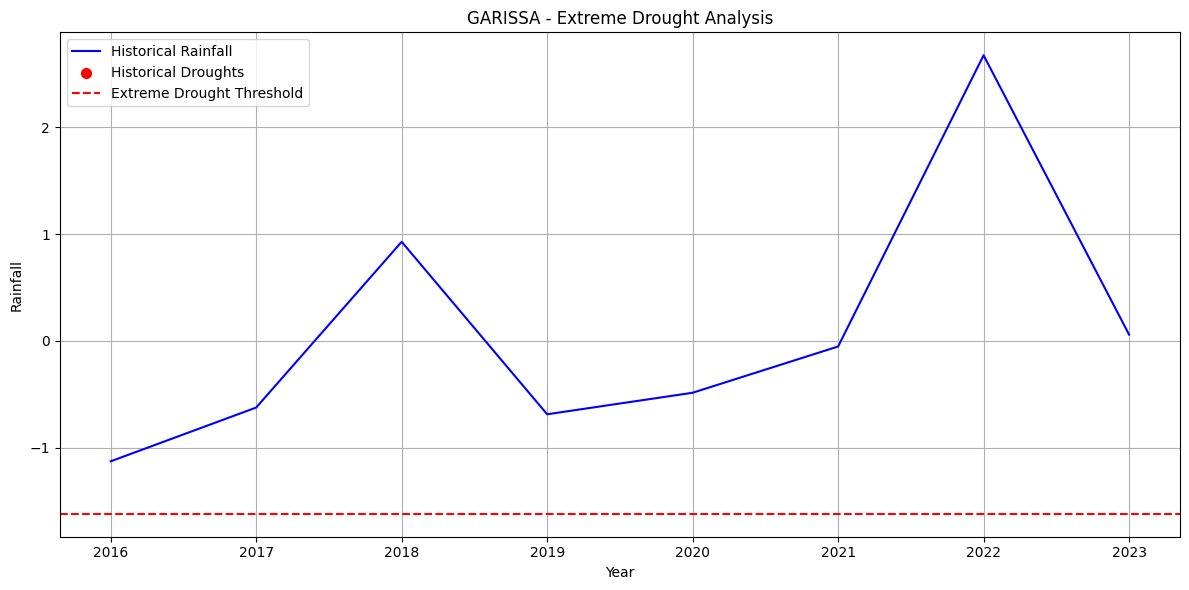


WAJIR COMPREHENSIVE DROUGHT ANALYSIS

WAJIR Drought Thresholds:
  Moderate Drought: -0.27
  Severe Drought: -0.98
  Extreme Drought: -1.68

WAJIR Moderate Drought Analysis:
  Drought Threshold: -0.27
  Drought Years: [2018 2020 2021 2022]
  Drought Frequency: 50.0%
  Average Drought Interval: 1.3 years

Error in forecast for WAJIR: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



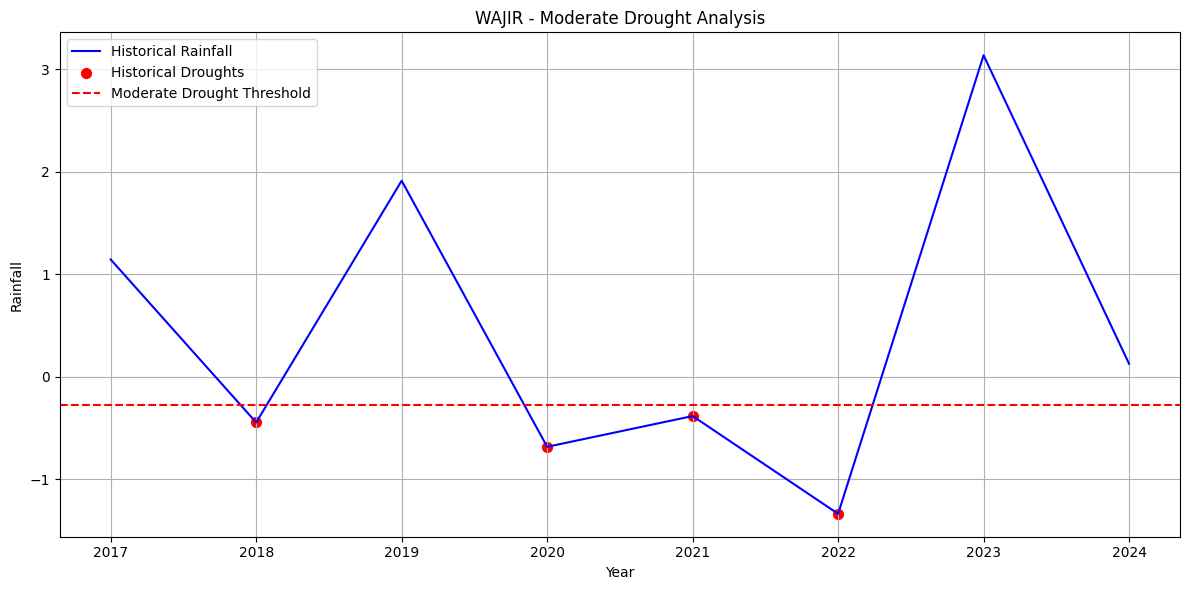


WAJIR Severe Drought Analysis:
  Drought Threshold: -0.98
  Drought Years: [2022]
  Drought Frequency: 12.5%

Error in forecast for WAJIR: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



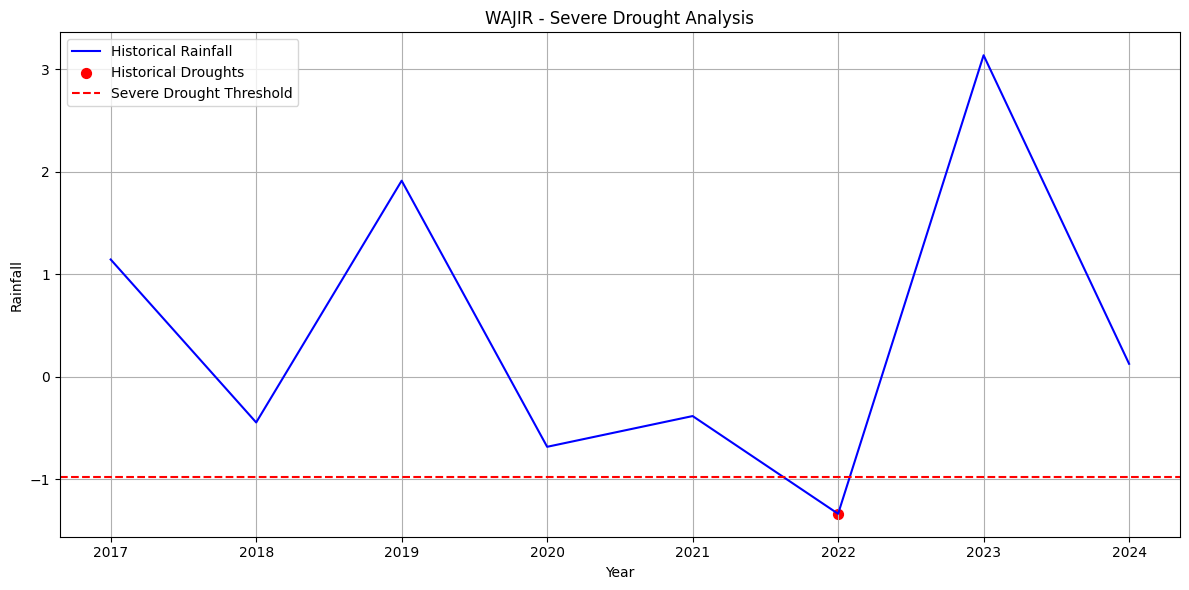


WAJIR Extreme Drought Analysis:
  Drought Threshold: -1.68
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for WAJIR: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



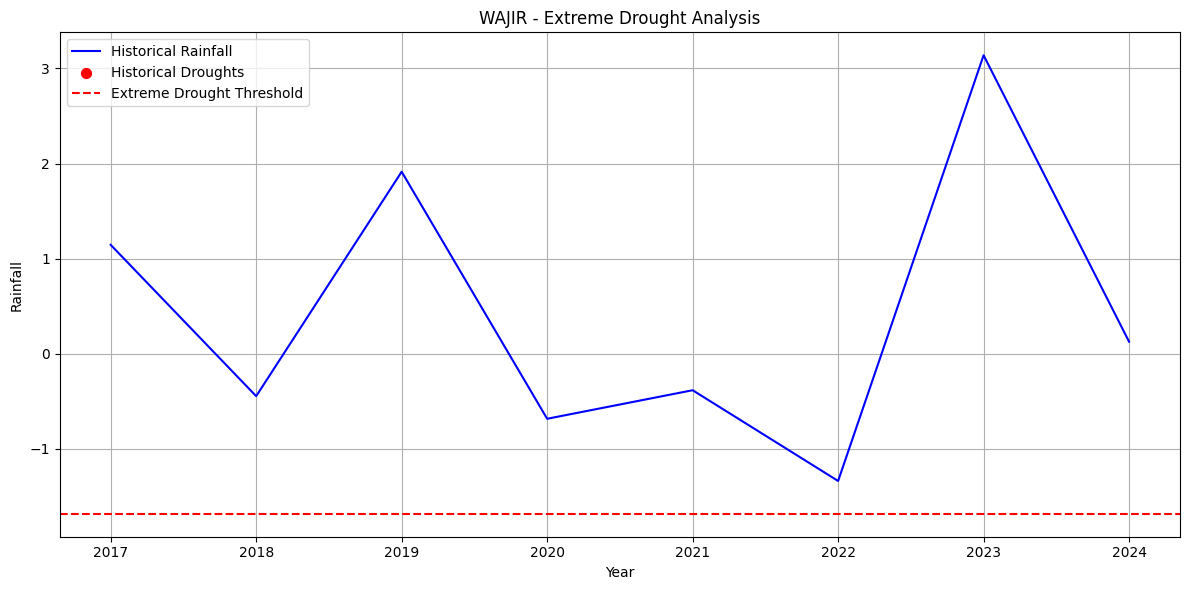


MOMBASA COMPREHENSIVE DROUGHT ANALYSIS

MOMBASA Drought Thresholds:
  Moderate Drought: -0.12
  Severe Drought: -0.71
  Extreme Drought: -1.30

MOMBASA Moderate Drought Analysis:
  Drought Threshold: -0.12
  Drought Years: [2020 2021 2022 2024]
  Drought Frequency: 57.1%
  Average Drought Interval: 1.3 years

Error in forecast for MOMBASA: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



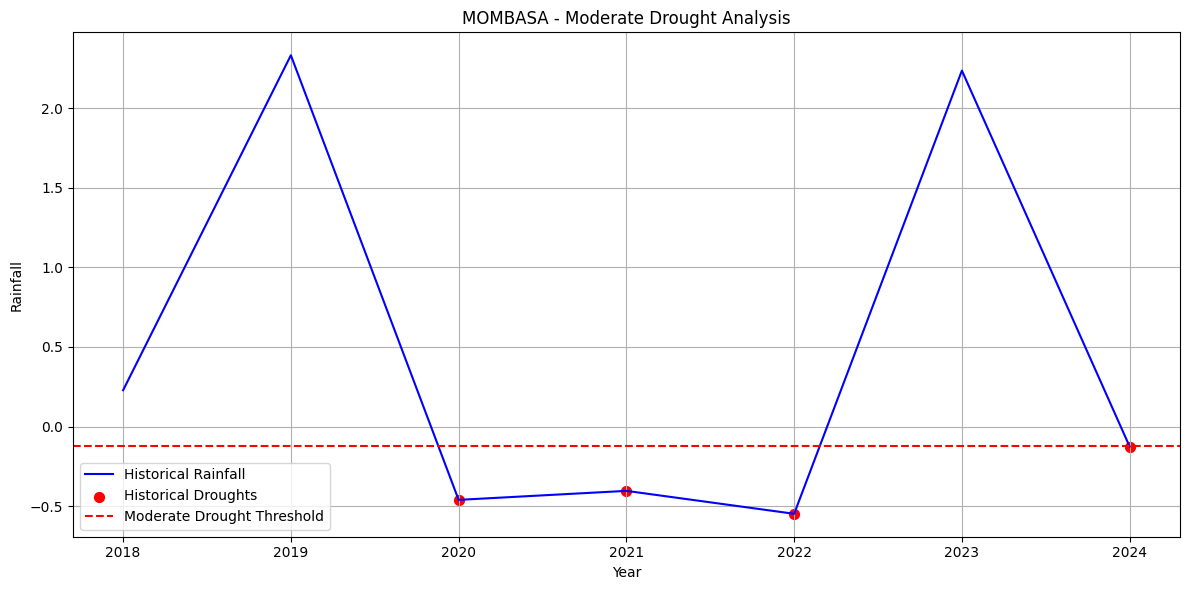


MOMBASA Severe Drought Analysis:
  Drought Threshold: -0.71
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for MOMBASA: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



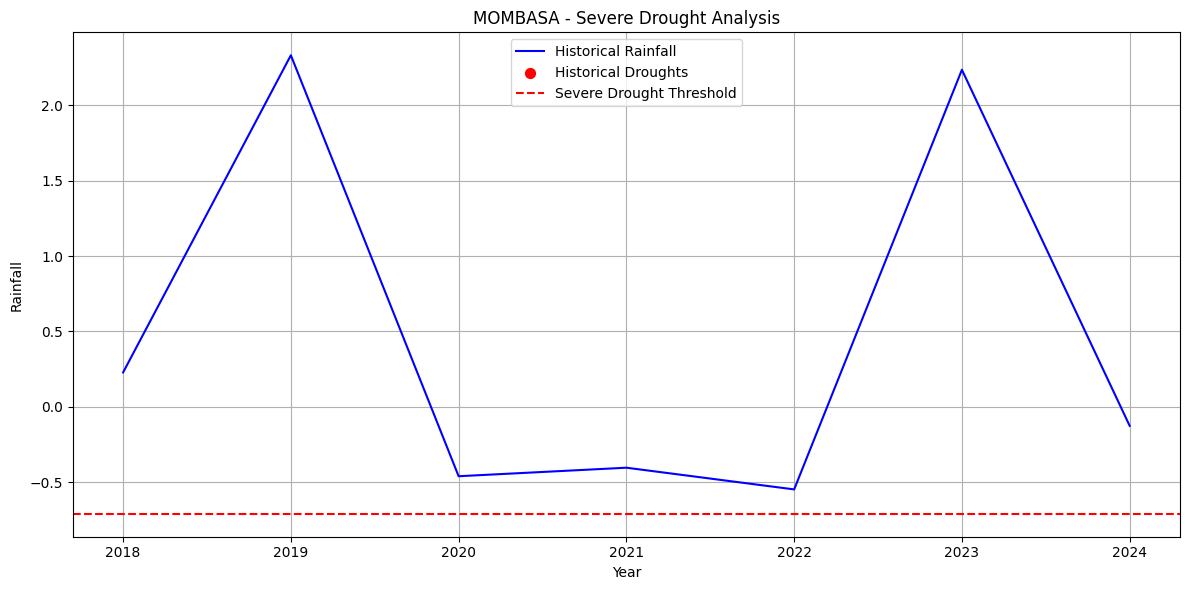


MOMBASA Extreme Drought Analysis:
  Drought Threshold: -1.30
  Drought Years: []
  Drought Frequency: 0.0%

Error in forecast for MOMBASA: 'dict' object has no attribute 'linregress'
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8828\132275657.py", line 104, in forecast_droughts
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
                                                  ^^^^^^^^^^^^^^^^
AttributeError: 'dict' object has no attribute 'linregress'



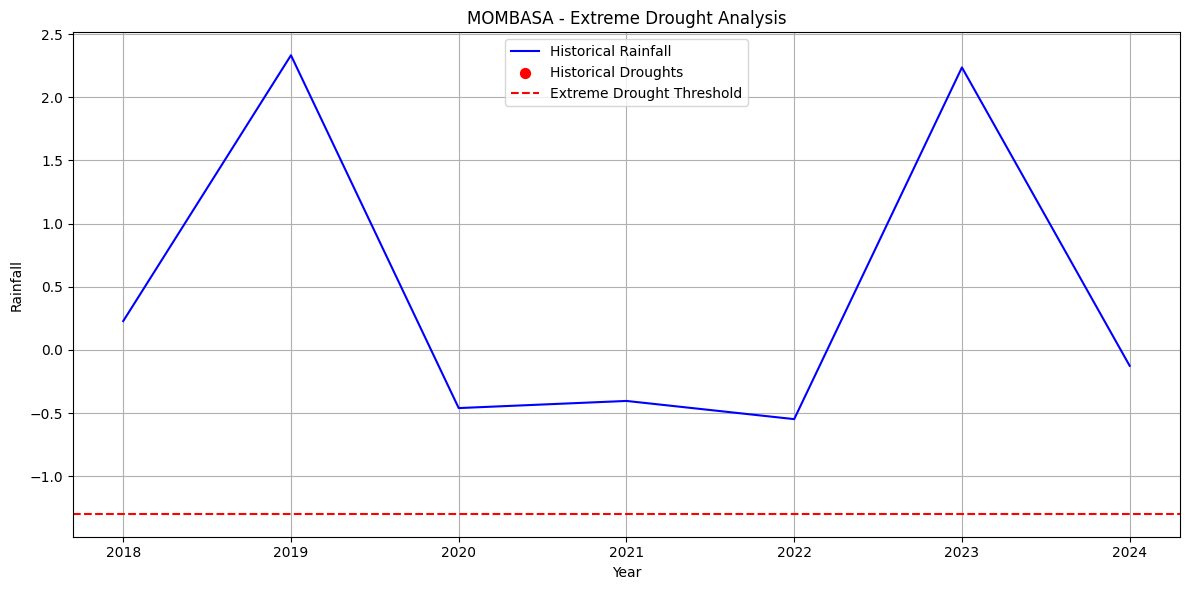

In [7]:
#FUTURE PREDICTION

class StationDroughtAnalyzer:
    def __init__(self, station_name, rainfall_data, years):
        """
        Initialize drought analyzer for a specific station
        
        :param station_name: Name of the weather station
        :param rainfall_data: Numpy array or list of rainfall values
        :param years: Corresponding years for rainfall data
        """
        self.station_name = station_name
        self.rainfall_data = np.array(rainfall_data)
        self.years = np.array(years)
        
        # Compute station-specific drought thresholds
        self.compute_drought_thresholds()
    
    def compute_drought_thresholds(self):
        """
        Compute multiple drought thresholds based on statistical analysis
        """
        # Calculate various statistical measures
        self.mean_rainfall = np.mean(self.rainfall_data)
        self.median_rainfall = np.median(self.rainfall_data)
        self.std_rainfall = np.std(self.rainfall_data)
        
        # Define multiple drought severity levels
        self.thresholds = {
            'moderate': self.mean_rainfall - 0.5 * self.std_rainfall,  # 1st level: below mean by 0.5 standard deviations
            'severe': self.mean_rainfall - 1.0 * self.std_rainfall,    # 2nd level: below mean by 1 standard deviation
            'extreme': self.mean_rainfall - 1.5 * self.std_rainfall    # 3rd level: below mean by 1.5 standard deviations
        }
        
        print(f"\n{self.station_name} Drought Thresholds:")
        for severity, threshold in self.thresholds.items():
            print(f"  {severity.capitalize()} Drought: {threshold:.2f}")
    
    def analyze_historical_droughts(self, drought_level='moderate'):
        """
        Analyze historical droughts for a given severity level
        
        :param drought_level: Severity of drought to analyze ('moderate', 'severe', 'extreme')
        :return: Dictionary of drought analysis results
        """
        # Validate drought level
        if drought_level not in self.thresholds:
            raise ValueError(f"Invalid drought level. Choose from {list(self.thresholds.keys())}")
        
        # Get the specific threshold
        drought_threshold = self.thresholds[drought_level]
        
        # Identify drought years
        drought_mask = self.rainfall_data <= drought_threshold
        drought_years = self.years[drought_mask]
        drought_values = self.rainfall_data[drought_mask]
        
        # Compute drought frequency
        drought_frequency = len(drought_years) / len(self.years) * 100
        
        # Compute intervals between droughts if more than one drought occurred
        drought_intervals = None
        avg_interval = None
        if len(drought_years) > 1:
            drought_intervals = np.diff(drought_years)
            avg_interval = np.mean(drought_intervals)
        
        # Prepare results dictionary
        results = {
            'drought_threshold': drought_threshold,
            'drought_years': drought_years.tolist(),
            'drought_values': drought_values.tolist(),
            'drought_frequency': drought_frequency,
            'avg_drought_interval': avg_interval
        }
        
        # Print analysis results
        print(f"\n{self.station_name} {drought_level.capitalize()} Drought Analysis:")
        print(f"  Drought Threshold: {drought_threshold:.2f}")
        print(f"  Drought Years: {drought_years}")
        print(f"  Drought Frequency: {drought_frequency:.1f}%")
        if avg_interval is not None:
            print(f"  Average Drought Interval: {avg_interval:.1f} years")
        
        return results
    
    def forecast_droughts(self, drought_level='moderate', forecast_period=10):
        """
        Forecast future droughts using statistical projection
        
        :param drought_level: Severity of drought to predict
        :param forecast_period: Number of years to forecast
        :return: Dictionary of forecast results
        """
        # Get the specific threshold for the drought level
        drought_threshold = self.thresholds[drought_level]
        
        try:
            # Basic linear regression forecast
            X = np.arange(len(self.years)).reshape(-1, 1)
            y = self.rainfall_data
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
            
            # Generate forecast years
            last_year = self.years[-1]
            forecast_years = np.arange(last_year + 1, last_year + forecast_period + 1)
            
            # Project future values based on trend
            forecast = intercept + slope * np.arange(len(self.years), len(self.years) + forecast_period)
            
            # Add some randomness to make it more realistic
            forecast += np.random.normal(0, std_err, forecast_period)
            
            # Identify drought years in forecast
            forecast_drought_mask = forecast <= drought_threshold
            predicted_drought_years = forecast_years[forecast_drought_mask]
            predicted_drought_values = forecast[forecast_drought_mask]
            
            # Prepare forecast results
            forecast_results = {
                'forecast_years': forecast_years.tolist(),
                'forecast_values': forecast.tolist(),
                'predicted_drought_years': predicted_drought_years.tolist(),
                'predicted_drought_values': predicted_drought_values.tolist()
            }
            
            # Print forecast results
            print(f"\n{self.station_name} {drought_level.capitalize()} Drought Forecast:")
            print("Year | Forecasted Rainfall | Drought Status")
            print("-" * 45)
            for year, value in zip(forecast_years, forecast):
                status = "DROUGHT" if value <= drought_threshold else "Normal"
                print(f"{year} | {value:7.2f}        | {status}")
            
            return forecast_results
        
        except Exception as e:
            print(f"\nError in forecast for {self.station_name}: {str(e)}")
            print(traceback.format_exc())
            return None
    
    def visualize_drought_analysis(self, historical_analysis, forecast_results=None, drought_level='moderate'):
        """
        Create a comprehensive visualization of drought analysis
        
        :param historical_analysis: Results from historical drought analysis
        :param forecast_results: Results from drought forecast (optional)
        :param drought_level: Severity of drought being analyzed
        """
        plt.figure(figsize=(12, 6))
        
        # Plot full rainfall data
        plt.plot(self.years, self.rainfall_data, 'b-', label='Historical Rainfall')
        
        # Highlight historical drought years
        drought_mask = np.array(self.rainfall_data) <= historical_analysis['drought_threshold']
        plt.scatter(
            self.years[drought_mask], 
            np.array(self.rainfall_data)[drought_mask], 
            color='red', s=50, label='Historical Droughts'
        )
        
        # Add drought threshold line
        plt.axhline(
            y=historical_analysis['drought_threshold'], 
            color='r', 
            linestyle='--', 
            label=f'{drought_level.capitalize()} Drought Threshold'
        )
        
        # Plot forecast if available
        if forecast_results:
            forecast_years = forecast_results['forecast_years']
            forecast_values = forecast_results['forecast_values']
            plt.plot(forecast_years, forecast_values, 'g--', label='Statistical Forecast')
            
            # Highlight predicted drought years
            if forecast_results['predicted_drought_years']:
                plt.scatter(
                    forecast_results['predicted_drought_years'], 
                    forecast_results['predicted_drought_values'], 
                    color='orange', marker='x', s=50, 
                    label='Predicted Droughts'
                )
        
        plt.title(f"{self.station_name} - {drought_level.capitalize()} Drought Analysis")
        plt.xlabel("Year")
        plt.ylabel("Rainfall")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def perform_comprehensive_drought_analysis(results_dict):
    """
    Perform comprehensive drought analysis for all stations
    
    :param results_dict: Dictionary containing station results from previous analysis
    :return: Comprehensive drought analysis results
    """
    comprehensive_drought_analysis = {}
    
    for station in results_dict.keys():
        print(f"\n{'='*70}\n{station} COMPREHENSIVE DROUGHT ANALYSIS\n{'='*70}")
        
        # Get the best model results for this station
        best_model_name = max(results_dict[station].keys(), key=lambda k: results_dict[station][k]['r2'])
        station_results = results_dict[station][best_model_name]
        
        # Extract years and rainfall data
        years = station_results['years']
        rainfall = station_results['actuals']
        
        # Create station-specific drought analyzer
        analyzer = StationDroughtAnalyzer(station, rainfall, years)
        
        # Analyze droughts at different severity levels
        drought_analysis = {}
        for severity in ['moderate', 'severe', 'extreme']:
            # Historical drought analysis
            historical_analysis = analyzer.analyze_historical_droughts(drought_level=severity)
            
            # Forecast droughts
            forecast_results = analyzer.forecast_droughts(drought_level=severity)
            
            # Visualize results
            analyzer.visualize_drought_analysis(historical_analysis, forecast_results, drought_level=severity)
            
            # Store results
            drought_analysis[severity] = {
                'historical': historical_analysis,
                'forecast': forecast_results
            }
        
        # Store comprehensive analysis for this station
        comprehensive_drought_analysis[station] = drought_analysis
    
    return comprehensive_drought_analysis

# Run the comprehensive drought analysis
comprehensive_results = perform_comprehensive_drought_analysis(results_dict)

In [ ]:
print (summary_df)